<a href="https://colab.research.google.com/github/Zinni98/Sentiment-analysis-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Notes:*
- *If a function doesn't have the docstring, it means that: a similar function has already been commented or the function is trivial.*

- *Note that explanation of algorithms, results... is not present in this notebook. Please refer to the report present inside the repository where you have find this notebook to find this information.*

- *Dataset analysis is not done in this notebook, you can find it in* ```exploratory.ipynb``` *inside the repository where you have find this notebook.*

In [ ]:
# Optional: path that stores the torchtext embeddings
embedding_path = "/content/gdrive/My Drive/nlu-project/Embeddings/.vector_cache"
# Path where sentiment lexicons are stored (Give the path to the lexicon folder of the repository)
lexicon_path = "/content/gdrive/My Drive/nlu-project/lexicons/"
# Path Specifying where to save attention maps images
image_path = "/content/gdrive/My Drive/nlu-project/images/"

In [ ]:
import sys
from google.colab import drive


import nltk
from nltk.corpus import stopwords
from nltk.corpus import subjectivity
from nltk.corpus import movie_reviews
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.util import mark_negation


import os
import re
import math
import json
from abc import ABC, abstractmethod
from typing import List


import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim import RAdam
import torch.nn.functional as F
from torchtext.vocab import GloVe
from torch.utils.data import Subset
from torch.autograd import Variable
from torchtext.vocab import FastText
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn.utils.rnn import pad_packed_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
drive.mount("/content/gdrive/")
sys.path.append("/content/gdrive/My Drive/nlu-project")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
nltk.download("punkt")
nltk.download("movie_reviews")
nltk.download("subjectivity")
nltk.download("stopwords")
nltk.download("sentiwordnet")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package subjectivity to /root/nltk_data...
[nltk_data]   Unzipping corpora/subjectivity.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
fast_text = FastText('en', cache = embedding_path)
global_vectors = GloVe(name='840B', dim=300, cache = embedding_path)

In [ ]:
CONTRACTION_MAP =  {"ain't": "is not",
                        "aren't": "are not",
                        "can't": "cannot",
                        "can't've": "cannot have",
                        "'cause": "because",
                        "could've": "could have",
                        "couldn't": "could not",
                        "couldn't've": "could not have",
                        "didn't": "did not",
                        "doesn't": "does not",
                        "don't": "do not",
                        "hadn't": "had not",
                        "hadn't've": "had not have",
                        "hasn't": "has not",
                        "haven't": "have not",
                        "he'd": "he would",
                        "he'd've": "he would have",
                        "he'll": "he will",
                        "he'll've": "he he will have",
                        "he's": "he is",
                        "how'd": "how did",
                        "how'd'y": "how do you",
                        "how'll": "how will",
                        "how's": "how is",
                        "i'd": "i would",
                        "i'd've": "i would have",
                        "i'll": "i will",
                        "i'll've": "i will have",
                        "i'm": "i am",
                        "i've": "i have",
                        "isn't": "is not",
                        "it'd": "it would",
                        "it'd've": "it would have",
                        "it'll": "it will",
                        "it'll've": "it will have",
                        "it's": "it is",
                        "let's": "let us",
                        "ma'am": "madam",
                        "mayn't": "may not",
                        "might've": "might have",
                        "mightn't": "might not",
                        "mightn't've": "might not have",
                        "must've": "must have",
                        "mustn't": "must not",
                        "mustn't've": "must not have",
                        "needn't": "need not",
                        "needn't've": "need not have",
                        "o'clock": "of the clock",
                        "oughtn't": "ought not",
                        "oughtn't've": "ought not have",
                        "shan't": "shall not",
                        "sha'n't": "shall not",
                        "shan't've": "shall not have",
                        "she'd": "she would",
                        "she'd've": "she would have",
                        "she'll": "she will",
                        "she'll've": "she will have",
                        "she's": "she is",
                        "should've": "should have",
                        "shouldn't": "should not",
                        "shouldn't've": "should not have",
                        "so've": "so have",
                        "so's": "so as",
                        "that'd": "that would",
                        "that'd've": "that would have",
                        "that's": "that is",
                        "there'd": "there would",
                        "there'd've": "there would have",
                        "there's": "there is",
                        "they'd": "they would",
                        "they'd've": "they would have",
                        "they'll": "they will",
                        "they'll've": "they will have",
                        "they're": "they are",
                        "they've": "they have",
                        "to've": "to have",
                        "wasn't": "was not",
                        "we'd": "we would",
                        "we'd've": "we would have",
                        "we'll": "we will",
                        "we'll've": "we will have",
                        "we're": "we are",
                        "we've": "we have",
                        "weren't": "were not",
                        "what'll": "what will",
                        "what'll've": "what will have",
                        "what're": "what are",
                        "what's": "what is",
                        "what've": "what have",
                        "when's": "when is",
                        "when've": "when have",
                        "where'd": "where did",
                        "where's": "where is",
                        "where've": "where have",
                        "who'll": "who will",
                        "who'll've": "who will have",
                        "who's": "who is",
                        "who've": "who have",
                        "why's": "why is",
                        "why've": "why have",
                        "will've": "will have",
                        "won't": "will not",
                        "won't've": "will not have",
                        "would've": "would have",
                        "wouldn't": "would not",
                        "wouldn't've": "would not have",
                        "y'all": "you all",
                        "y'all'd": "you all would",
                        "y'all'd've": "you all would have",
                        "y'all're": "you all are",
                        "y'all've": "you all have",
                        "you'd": "you would",
                        "you'd've": "you would have",
                        "you'll": "you will",
                        "you'll've": "you will have",
                        "you're": "you are",
                        "you've": "you have",
                    }

class PipelineElement(ABC):
  """
  Abstract class for the definition of each element
  """
  def __init__(self):
    pass

  @abstractmethod
  def __call__(self):
    pass


class Pipeline():
  """
  Pipeline class which collects pipeline elements (in the order given).
  This class implements __call__ method so it is a callable.
  When called it applies all the PipelineElements in the order given.
  """
  def __init__(self, *args):
    """
    Parameters
    ----------
    *args
      PipelineElements
    """
    self.pipeline = []
    for arg in args:
      self.add_pipeline_element(arg)

  def add_pipeline_element(self, element: PipelineElement, position: int = None):
    """
    Adds a new pipeline element to the pipeline
    
    Parameters
    ----------
    element : PipelineElement
      the element to be added to the pipeline
    
    position : int
      position in the pipeline where the element should be added
      position ranges from 0 to (n_elements - 1) where n_elements
      is the number of elements in the pipeline.
    Raises
    ------
    TypeError
      If the type of element is not PipelineElement
    """
    if not issubclass(type(element), PipelineElement):
      raise TypeError("Wrong element type, only Pipeline elements subclasses can be added")
    if position:
      if position >= len(self.pipeline):
        raise ValueError("position index exceeds the lenght of the pipeline")
      self.pipeline.insert(position, element)
    else:
      self.pipeline.append(element)
  
  def pipe(self, corpus):
    """
    Applies each element in the pipeline

    Parameters
    ----------
    corpus : list
      list containing each document in the corpus
    """
    for el in self.pipeline:
        corpus = el(corpus)
    return corpus
  
  def get_elements(self):
    """
    Gives elements of the pipeline with respective index indicateing the order
    in which elements are called

    Returns
    -------
    dict
      Where the key indicates the position of each element in the pipeline
      (i.e. execution order, where 0 is the first element of the pipeline
      being called) and the value indicates the actual element.
    """
    res = {}
    for idx, el in pipeline:
      res[idx] = el
    return res
 
  def __call__(self, *args):
      if args[0] == None:
          raise ValueError("Need a corpus as argument")
      corpus = args[0]
      return self.pipe(corpus)
  
  def __len__(self):
    return len(pipeline)
        
# Flattened Elements

class UnderscoreRemoverFlat(PipelineElement):
  """
  Assumes the corpus is flat (i.e. the corpus is a list of documents,
  each document is a list of words, therefore the document is not
  divided in sentences)
  """
  def __init__(self):
    super(UnderscoreRemoverFlat, self).__init__()

  def remove_underscores(self, corpus):
    """
    Solves the problem where some of the words are surrounded by underscores
    (e.g. "_hello_")

    Parameters
    ----------
    corpus : list of list of list
      corpus to be processed
    """
    for doc in corpus:
        for idx, word in enumerate(doc):
            if "_" in word:
                cleaned_word = self._clean_word(word)
                doc[idx] = cleaned_word
    return corpus


  def _clean_word(self, word: str):
    word = word.replace("_", " ")
    # in order to remove spaces before and after the word
    word = word.split()
    word = " ".join(word)
    return word

  def __call__(self, corpus):
    return self.remove_underscores(corpus)

class CharacterRepetitionRemoverFlat(PipelineElement):
  """
  Reduces repetition to two characters 
  for alphabets and to one character for punctuations.

  Examples
  --------
  >>> reducing_character_repetitions([["Realllllllllyyyyy,        Greeeeaaaatttt   !!!!?....;;;;:)"]])
  Really, Great !?.;:)
  """
  def __init__(self):
    super(CharacterRepetitionRemoverFlat, self).__init__()

  def reducing_character_repetitions(self, corpus):
    """
    Parameters
    ----------
      corpus : list of list of list
    Returns
    -------
    list of list
      Formatted text with alphabets repeating to 
      two characters & punctuations limited to one repetition 

    """
    new_corpus = []
    for doc in corpus:
        new_doc = [self._clean_repetitions(w) for w in doc]
        new_corpus.append(new_doc)
    return new_corpus

  # inspired by https://towardsdatascience.com/cleaning-preprocessing-text-data-by-building-nlp-pipeline-853148add68a
  def _clean_repetitions(self, word):
    # Pattern matching for all case alphabets
    pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)

    # Limiting all the repetitions to two characters.
    formatted_text = pattern_alpha.sub(r"\1\1", word) 

    # Pattern matching for all the punctuations that can occur
    pattern_punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')

    # Limiting punctuations in previously formatted string to only one.
    combined_formatted = pattern_punct.sub(r'\1', formatted_text)

    # The below statement is replacing repetitions of spaces that occur more than two times with that of one occurrence.
    final_formatted = re.sub(' {2,}',' ', combined_formatted)
    return final_formatted

  def __call__(self, corpus):
    return self.reducing_character_repetitions(corpus)

class ApostrophesMergerFlat(PipelineElement):
  """
  Merges words like "don't" which in the original corpus are
  separated like: ["don", "'", "t"]

  Examples
  --------
  >>> am = ApostrophesMergerFlat()
  >>> am([["I", "'", "ve", "a", "pair", "of", "shoes"]])
  [["I've", "a", "pair", "of", "shoes"]]
  """

  def __init__(self):
    super(ApostrophesMergerFlat, self).__init__()

  def merge_apostrophes(self, corpus):
    """
    Parameters
    ----------
    corpus : list of list of list

    Returns
    -------
    list of list
      Formatted text where contractions are merged into one single word
    
    """
    new_corpus = []
    for doc in corpus:
      indexes = self._get_neg_indexes(doc)
      for el in indexes:
        doc[el[0]:el[1]] = ["".join(doc[el[0]:el[1]])]
      new_corpus.append(doc)
    return new_corpus

  def _get_neg_indexes(self, sent):

    # s not considered because contraction can be either "is", genitive or "has"
    contr = ["t", "ve", "re", "ll", "d", "all", "y", "cause", "m", "clock", "am"] #, "s"]
    indexes = []
    for idx, word in enumerate(sent):
      # Try-except to avoid out of range indexes (there can be some "'" a the beginning or end of the phrase)
      try:
        if word=="'" and sent[idx+1] in contr:
          indexes.append((idx-1,idx+2))
      except:
        pass
    return indexes
  
  def __call__(self, corpus):
    return self.merge_apostrophes(corpus)


class ContractionCleanerFlat(PipelineElement):
  """
  Clean all contractions by using a predifined contraction map

  Example
  -------
  >>> cc = ContractionCleanerFlat
  """
  def __init__(self):
    super(ContractionCleanerFlat, self).__init__()

  def clean_contractions(self, corpus):
    """
    Parameters
    ----------
    corpus : list of list of list

    Returns
    -------
    list of list
      Formatted text where contractions are merged into one single word

    """
    new_corpus = []
    for doc in corpus:
      new_doc = []
      for word in doc:
        try:
            correct = CONTRACTION_MAP[word]
            correct = correct.split()
            new_doc += correct
        except:
            new_doc.append(word)
      new_corpus.append(new_doc)
    return new_corpus

  def __call__(self, corpus):
    return self.clean_contractions(corpus)

class SpecialCharsCleanerFlat(PipelineElement):
  """
  Removes all special characters which are not part of
  the folllowing regex pattern: "[^a-zA-Z0-9:€$-,%?!]+"
  """
  def __init__(self):
    super(SpecialCharsCleanerFlat, self).__init__()

  def clean_special_chars(self, corpus):
    new_corpus = [[self._clean_special_word(w) for w in doc] for doc in corpus]
    new_corpus = [[w for w in doc] for doc in corpus]
    return new_corpus
    
  def _clean_special_word(self, word):
    # The formatted text after removing not necessary punctuations.
    formatted_text = re.sub(r"[^a-zA-Z0-9:€$-,%?!]+", '', word) 
    # In the above regex expression,I am providing necessary set of punctuations that are frequent in this particular dataset.
    return formatted_text
  
  def __call__(self, corpus):
    return self.clean_special_chars(corpus)

class StopWordsRemoverFlat(PipelineElement):
  """
  Removes stopwords from the document.
  It doesn't remove stopwords that contain negations
  """

  def __init__(self):
    super(StopWordsRemoverFlat, self).__init__()

  def remove_stop_words(self, corpus):
    stops = stopwords.words("english")
    stops = [word for word in stops if "'t" not in word or "not" not in word]
    return [[word for word in doc if word not in stops] for doc in corpus]

  def __call__(self, corpus):
    return self.remove_stop_words(corpus)


################################################################################

# Non-flattened elements
"""
These items are the same as before with the only difference that now
the assumption is that the corpus is not flattened, so each document
is composed by serveral separated sentences:

Example
-------

"""
class UnderscoreRemover(PipelineElement):

  def __init__(self):
    super(UnderscoreRemover, self).__init__()

  def remove_underscores(self, corpus):
    """
    Solves the problem where some of the words are surrounded by underscores
    (e.g. "_hello_")
    """
    for doc in corpus:
      for sent_idx, sent in enumerate(doc):
        new_sent = []
        for idx, word in enumerate(sent):
          if "_" in word:
            cleaned_word = self._clean_word(word)
            new_sent += cleaned_word
          else:
            new_sent.append(word)
        if len(new_sent) > 0:
          doc[sent_idx] = new_sent
    return corpus

  def _clean_word(self, word: str):
    word = word.replace("_", " ")
    # remove spaces before and after the word
    word = word.split()
    return word

  def __call__(self, corpus):
    return self.remove_underscores(corpus)



class CharacterRepetitionRemover(PipelineElement):
  def __init__(self):
    super(CharacterRepetitionRemover, self).__init__()

  def reducing_character_repetitions(self, corpus):
      new_corpus = [[[self._clean_repetitions(w) for w in sent] for sent in doc] for doc in corpus]
      return new_corpus
  
  # inspired by https://towardsdatascience.com/cleaning-preprocessing-text-data-by-building-nlp-pipeline-853148add68a
  def _clean_repetitions(self, word):
    """
    This Function will reduce repetition to two characters 
    for alphabets and to one character for punctuations.

    Parameters
    ----------
        word: str                
    Returns
    -------
    str
        Finally formatted text with alphabets repeating to 
        one characters & punctuations limited to one repetition 
        
    Example:
    Input : Realllllllllyyyyy,        Greeeeaaaatttt   !!!!?....;;;;:)
    Output : Really, Great !?.;:)

    """
    # Pattern matching for all case alphabets
    pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)

    # Limiting all the repetitions to two characters.
    # MODIFIED: keep only one repetition of the character
    formatted_text = pattern_alpha.sub(r"\1\1", word) 

    # Pattern matching for all the punctuations that can occur
    pattern_punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')

    # Limiting punctuations in previously formatted string to only one.
    combined_formatted = pattern_punct.sub(r'\1', formatted_text)

    # The below statement is replacing repetitions of spaces that occur more than two times with that of one occurrence.
    final_formatted = re.sub(' {2,}',' ', combined_formatted)
    return final_formatted
  
  def __call__(self, corpus):
    return self.reducing_character_repetitions(corpus)


class ApostrophesMerger(PipelineElement):
  def __init__(self):
    super(ApostrophesMerger, self).__init__()

  def merge_apostrophes(self, corpus):
    new_corpus = []
    for doc in corpus:
      new_doc = []
      for sent in doc:
        indexes = self._get_neg_indexes(sent)
        for el in indexes:
          sent[el[0]:el[1]] = ["".join(sent[el[0]:el[1]])]
        new_doc.append(sent)
      new_corpus.append(new_doc)
    return new_corpus

  def _get_neg_indexes(self, sent):
    contr = ["t", "ve", "re", "ll", "d", "all", "y", "cause", "m", "clock", "am"]#, "s"]
    indexes = []
    for idx, word in enumerate(sent):
      # Try-except to avoid out of range indexes (there can be some "'" a the beginning or end of the phrase)
      try:
        if word=="'" and sent[idx+1] in contr:
          indexes.append((idx-1,idx+2))
      except:
        pass
      return indexes
  
  def __call__(self, corpus):
    return self.merge_apostrophes(corpus)


class ContractionCleaner(PipelineElement):

  def __init__(self):
    super(ContractionCleaner, self).__init__()

  def clean_contractions(self, corpus):
    new_corpus = []
    for doc in corpus:
      new_doc = []
      for sent in doc:
        new_sent = []
        for word in sent:
          try:
            correct = CONTRACTION_MAP[word]
            correct = correct.split()
            new_sent += correct
          except:
            new_sent.append(word)
        new_doc.append(new_sent)
      new_corpus.append(new_doc)
    return new_corpus

  def __call__(self, corpus):
    return self.clean_contractions(corpus)


class SpecialCharsCleaner(PipelineElement):
  def __init__(self):
    super(SpecialCharsCleaner, self).__init__()
  
  def clean_special_chars(self, corpus):
      for idx_doc, doc in enumerate(corpus):
        for sent_idx, sent in enumerate(doc):
          new_sent = []
          for word_idx, word in enumerate(sent):
            new_word = self._clean_special_word(word)
            if new_word != " ":
              new_sent += new_word.split()
          if len(new_sent) > 0:
            doc[sent_idx] = new_sent
      return corpus
    
  def _clean_special_word(self, word):
    # The formatted text after removing not necessary punctuations.
    formatted_text = re.sub(r"[^a-zA-Z0-9:€$-,%?!]+", ' ', word) 
    return formatted_text
  
  def __call__(self, corpus):
    return self.clean_special_chars(corpus)

class StopWordsRemover(PipelineElement):
  def __init__(self):
    super(StopWordsRemover, self).__init__()

  def remove_stop_words(self, corpus):
    stops = stopwords.words("english")
    # Don't want to remove stop words associated with negations
    stops = [word for word in stops if "'t" not in word or "not" not in word]
    return [[[word for word in sent if word not in stops] for sent in doc] for doc in corpus]

  def __call__(self, corpus):
    return self.remove_stop_words(corpus)

class ShallowObjectiveSentsRemover(PipelineElement):
  """
  ShallowObjectiveSentsRemover
    A pipeline element for removing objective sentences from a corpus.
  """
  def __init__(self, clf = None):
    """
    Parameters
    ----------
    clf:
      Pre-trained classifier for objective sentence recognition

    """
    self.vectorizer = CountVectorizer()
    if clf == None:
      self.classifier = MultinomialNB()
      self.best_estimator = self._train()
    else:
      self.classifier = clf
      self.best_estimator = self.classifier
  
  def _train(self):
    """
    Train the classifier on a given corpus.
    The corpus is formed by concatenating the subjective and objective sentences obtained from the "subjectivity" corpus.
    The corpus is then vectorized and used to fit the classifier using stratified 10-fold cross-validation.
    The best estimator is returned based on maximum accuracy among all folds.
    
    Returns
    -------
    estimator : object
        The best estimator for the classifier.
    """
    subj = [sent for sent in subjectivity.sents(categories = 'subj')]
    obj = [sent for sent in subjectivity.sents(categories = 'obj')]

    corpus = [self.neg_marking_list2str(d) for d in subj] + [self.neg_marking_list2str(d) for d in obj]
    vectors = self.vectorizer.fit_transform(corpus)
    labels = np.array([1] * len(subj) + [0] * len(obj))
    scores = cross_validate(self.classifier, vectors, labels, cv=StratifiedKFold(n_splits=10) , scoring=['accuracy'], return_estimator=True)
    estimator = scores["estimator"][scores["test_accuracy"].argmax()]
    return estimator

  def neg_marking_list2str(self, doc):
    """
    Applies negation marking to a document

    Parameters
    ----------
    doc : list of strings
      document as list of tokens

    """
    negated_doc = mark_negation(doc, double_neg_flip=True)
    return " ".join([w for w in negated_doc])
    

  def remove_objective_sents(self, corpus):
    """
    Remove objective sentences from the given corpus.
    
    Parameters
    ----------
    corpus : list of list of strings
        The corpus of documents, where each document is a list of sentences.
    
    Returns
    -------
    res : list of list of strings
        The corpus with objective sentences removed.
    """
    transformed_corpus = [[self.vectorizer.transform([self.neg_marking_list2str(sent)]) for sent in doc] for doc in corpus]
    res = [[corpus[doc_idx][sent_idx] for sent_idx, sent in enumerate(doc) if self.best_estimator.predict(sent).item()]
           for doc_idx, doc in enumerate(transformed_corpus)]
    return res
  
  def __call__(self, corpus):
    return self.remove_objective_sents(corpus)

class Flattener(PipelineElement):
  def __init__(self):
    super().__init__()
  
  def flatten(self, corpus):
    corpus = [[w for sent in doc for w in sent] for doc in corpus]
    return corpus

  def __call__(self, corpus):
    return self.flatten(corpus)


### Corpus class
I'm going to create a class for the representation of the corpus in order to have a self contained way to have all the information about corpus attributes (vocab, words ....)

In [ ]:
class CorpusBase(ABC):
  """
  Base class for representing corpus
  """
  def __init__(self, preprocess_pipeline = None, corpus = None):
    self.embedding_matrix = None

    if corpus == None:
      self.unprocessed_corpus, self.labels = self._get_corpus()
    else:
      self.unprocessed_corpus, self.labels = corpus[0], corpus[1]

    self.pipeline = preprocess_pipeline
    self.processed_corpus = self._preprocess()

    self.vocab = self._create_vocab()
  
  @abstractmethod
  def get_indexed_corpus(self):
    """
    Method to return the corpus where each word is replaced
    with the index of the word itself in the vocabulary.
    """
    pass

  def _preprocess(self):
    """
    Preprocess the unprocessed corpus using the pipeline object, if it is not None.
    Otherwise, return the unprocessed corpus as it is.

    Returns
    -------
      The processed corpus.
    """
    if self.pipeline != None:
      return self.pipeline(self.unprocessed_corpus)
    else:
      return self.unprocessed_corpus
  

  def _get_corpus(self):
    """
    Get the movie reviews corpus and their labels.

    Returns
    -------
    tuple
      A tuple containing the list of movie reviews and the list of labels.
    """
    mr = movie_reviews
    neg = mr.paras(categories = "neg")
    pos = mr.paras(categories = "pos")
    labels = [0] * len(neg) + [1] * len(pos)
    return neg + pos, labels
    
  def get_embedding_matrix(self, embedding, embedding_dim):
    """
    Create an embedding matrix from a given embedding dictionary.

    Parameters
    ----------
    embedding : dict
        A dictionary mapping vocabulary items to their embeddings.
    embedding_dim : int
        The dimensionality of the embeddings.

    Returns
    -------
    torch.Tensor
      A matrix of size (len(self.vocab), embedding_dim) containing the embeddings for the vocabulary items.
    """
    # avoid recomputing embedding matrix multiple times
    if self.embedding_matrix != None:
      return self.embedding_matrix
    matrix_length = len(self.vocab)
    embedding_matrix = np.zeros((matrix_length, embedding_dim))
    # If I use torch.zeros directly it crashes (don't know why)
    embedding_matrix = torch.from_numpy(embedding_matrix.copy())
    null_embedding = torch.tensor([0.0]*embedding_dim)
    for idx, key in enumerate(self.vocab.keys()):
      if torch.equal(embedding[key], null_embedding):
        embedding_matrix[idx] = torch.randn(embedding_dim)
      else:
        embedding_matrix[idx] = embedding[key]
    
    self.embedding_matrix = embedding_matrix
    return embedding_matrix

  def _create_vocab(self):
    """
    Create a vocabulary from the processed corpus.

    Returns
    -------
    dict
      A dictionary mapping vocabulary items to their frequencies in the corpus.
    """
    vocab = dict()
    corpus_words = [w for doc in self.processed_corpus for sent in doc for w in sent]
    for word in corpus_words:
      try:
        vocab[word] += 1
      except:
        vocab[word] = 1
    return vocab

  def __len__(self):
    return len(self.processed_corpus)


In [ ]:
class MovieReviewsCorpus(CorpusBase):
  def __init__(self, preprocess_pipeline = None):
    """
    Parameters
    ----------
    preprocess_pipeline
      pipeline that should be applied to the corpus.
    
    """
    # Corpus as list of documents. Documents as list of sentences. Sentences as list of tokens
    super().__init__(preprocess_pipeline)
    # Flattening corpus
    self.processed_corpus = [[w for sent in doc for w in sent] for doc in self.processed_corpus]
  
  def get_subset_indexed_corpus(self, indexes):
    reduced_corpus = [self.processed_corpus[idx] for idx in indexes]
    labels = [self.labels[idx] for idx in indexes]
    vocab = {}
    for idx, key in enumerate(self.vocab.keys()):
      vocab[key] = idx

    indexed_corpus = [torch.tensor([torch.tensor(vocab[w], dtype=torch.int32) for w in doc]) for doc in reduced_corpus]
    return reduced_corpus, indexed_corpus, labels
  
  def get_indexed_corpus(self):
    """

    Returns the corpus as tensor of indexes.

    Returns
    -------
    list(torch.tensor(torch.tensor))
      The corpus represented as indexes corresponding to each word
    
    list
      labels associated with each document
    """
    vocab = {}
    for idx, key in enumerate(self.vocab.keys()):
      vocab[key] = idx

    indexed_corpus = [torch.tensor([torch.tensor(vocab[w], dtype=torch.int32) for w in doc]) for doc in self.processed_corpus]
    return indexed_corpus, self.labels



In [ ]:
class SubjectivityCorpus(CorpusBase):
  def __init__(self, preprocess_pipeline = None):
    super().__init__(preprocess_pipeline)


  def _get_corpus(self):
    subj = [sent for sent in subjectivity.sents(categories = 'subj')]
    obj = [sent for sent in subjectivity.sents(categories = 'obj')]
    labels = [1] * len(subj) + [0] * len(obj)
    return subj + obj, labels

  def _create_vocab(self):
      vocab = dict()
      corpus_words = [w for sent in self.processed_corpus for w in sent]
      vocab_index = 0
      for word in corpus_words:
        try:
          vocab[word]
        except:
          vocab[word] = vocab_index
          vocab_index += 1
      return vocab

  
  def get_indexed_corpus(self):
      """
      Returns
      -------
      Dictionary
          Containing correspondences word -> index
      
      list(list(torch.tensor))
          The corpus represented as indexes corresponding to each word
      """
      vocab = {}
      for idx, key in enumerate(self.vocab.keys()):
          vocab[key] = idx
      
      indexed_corpus = [torch.tensor([vocab[word] for word in sent]) for sent in self.processed_corpus]
      return indexed_corpus, self.labels



In [ ]:
class MovieReviewsDataset(Dataset):
  def __init__(self, raw_dataset):
    super().__init__()
    self.corpus = raw_dataset[0]
    self.targets = raw_dataset[1]

  def __len__(self):
    return len(self.corpus)
  
  def __getitem__(self, index):
    item = self.corpus[index]
    label = self.targets[index]
    return (item, label)

### Create the model class
Let's first try with a simple BiLSTM

In [ ]:
class BiLSTM(nn.Module):
  def __init__(self, embedding_matrix = None, device = "cuda", input_size = 300, hidden_size = 128, output_size = 2):
    super().__init__()
    self.hidden_size = hidden_size
    self.device = device
    if embedding_matrix != None:
      self.embedding = self.create_embedding_layer(embedding_matrix)
    else:
      self.embedding = None
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True, bidirectional=True)
    self.fc = nn.Sequential(nn.ReLU(),
                            nn.BatchNorm1d(hidden_size*2, eps = 1e-08),
                            nn.Dropout(0.2),
                            nn.Linear(hidden_size*2, output_size)
                            )

  def create_embedding_layer(self, embedding_matrix):
    """
    Create an embedding layer from a given embedding matrix.

    Parameters
    ----------
    embedding_matrix : torch.Tensor
      A matrix containing the embeddings for the vocabulary items.

    Returns
    -------
    torch.nn.Module
      An embedding layer that maps vocabulary items to their embeddings.
    """
    num_embeddings, embedding_dim = embedding_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim, -1)
    emb_layer.load_state_dict({"weight": embedding_matrix})
    return emb_layer

  # function taken from https://discuss.pytorch.org/t/how-to-use-pack-sequence-if-we-are-going-to-use-word-embedding-and-bilstm/28184/4
  def simple_elementwise_apply(self, fn, packed_sequence):
    """applies a pointwise function fn to each element in packed_sequence"""
    return torch.nn.utils.rnn.PackedSequence(fn(packed_sequence.data), packed_sequence.batch_sizes)

  def init_hidden(self, batch_size):
    """
    Initialize the hidden state of the LSTM.

    Parameters
    ----------
    batch_size : int
      The batch size of the input data.

    Returns
    -------
    tuple of torch.Tensor
      A tuple containing two zero tensors with shape (2, batch_size, self.hidden_size) representing the hidden state of the LSTM. If the model is using CUDA, the tensors will be moved to the device.
    """
    if self.cuda:
      return (torch.zeros(2, batch_size, self.hidden_size).to(self.device),
              torch.zeros(2, batch_size, self.hidden_size).to(self.device),)

  def common(self, x):
    """
    Perform common processing on the input data for each subclass.

    Parameters
    ----------
    x : torch.nn.utils.rnn.PackedSequence
      input data.

    Returns
    -------
    torch.Tensor, list of int
      A tensor containing the processed data, and a list of the lengths of the sequences in the original packed sequence.
    """
    batch_size = x.batch_sizes[0].item()
    hidden = self.init_hidden(batch_size)

    if self.embedding != None:
      x = self.simple_elementwise_apply(self.embedding, x)

    # output: batch_size, sequence_length, hidden_size * 2 (since is bilstm)
    out, _ = self.lstm(x, hidden)
    out, input_sizes = pad_packed_sequence(out, batch_first=True)

    return out, input_sizes

  def forward(self, x):
    batch_size = x.batch_sizes[0].item()
    out, input_sizes = self.common(x)
    # Interested only in the last layer
    out = out[list(range(batch_size)), input_sizes - 1, :]
    out = self.fc(out)
    out = out.squeeze()
    return out

class Residual(nn.Module):
  """
  Residual block module
  """
  def __init__(self, in_size, out_size):
    super().__init__()

    self.fc1 = nn.Sequential(nn.ReLU(),
                              nn.Linear(in_size, in_size)
                              )
    self.fc2 = nn.Sequential(nn.ReLU(),
                              nn.Linear(in_size, in_size),
                              nn.ReLU()
                              )

    self.fc3 = nn.Linear(in_size, out_size)

  def forward(self, x):
    lay1 = self.fc1(x)
    lay2 = self.fc2(lay1) + x
    out = self.fc3(lay2)

    return out



class BiLSTMAttention(BiLSTM):
  """
  BiLSTM with attention inspired by the following paper: https://aclanthology.org/S18-1040.pdf
  """
  def __init__(self, embedding_matrix = None, device="cuda", input_size=300,
                hidden_size=128, context_size = None, output_size=2):
    super().__init__(embedding_matrix, device, input_size, hidden_size, output_size)
    if context_size:
      # Not self attention :)
      self.attention = nn.Linear(self.hidden_size * 2, context_size)
      self.history = nn.Parameter(torch.randn(context_size))
    else:
      self.attention = nn.Linear(self.hidden_size * 2, 1)
      self.history = None
    
    self.fc = Residual(hidden_size*2, output_size)
  
  def forward(self, x):
    out, input_sizes = super().common(x)

    if self.history != None:
      attention_values = torch.tanh(self.attention(out))
      attention_weights = torch.softmax(attention_values.matmul(self.history), dim = 1).unsqueeze(1)
      # n_docs, sequence_length
    else:
      attention_values = torch.tanh(self.attention(out)).squeeze(dim = 2)
      attention_weights = torch.softmax(attention_values, dim = 1).unsqueeze(1)
      # n_docs, sequence_length

    out = torch.sum(attention_weights.matmul(out), dim = 1)

    out = self.fc(out)

    attention_weights = attention_weights.squeeze(dim = 1)
    att = [doc[:input_sizes[idx]] for idx, doc in enumerate(attention_weights)]

    return out, att

In [ ]:
def training_step(net, data_loader, optimizer, cost_function, device = 'cuda'):
  """
  Perform a training step on a given model using a given data loader.

  Parameters
  ----------
  net : torch.nn.Module
    The model to be trained.
  data_loader : torch.utils.data.DataLoader
    A data loader providing the training data.
  optimizer : torch.optim.Optimizer
    The optimizer to be used for training.
  cost_function : function
    loss function.
  device : str, optional
    The device on which to perform the training, by default 'cuda'

  Returns
  -------
  float, float
    The average loss and accuracy over the training data.
  """
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  net.train()

  for batch_idx, (inputs, targets, _) in enumerate(data_loader):

    inputs = inputs.to(device)
    targets = targets.to(device)
    in_size = targets.size(dim=0)

    # To account for attention output
    if type(net) is BiLSTM:
      outputs = net(inputs)
    else:
      outputs, _ = net(inputs)

    loss = cost_function(outputs, targets)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)

    optimizer.step()

    optimizer.zero_grad()
    
    samples += in_size
    cumulative_loss += loss.item()
    _, predicted = outputs.max(dim=1)

    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, (cumulative_accuracy/samples)*100

In [ ]:
def print_confusion_matrix(y_true, y_pred):
  """
  Given the ground truth and the predictions of the model,
  plots the confusion matrix

  Parameters
  ----------
  y_true : np.array
    ground truth
  y_pred : np.array
    prediction of the model
  """
  cm = confusion_matrix(y_true, y_pred)
  plt.imshow(cm, cmap=plt.cm.Blues, interpolation='None', aspect='auto')

  plt.colorbar()

  plt.xlabel('Predicted label')
  plt.ylabel('True label')

  plt.xticks([0, 1])
  plt.yticks([0, 1])

  plt.gca().set_xticklabels(['Positive', 'Negative'])
  plt.gca().set_yticklabels(['Positive', 'Negative'])
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      text = plt.text(j, i, cm[i, j],
                      ha="center", va="center", color="black")
  plt.show()


def test_step(net, data_loader, cost_function, device = 'cuda', conf = False):
  """
  Perform a test step on a given model using a given data loader.

  Parameters
  ----------
  net : torch.nn.Module
    The model to be tested.
  data_loader : torch.utils.data.DataLoader
    A data loader providing the test data.
  cost_function : function
    loss function
  device : str, optional
    The device on which to perform the testing, by default 'cuda'
  conf : bool
    Prints the confusion matrix if true

  Returns
  -------
  float, float, sklearn.metrics.confusion_matrix
      The average loss and accuracy over the test data, plus the confusion matrix.
  """
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  if conf:
    total_result = []
    total_ground_truth = []

  net.eval()

  with torch.no_grad():

    for batch_idx, (inputs, targets, _) in enumerate(data_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)
      in_size = targets.size(dim=0)

      if type(net) is BiLSTM:
        outputs = net(inputs)
      else:
        outputs, _ = net(inputs)

      loss = cost_function(outputs, targets)

      samples += in_size
      cumulative_loss += loss.item()
      _, predicted = outputs.max(dim=1)

      if conf:
        total_result.extend(predicted.tolist())
        total_ground_truth.extend(targets.tolist())


      cumulative_accuracy += predicted.eq(targets).sum().item()
    
    if conf:
      print_confusion_matrix(total_ground_truth, total_result)



    return cumulative_loss/samples, (cumulative_accuracy/samples)*100

In [ ]:
def main_LSTM(train_loader, test_loader, embedding_matrix, device = "cuda", epochs = 10):
  """
  Wrapper function for main.
  Set the network as standard BiLSTM
  """
  net = BiLSTM(embedding_matrix, device)
  return main(train_loader, test_loader, embedding_matrix, device = device, epochs = epochs, net = net)


def main(train_loader, test_loader, embedding_matrix, device = "cuda", epochs = 10, net = None):
  """
  Train and evaluate a BiLSTMAttention model on a given dataset.

  Parameters
  ----------
  train_loader : torch.utils.data.DataLoader
    A data loader providing the training data.
  test_loader : torch.utils.data.DataLoader
    A data loader providing the test data.
  embedding_matrix : torch.Tensor
    An embedding matrix having the embedding of each word for the used vocabulary.
  device : str, optional
    The device, default "cuda"
  epochs : int, optional
    The number of epochs to train the model for, default 10.

  Returns
  -------
  float
    The test accuracy of the trained model.
  """
  if net == None:
    net = BiLSTMAttention(embedding_matrix, device = device, input_size=300).to(device)
  else:
    net = net.to(device)

  optimizer = Adam(net.parameters(), 0.001, betas = (0.9, 0.999), amsgrad=True)

  cost_function = nn.CrossEntropyLoss()

  # Empirical result in this scenario:
  # Even if I am using an adaptive learning rate, the schduler has been shown to guarantee
  # a more stable convergence (more stable results across folds in k-fold)
  scheduler = ExponentialLR(optimizer, 0.8)

  flag = False

  for e in range(epochs):
    print(f"epoch {e}:")
    train_loss, train_accuracy = training_step(net, train_loader, optimizer, cost_function, device)
    print(f"Training loss: {train_loss} \n Training accuracy: {train_accuracy}")
    if e == epochs - 1:
      test_loss, test_accuracy = test_step(net, test_loader, cost_function, device, True)
    else:
      test_loss, test_accuracy = test_step(net, test_loader, cost_function, device)
    print(f"Test loss: {test_loss} \n Test accuracy: {test_accuracy}")
    print("------------------------------------------------------------------")
    if train_accuracy == 100:
      if flag:
        break
      else:
        flag = True
    scheduler.step()
  _, test_accuracy = test_step(net, test_loader, cost_function, device)

  return test_accuracy

In [ ]:
def pad(batch: List[torch.tensor], max_size: int):
  """
  Pads elements in the batch in order to have the same length,
  that is the length of the longest element in the sequence

  Parameters
  ----------
  batch : list of nn.tensor
    batch of elements. Each sequence of the batch can be either a tensor
    containing indexes (i.e. [2 423 1 ... 123] where each number correspond to
    one entry in a vocabulary) or can be a tensor containing directly the embeddings
    (i.e. [[embedding_word1], [embedding_word2], ..., [embedding_wordn]])
  
  max_size : int
    size of the longest sequence in the batch
  
  Returns
  -------
  list of torch.tensor
    Batch where all elements are padded

  """
  try:
    pad = torch.tensor([-1]*batch[0].size(dim=1), dtype = torch.float).to("cuda")
    embedded = 1
  except:
    pad = torch.tensor([-1])
    embedded = 0
  for idx in range(len(batch)):
      remaining = max_size - batch[idx].size(dim = 0)
      abc = pad.repeat(remaining)
      if embedded:
        batch[idx] = torch.cat((batch[idx], pad.repeat(remaining, 1)), dim = 0)
      else:
        batch[idx] = torch.cat((batch[idx], pad.repeat(remaining)), dim = 0)
  return batch

def batch_to_tensor(X: List[torch.tensor], max_size):
  """
  Transforms the entire batch into a tensor

  Parameters
  ----------
  X : list of torch.tensor
    already padded batch

  max_size : int
    maximum size of the sequences
  
  Returns
  -------
  torch.tensor
    Batch in tensor type
  """
  try:
    X_tensor = torch.zeros((len(X), max_size, X[0].size(dim=1)), dtype=torch.float).to("cuda")
  except:
    X_tensor = torch.zeros((len(X), max_size), dtype=torch.int32)

  for i, embed in enumerate(X):
      X_tensor[i] = embed
  return X_tensor

def sort_ds(X, Y):
  """
  Sort inputs by document lengths

  Parameters
  ----------
  X : list of torch.tensor
    The batch
  Y : list
    Labels
  
  Returns
  -------
  tuple
    batch sorted, labels sorted (in order to keep correspondances),
    document lengths sorted, indexes resulting from the argsort 
  """
  document_lengths = np.array([tens.size(dim = 0) for tens in X])
  indexes = np.argsort(document_lengths)
  document_lengths = document_lengths.tolist()

  X_sorted = [X[idx] for idx in indexes][::-1]
  Y_sorted = [Y[idx] for idx in indexes][::-1]
  document_lengths = torch.tensor([document_lengths[idx] for idx in indexes][::-1])

  return X_sorted, Y_sorted, document_lengths, indexes

def collate(batch):
  """
  collate function for batch of corpus

  Returns
  -------
  tuple
    packed sequence for the batch, tensor of labels, indexes for original
    position of the elements (used for lbsa method)
  """
  X, Y = list(zip(*batch))
  # Sort dataset
  X, Y, document_lengths, indexes = sort_ds(X, Y)

  # Get tensor sizes
  max_size = torch.max(document_lengths).item()

  # Pad tensor each element
  X = pad(X, max_size)

  # Transform the batch to a tensor
  X_tensor = batch_to_tensor(X, max_size)
  Y_tensor = torch.tensor(Y)
  # Return the padded sequence object
  X_final = pack_padded_sequence(X_tensor, document_lengths, batch_first=True)
  return X_final, Y_tensor, indexes

In [ ]:
def get_data(batch_size: int, dataset, collate_fn, random_state = 42):
  """
  Performs a stratified random split of the dataset using a 80/20 ratio.

  Returns
  -------
  tuple
    training set data loader, test set data loader
  """
  train_indexes, test_indexes = train_test_split(list(range(len(dataset.targets))), test_size = 0.2,
                                                  stratify = dataset.targets, random_state = random_state)

  train_ds = Subset(dataset, train_indexes)
  test_ds = Subset(dataset, test_indexes)

  train_loader = DataLoader(train_ds, batch_size = batch_size, collate_fn = collate_fn, pin_memory=True)
  test_loader = DataLoader(test_ds, batch_size = batch_size, collate_fn = collate_fn, pin_memory=True)

  return train_loader, test_loader

In [ ]:
def main_cross_validation(main_fn, dataset, embedding_matrix, collate_fn,
                          device = "cuda", epochs = 10, random_state = 42, batch_size = 32):
  """
  Perform cross-validation on a given dataset using a given model training and evaluation function.

  Parameters
  ----------
  main_fn : function
    A function that trains and evaluates a model on a given dataset.
  dataset : torch.utils.data.Dataset
    The dataset to be used for cross-validation.
  embedding_matrix : torch.Tensor
    An embedding matrix to use for the model.
  collate_fn : function
    A function that takes a list of samples and returns a single batch as a tensor.
  device : str, optional
    The device on which to perform the training and testing, by default "cuda"
  epochs : int, optional
    The number of epochs to train the model for, by default 10
  random_state : int, optional
    The random seed to use for shuffling and splitting the data, by default 42
  batch_size : int, optional
    The batch size to use, by default 32

  Returns
  -------
  float, float
      The mean and standard deviation of the model's accuracy across the folds.
  """
  targets = np.asarray(dataset.targets, dtype=np.int64)

  skf = StratifiedKFold(10, shuffle = True, random_state=random_state)

  fold_accuracies = []
  
  for fold, (train_indexes, val_indexes) in enumerate(skf.split(np.zeros(len(dataset)),
                                                      targets)):
    print(f"\n Fold: {fold}")
    train_sampler = SubsetRandomSampler(train_indexes)
    val_sampler = SubsetRandomSampler(val_indexes)

    train_loader = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler,
                              collate_fn = collate_fn, pin_memory=True)
    val_loader = DataLoader(dataset, batch_size = batch_size, sampler = val_sampler,
                            collate_fn = collate_fn, pin_memory = True)


    val_accuracy = main_fn(train_loader, val_loader, embedding_matrix, device, epochs)
    
    fold_accuracies.append(val_accuracy)


  fold_accuracies = np.array(fold_accuracies)

  return fold_accuracies.mean(), fold_accuracies.std()

## Lexicon Based Supervised Attention Model

In [ ]:
class MovieReviewsCorpusLBSA(CorpusBase):
  def __init__(self, preprocess_pipeline = None, corpus = None, path = '/content/gdrive/My Drive/nlu-project/lexicons/'):
    super().__init__(preprocess_pipeline=preprocess_pipeline, corpus=corpus)
    # Word level gold attention vector
    self.path = path
    self.word_lambda = 3
    self.sentence_lambda = 3
    self.sentiment_degree = self._compute_sentiment_degree()
    self.wl_gold_av = self._compute_gold_words()
    self.sl_gold_av = self._compute_gold_sents()
  

  def _compute_gold_sents(self):
    """
    Compute sentence-level gold attention vector.
    Please refer to the report in this repository to see what sentence-level
    gold attention vector means.
    """
    sentence_sentiment_degree  = [[sum(sent)/len(sent) for sent in doc] for doc in self.sentiment_degree]
    gold = [self._normalized_softmax(doc, self.sentence_lambda) for doc in sentence_sentiment_degree]
    return gold


  def _compute_gold_words(self):
    """
    Compute word-level gold attention vector.
    Please refer to the report in this repository to see what word-level
    gold attention vector means.
    """
    gold = [[self._normalized_softmax(sent_scores, self.word_lambda) for sent_scores in doc] for doc in self.sentiment_degree]
    return gold

  def _normalized_softmax(self, sequence, lam):
    """
    Compute the normalized softmax for a sequence with a given lambda parameter.
    
    Parameters
    ----------
    sequence : list
        The input sequence to compute the softmax for.
    lam : float
        The lambda parameter for the softmax.
    
    Returns
    -------
    res : torch.Tensor
        The normalized softmax values for the input sequence.
    """
    multiplied_sequence = [lam * el for el in sequence]
    total = sum([math.exp(el) for el in sequence])
    res = torch.tensor([math.exp(lam * el)/total for el in sequence])
    return res
  
  def _compute_sentiment_degree(self):
    senti_vocab = self._build_senti_vocab(self.vocab)
    mpqa_vocab = self._build_0_1_vocab(self.vocab, self.path + 'mpqa/mpqa.json')
    bingliu_vocab = self._build_0_1_vocab(self.vocab, self.path + 'bingliu/bingliu.json')
    twitter_vocab = self._build_0_1_vocab(self.vocab, self.path + 'twitter/twitter.json')
    social_sent = self._build_social_sent_vocab(self.vocab, self.path + 'social_sent')
    social_sent = self._build_social_sent_vocab(self.vocab, self.path + "social_sent")
    res = self._compute_average_sentiment_degree(senti_vocab,
                                                 mpqa_vocab,
                                                 bingliu_vocab,
                                                 twitter_vocab,
                                                 social_sent
                                                 )
    corpus = self.processed_corpus
    scores = [[[res[word] for word in sent] for sent in doc] for doc in corpus]
    return scores

  def _build_senti_vocab(self, vocab):
    """
    Finds sentiment scores for the vocab given in input
    using sentiwordnet scores.
    computed.

    Parameters
    ----------
    vocab: Dict
      dictionary of words for which the score should be computed
    
    Returns
    -------
    Dict
      The vocabulary with corresponding score for each word

    Notes
    -----
    The sentiment score is calculated using SentiWordNet, with the highest positive or negative score chosen
    for each word in the input vocabulary. The scores are then mapped to the range [0, 1].
    """
    senti_vocab = {}
    for key in vocab.keys():
      senti_vocab[key] = 0

    max_value = 0
    for key in senti_vocab.keys():
      senses = list(swn.senti_synsets(key))
      pos = 0
      neg = 0
      for sense in senses:
        if sense.synset.name().split(".")[0] == key:
          pos += sense.pos_score()
          neg += sense.neg_score()
      if (pos != 0) or (neg != 0):
        senti_vocab[key] = max(pos, neg)
      if senti_vocab[key] > max_value:
        max_value = senti_vocab[key]

    for key in senti_vocab.keys():
      senti_vocab[key] = self.maprange((0, max_value), (0, 1), senti_vocab[key])

    return senti_vocab
  
  def maprange(self, a, b, s):
    """
    Maps the number s from range a = [a1, a2] to range b = [b1, b2]
    """
    # Source: https://rosettacode.org/wiki/Map_range#Python
    (a1, a2), (b1, b2) = a, b
    return  b1 + ((s - a1) * (b2 - b1) / (a2 - a1))
  
  def _build_0_1_vocab(self, vocab, path):
    """
    Finds sentiment scores for the vocab given in input
    using scores from the file given as parameter.

    Parameters
    ----------
    vocab : Dict
      Dictionary of words for which the score should be computed

    path : string
      Path where the file containing sentiment lexicon is stored.
      Note that the file should be in json format.
    
    Returns
    -------
    Dict
      The vocabulary with corresponding score for each word
    
    Note
    ----
    It is assumed that scores are either -1 or 1, they are then mapped to [0,1]
    """
    with open(path, 'r') as f:
      lexicon = json.load(f)
    
    res_vocab = {}
    for key in vocab.keys():
      res_vocab[key] = 0
    
    for key in res_vocab.keys():
      try:
        value = lexicon[key]
        res_vocab[key] = abs(value)
      except KeyError:
        pass
    
    return res_vocab
  
  def build_sentic_net_vocab(self, vocab, path):

    df = pd.read_csv(path, sep="\t+")

    df.replace(["negative", "positive"], 1, inplace = True)
    # df.set_index(["CONCEPT"], inplace = True)

    df = dict(zip(df.CONCEPT, df.POLARITY))

    res_vocab = {}
    for key in vocab.keys():
      res_vocab[key] = 0

    for key in res_vocab.keys():
      try:
        value = df[key]
        res_vocab[key] = value
      except:
        pass

    return res_vocab
  
  def _build_social_sent_vocab(self, vocab, path):
    """
    Finds sentiment scores for the vocab given in input
    based on socialsent scores.

    Parameters
    ----------
    vocab : Dict
      Dictionary of words for which the score should be computed

    path : string
      Path where the file containing sentiment lexicon is stored.
      Note that the path should be where the social sent vocab is.
      Insided the spcified folder the function expects to see a frequent_words/
      and a adjectives/ directory
    
    Returns
    -------
    Dict
      The vocabulary with corresponding score for each word
    
    Note
    ----
    Only scores from 2000 are considered.
    
    """
    word_path = f"{path}/frequent_words/"
    adj_path = f"{path}/adjectives"
    word_files = [os.path.join(word_path, filename) for filename in os.listdir(word_path) if ".tsv" in filename]
    adj_files = [os.path.join(adj_path, filename) for filename in os.listdir(adj_path) if ".tsv" in filename]

    word_dfs = [pd.read_csv(f, sep = "\t", names = ["word", "mean", "std"]) for f in word_files]
    adj_dfs = [pd.read_csv(f, sep = "\t", names = ["word", "mean", "std"]) for f in adj_files]

    words = pd.read_csv(f"{word_path}/2000.tsv", sep = "\t", names = ["word", "mean", "std"])
    adjs = pd.read_csv(f"{adj_path}/2000.tsv", sep = "\t", names = ["word", "mean", "std"])
    tot = pd.concat([words, adjs])

    tot = tot.drop("std", axis = 1)
    tot["mean"] = tot["mean"].abs()
    tot.sort_values(by=["mean"], inplace = True)
    tot.drop_duplicates(subset = "word", keep="last", inplace = True)

    tot = dict(zip(tot["word"], tot["mean"]))

    res_vocab = {}
    for key in vocab.keys():
      res_vocab[key] = 0

    max_value = 0
    for key in res_vocab.keys():
      try:
        value = tot[key]
        res_vocab[key] = value
        if value > max_value:
          max_value = value
      except:
        pass

    for key in res_vocab.keys():
      res_vocab[key] = self.maprange((0, max_value), (0, 1), res_vocab[key])

    return res_vocab
  
  def _compute_average_sentiment_degree(self, *args):
    """
    Assumption: all arguments in args are dictionaries containing the same keys
    and a numbers as value.

    Returns
    -------
    Dict
      average of the sentiment degree across dictionaries for each word
    
    Example
    -------
    we have two dictionaries that give a sentiment degree to words:
    >>> a = {"good": 0.9, "bad": 0.7}
    >>> b = {"good": 0.5, "bad": 0.1}
    >>> self._compute_average_sentiment_degree(a, b)
    {"good": 0.7, "bad": 0.4}
    """
    n_args = len(args)
    res = {}
    for arg in args:
      for key in arg.keys():
        try:
          res[key]
          if arg[key] != 0:
            res[key].append(arg[key])
        except KeyError:
          res[key] = []
          if arg[key] != 0:
            res[key].append(arg[key])

    tot = 0
    found = 0
    for key in res.keys():
      if len(res[key]) != 0:
        # vocab contains the number of occurences in the whole corpus of the sentence
        found += 1
      tot += 1
    
    print(f"Coverage of the lexicon: {found/tot}")
      
    for key in res.keys():
      if len(res[key]) != 0:
        res[key] = sum(res[key]) / len(res[key])
      else:
        res[key] = 0
    
    return res


  def get_indexed_corpus(self):
    """
    Returns
    -------
    Dictionary
        Containing correspondences word -> index
    
    list(int)
        labels associated with each document
    """
    vocab = {}
    for idx, key in enumerate(self.vocab.keys()):
        vocab[key] = idx
    
    # each doc is a list of tensor which represent sentences, each sentence is a tensor of indexed words
    indexed_corpus = [[torch.tensor([vocab[w] for w in sent], dtype=torch.int32) 
                      for sent in doc]
                      for doc in self.processed_corpus]
    return indexed_corpus, self.labels, self.wl_gold_av, self.sl_gold_av

In [ ]:
class MovieReviewsDatasetLBSA(Dataset):
  def __init__(self, corpus):
    super(MovieReviewsDatasetLBSA, self).__init__()
    self.corpus = corpus
    self.data = corpus[0]
    self.targets = corpus[1]
    self.wl_gold_av = corpus[2]
    self.sl_gold_av = corpus[3]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    item = self.data[index]
    label = self.targets[index]
    gold_word = self.wl_gold_av[index]
    gold_sent = self.sl_gold_av[index]
    return (item, label, gold_word, gold_sent)

In [ ]:
class EncoderLBSA(BiLSTMAttention):
    """
    word-level BiLSTM of Lexicon Based Supervised Attention model (LBSA): https://aclanthology.org/C18-1074.pdf
    """
    def __init__(self, embedding_matrix, device="cuda", input_size=300,
                 hidden_size=128, context_size = 20, output_size=2):

        super(EncoderLBSA, self).__init__(embedding_matrix, device, input_size, hidden_size, context_size, output_size)
        self.fc = Residual(hidden_size*2, hidden_size)

    def forward(self, x):
      """
      Computes the forward pass of the model on the given input.

      Parameters
      ----------
      x : list of packed sequences
          The input data.

      Returns
      -------
      res : list of torch tensors
          The output of the forward pass
      att : list of list of torch tensors
          The attention weights computed for each sentence in each document of the batch
      """
      att = []
      res = []
      for i, doc in enumerate(x):
        doc = doc.to(self.device)
        batch_size = doc.batch_sizes[0].item()
        hidden = self.init_hidden(batch_size)

        doc = self.simple_elementwise_apply(self.embedding, doc)

        out, _ = self.lstm(doc, hidden)
        out, input_sizes = pad_packed_sequence(out, batch_first=True)
        # n_sents, n_words_per_sent, hidden_size * 2 (since is bilstm)


        attention_values = torch.tanh(self.attention(out))
        # n_sents, n_words_per_sent, context_size

        attention_weights = torch.softmax(attention_values.matmul(self.history), dim = 1).unsqueeze(1)
        # n_sents, n_words_per_sent

        out = torch.sum(attention_weights.matmul(out), dim = 1)
        # n_sents, hidden*2

        out = self.fc(out)
        
        attention_weights = attention_weights.squeeze(dim=1)

        att.append([sent[:input_sizes[idx]] for idx, sent in enumerate(attention_weights)])

        res.append(out)
      # n_doc, seq_lengths, hidden * 2
      return res, att

In [ ]:
def sortLBSA(X, w_gold, s_gold):
  sentence_lengths = [np.array([sent.size(dim=0) for sent in doc]) for doc in X]
  indexes = [np.argsort(doc) for doc in sentence_lengths]
  indexes = [el.tolist() for el in indexes]

  X_sorted = [[doc[idx2] for idx2 in indexes[idx]][::-1] for idx, doc in enumerate(X)]
  # Reordering as the dataset of sentences, not words, only if NOT using trainLBSA_ordered
  # This is because the sequence of sentences in X_sorted is sorted by sentence length.
  # Uncomment the following two lines if using trainLBSA (non ordered) and testLBSA
  # w_gold = [[doc[idx2] for idx2 in indexes[idx]][::-1] for idx, doc in enumerate(w_gold)]#
  # s_gold = [torch.tensor([doc[idx2] for idx2 in indexes[idx]][::-1]) for idx, doc in enumerate(s_gold)]#
  sentence_lengths = [[doc[idx2] for idx2 in indexes[idx]][::-1] for idx, doc in enumerate(sentence_lengths)]

  return X_sorted, w_gold, s_gold, sentence_lengths, indexes

def padLBSA(batch, max_sizes):
    pad = torch.tensor([-1])
    for idx1, doc in enumerate(batch):
      for idx2, sent in enumerate(doc):
        remaining = max_sizes[idx1] - sent.size(dim = 0)
        batch[idx1][idx2] = torch.cat((sent, pad.repeat(remaining)), dim = 0)
    return batch

def to_tensorLBSA(batch, max_sizes):
  res = []
  for idx, doc in enumerate(batch):
    buff = torch.zeros(len(doc), max_sizes[idx], dtype=torch.int32)
    for idx2, sent in enumerate(doc):
      buff[idx2] = sent

    res.append(buff)
  return res


def collateLBSA(batch):
  X, Y, w_gold, s_gold = list(zip(*batch))

  X, w_gold, s_gold, sentence_lengths, indexes = sortLBSA(X, w_gold, s_gold)
  # can take doc[0] since senetence_lengths is sorted
  max_sizes = [doc[0] for doc in sentence_lengths]

  # Pad tensor each element
  X = padLBSA(X, max_sizes)
  # Transform the batch to a tensor
  X = to_tensorLBSA(X, max_sizes)

  # Return the padded sequence object
  X = [pack_padded_sequence(doc, sentence_lengths[idx], batch_first=True) for idx, doc in enumerate(X)]
  return X, Y, w_gold, s_gold, indexes

In [ ]:
def element_wise_log_loss(out, labels):
  res = - out.log().mul(labels).sum(dim=0)
  return res

def loss_LBSA(outputs, targets, mu_w = 0.0005, mu_s = 0.025):
  dec_output, w_att, s_att = outputs
  target, w_gold, s_gold = targets

  total_loss = 0
  ce = nn.CrossEntropyLoss()

  cross_loss = ce(dec_output, target)
  total_loss += cross_loss

  w_loss = torch.mean(torch.tensor([
    torch.sum(torch.tensor([
        element_wise_log_loss(w_att[idx1][idx2], sent) for idx2, sent in enumerate(doc)
    ])) * mu_w for idx1, doc in enumerate(w_gold)
  ]))
  total_loss += w_loss

  s_loss = torch.mean(torch.tensor([
      element_wise_log_loss(s_att[idx], doc) * mu_s for idx, doc in enumerate(s_gold)
  ]))
  total_loss += s_loss

  return total_loss

In [ ]:
def training_step_LBSA(encoder, decoder, data_loader, optimizer, cost_function, device = 'cuda'):
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  encoder.train()
  decoder.train()

  for batch_idx, (inputs, target, w_gold, s_gold, _) in enumerate(data_loader):
    
    in_size = len(target)

    enc_output, w_att = encoder(inputs)
    
    batch = [(el, target[idx]) for idx, el in enumerate(enc_output)]

    dec_input, target, indexes = collate(batch)
    
    s_gold = [s_gold[idx] for idx in indexes][::-1]

    target = target.to(device)
    for idx1, doc in enumerate(w_gold):
      for idx2, sent in enumerate(doc):
        w_gold[idx1][idx2] = sent.to(device)
    
    for idx, doc in enumerate(s_gold):
       s_gold[idx] = doc.to(device)
    

    dec_output, s_att = decoder(dec_input)

    outputs = (dec_output, w_att, s_att)
    targets = (target, w_gold, s_gold)

    loss = cost_function(outputs, targets)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), 1.0)

    optimizer.step()

    optimizer.zero_grad()
    
    samples += in_size
    cumulative_loss += loss.item()
    _, predicted = dec_output.max(dim=1)

    cumulative_accuracy += predicted.eq(target).sum().item()

  return cumulative_loss/samples, (cumulative_accuracy/samples)*100

In [ ]:
def test_step_LBSA(encoder, decoder, data_loader, cost_function, device = 'cuda'):
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  encoder.eval()
  decoder.eval()

  with torch.no_grad():

    for batch_idx, (inputs, target, w_gold, s_gold, _) in enumerate(data_loader):
      in_size = len(target)

      enc_output, w_att = encoder(inputs)
      
      batch = [(el, target[idx]) for idx, el in enumerate(enc_output)]

      dec_input, target, indexes = collate(batch)

      s_gold = [s_gold[idx] for idx in indexes][::-1]
      # Not sorting also w_gold becuse in the encoder, documents don't get shuffled

      target = target.to(device)
      for idx1, doc in enumerate(w_gold):
        for idx2, sent in enumerate(doc):
          w_gold[idx1][idx2] = sent.to(device)
    
      for idx, doc in enumerate(s_gold):
        s_gold[idx] = doc.to(device)

      dec_output, s_att = decoder(dec_input)

      outputs = (dec_output, w_att, s_att)
      targets = (target, w_gold, s_gold)

      loss = cost_function(outputs, targets)
      
      samples += in_size
      cumulative_loss += loss.item()
      _, predicted = dec_output.max(dim=1)

      cumulative_accuracy += predicted.eq(target).sum().item()

    return cumulative_loss/samples, (cumulative_accuracy/samples)*100

The following two functions are a repetition of the above test and training steps, with the difference that after the forward pass of the word-level BiLSTM (which is done for each sentence separately) each sentence is ordered back in the original position it had on the document. This is because collateLBSA sorts each sentence inside a document in descending order to prepare it for the pack_padded_sequence function. \\
I don't know if this helps with the performance (i.e. statistically significant difference with respect to the non-ordering method), but since I done it, I will keep it. Experiments are performed using this ordered version of training and testing. Non-ordered version of training and testing functions (the two cells before this one) are kept for completeness. If you want to try the unordered version, please uncomment the lines specified in the function sortLBSA (4 cells above) and specify the correct train and test functions in mainLBSA.

In [ ]:
def training_step_LBSA_ordered(encoder, decoder, data_loader, optimizer, cost_function, device = 'cuda'):
  """
  In this traing step I am reordering the sentences of each document.
  I have done this because when calling the collateLBSA function, the sentences
  inside a document are sorted, so in order to keep the original position of the sentences,
  after the forward pass of the word-level BiLSTM of LBSA method, the sentences inside
  each document of the output of the first BiLSTM are ordered to go back to their original
  position
  """
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  encoder.train()
  decoder.train()

  for batch_idx, (inputs, target, w_gold, s_gold, sent_indexes) in enumerate(data_loader):
    
    in_size = len(target)

    enc_output, w_att = encoder(inputs)
    # Sorting the sentences of the encoder to their original position
    # Inverting the output because indexes are in ascending order, output is in descending
    enc_output = [torch.flip(enc_output[doc_idx], dims = [0]) for doc_idx, _ in enumerate(enc_output)]
    w_att = [w_att[doc_idx][::-1] for doc_idx, _ in enumerate(w_att)]
    # Using argsort on the indexes reverses the previous argsort used in the collate function
    inverted_indexes = [np.argsort(np.array(doc)) for doc in sent_indexes]
    inverted_indexes = [el.tolist() for el in inverted_indexes]
    # Sort the sentences with original sorting:
    # n_doc, n_sents, hidden*2

    enc_output = [enc_output[doc_idx][sent_idx] for doc_idx, sent_idx in enumerate(inverted_indexes)]
    w_att = [[doc[idx2] for idx2 in inverted_indexes[idx]] for idx, doc in enumerate(w_att)]

    
    batch = [(el, target[idx]) for idx, el in enumerate(enc_output)]

    dec_input, target, indexes = collate(batch)
    
    target = target.to(device)
    for idx1, doc in enumerate(w_gold):
      for idx2, sent in enumerate(doc):
        w_gold[idx1][idx2] = sent.to(device)
    
    for idx, doc in enumerate(s_gold):
       s_gold[idx] = doc.to(device)
    

    dec_output, s_att = decoder(dec_input)

    dec_output = torch.flip(dec_output, dims = [0])
    s_att = s_att[::-1]
    target = torch.flip(target, dims = [0])


    inverted_indexes = np.argsort(np.array(indexes))
    inverted_indexes = inverted_indexes.tolist()
    # Sort the sentences with original sorting:
    # n_doc, n_sents, hidden*2
    dec_output = dec_output[inverted_indexes]
    s_att = [s_att[idx] for idx in inverted_indexes]
    target = target[inverted_indexes]


    outputs = (dec_output, w_att, s_att)
    targets = (target, w_gold, s_gold)
    
    loss = cost_function(outputs, targets)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), 1.0)

    optimizer.step()

    optimizer.zero_grad()
    
    samples += in_size
    cumulative_loss += loss.item()
    _, predicted = dec_output.max(dim=1)

    cumulative_accuracy += predicted.eq(target).sum().item()

  return cumulative_loss/samples, (cumulative_accuracy/samples)*100

In [ ]:
def test_step_LBSA_ordered(encoder, decoder, data_loader, cost_function, device = 'cuda'):
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  encoder.eval()
  decoder.eval()

  with torch.no_grad():

    for batch_idx, (inputs, target, w_gold, s_gold, sent_indexes) in enumerate(data_loader):
      in_size = len(target)

      enc_output, w_att = encoder(inputs)

      # First: flip (go to ascending order that's because in the dataloader collate
      # orders sentences in descending order)
      enc_output = [torch.flip(enc_output[doc_idx], dims = [0]) for doc_idx, _ in enumerate(enc_output)]
      w_att = [w_att[doc_idx][::-1] for doc_idx, _ in enumerate(w_att)]

      # Second: take indexes for getting the original positions
      # Using argsort on the indexes reverses the previous argsort
      inverted_indexes = [np.argsort(np.array(doc)) for doc in sent_indexes]
      inverted_indexes = [el.tolist() for el in inverted_indexes]

      # Third: Sort the sentences with original sorting:
      # n_doc, n_sents, hidden*2
      enc_output = [enc_output[doc_idx][sent_idx] for doc_idx, sent_idx in enumerate(inverted_indexes)]
      w_att = [[doc[idx2] for idx2 in inverted_indexes[idx]] for idx, doc in enumerate(w_att)]
      
      # Create batch
      batch = [(el, target[idx]) for idx, el in enumerate(enc_output)]

      dec_input, target, indexes = collate(batch)

      # Not sorting also w_gold becuse in the encoder, documents don't get ordered inside collate

      # Send w_gold to device
      target = target.to(device)
      for idx1, doc in enumerate(w_gold):
        for idx2, sent in enumerate(doc):
          w_gold[idx1][idx2] = sent.to(device)
    
      # Send s_gold to device
      for idx, doc in enumerate(s_gold):
        s_gold[idx] = doc.to(device)

      dec_output, s_att = decoder(dec_input)


      dec_output = torch.flip(dec_output, dims = [0])
      s_att = s_att[::-1]
      target = torch.flip(target, dims = [0])

      inverted_indexes = np.argsort(np.array(indexes))
      inverted_indexes = inverted_indexes.tolist()
      # Sort the sentences with original sorting:
      # n_doc, n_sents, hidden*2
      dec_output = dec_output[inverted_indexes]
      s_att = [s_att[idx] for idx in inverted_indexes]
      target = target[inverted_indexes]

      # Not sorting also s_gold becuse in the encoder, documents in s_gold don't get ordered inside collate

      outputs = (dec_output, w_att, s_att)
      targets = (target, w_gold, s_gold)

      loss = cost_function(outputs, targets)
      
      samples += in_size
      cumulative_loss += loss.item()
      _, predicted = dec_output.max(dim=1)

      cumulative_accuracy += predicted.eq(target).sum().item()

    return cumulative_loss/samples, (cumulative_accuracy/samples)*100

In [ ]:
def main_LBSA(train_loader, test_loader, embedding_matrix, device = "cuda", epochs = 10):
  encoder = EncoderLBSA(embedding_matrix = embedding_matrix, device = device, input_size=300, hidden_size=100).to(device)
  decoder = BiLSTMAttention(device = device, input_size = 100, context_size = 20).to(device)

  optimizer = Adam(list(encoder.parameters()) + list(decoder.parameters()), 0.001, betas = (0.9, 0.999), amsgrad=True)

  scheduler = ExponentialLR(optimizer, 0.8)

  cost_function = loss_LBSA

  flag = False

  for e in range(epochs):
    print(f"epoch {e}:")
    train_loss, train_accuracy = training_step_LBSA_ordered(encoder, decoder, train_loader, optimizer, cost_function, device)
    print(f"Training loss: {train_loss} \n Training accuracy: {train_accuracy}")
    test_loss, test_accuracy = test_step_LBSA_ordered(encoder, decoder, test_loader, cost_function, device)
    print(f"Test loss: {test_loss} \n Test accuracy: {test_accuracy}")
    print("------------------------------------------------------------------")
    # Model has converged, so no need to go ahead
    if train_accuracy == 100:
      if flag == True:
        break
      else:
        flag = True
    scheduler.step()

  return test_accuracy


# Subjectivity Detection

## Shallow baseline
Implemented using Multinomial Naive Bayes

In [ ]:
def neg_marking_list2str(sent):
  # takes the doc and produces a single list
  # negates the whole document
  negated_doc = mark_negation(sent, double_neg_flip=True)
  return " ".join([w for w in negated_doc])

In [ ]:
subj_vectorizer = CountVectorizer()
classifier = MultinomialNB()

subj = [sent for sent in subjectivity.sents(categories = 'subj')]
obj = [sent for sent in subjectivity.sents(categories = 'obj')]

corpus = subj + obj

corpus = [neg_marking_list2str(d) for d in corpus]
vectors = subj_vectorizer.fit_transform(corpus)
labels = np.array([1] * len(subj) + [0] * len(obj))
scores = cross_validate(classifier, vectors, labels, cv=StratifiedKFold(n_splits=10) , scoring=['accuracy'], return_estimator=True)
average = sum(scores['test_accuracy'])/len(scores['test_accuracy'])
std = np.std(np.array(scores['test_accuracy']))
print(f"Folds statistics:\n----------------\n - mean: {average*100} \n - standard deviation: {std*100}")

Folds statistics:
----------------
 - mean: 90.75000000000001 
 - standard deviation: 1.173243367763058


## Deep Models (FastText embedding)

### BiLSTM

In [ ]:
subj_pipeline = pipeline = Pipeline(UnderscoreRemoverFlat(),
                                    CharacterRepetitionRemoverFlat(),
                                    ContractionCleanerFlat(),
                                    SpecialCharsCleanerFlat(),
                                   )
subj_corpus = SubjectivityCorpus(subj_pipeline)
subj_embedding_matrix = subj_corpus.get_embedding_matrix(fast_text, 300)
subj_dataset = MovieReviewsDataset(subj_corpus.get_indexed_corpus())


 Fold: 0
epoch 0:
Training loss: 0.009634226830883158 
 Training accuracy: 87.08888888888889
Test loss: 0.008120049711316824 
 Test accuracy: 92.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.003998539632651955 
 Training accuracy: 95.37777777777777
Test loss: 0.012554824151098728 
 Test accuracy: 87.6
------------------------------------------------------------------
epoch 2:
Training loss: 0.001642383590224199 
 Training accuracy: 98.28888888888889
Test loss: 0.013038989608641714 
 Test accuracy: 90.7
------------------------------------------------------------------
epoch 3:
Training loss: 0.0007046831424166966 
 Training accuracy: 99.36666666666667
Test loss: 0.015398949011228978 
 Test accuracy: 90.10000000000001
------------------------------------------------------------------
epoch 4:
Training loss: 0.0003117803016955602 
 Training accuracy: 99.76666666666667


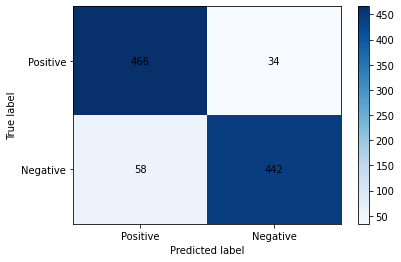

Test loss: 0.015389734208583831 
 Test accuracy: 90.8
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.009530441017614471 
 Training accuracy: 87.46666666666667
Test loss: 0.008849058836698532 
 Test accuracy: 88.9
------------------------------------------------------------------
epoch 1:
Training loss: 0.003991074534236557 
 Training accuracy: 95.62222222222222
Test loss: 0.009053053949028254 
 Test accuracy: 90.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.0014869018430148976 
 Training accuracy: 98.55555555555556
Test loss: 0.011057486657053233 
 Test accuracy: 89.9
------------------------------------------------------------------
epoch 3:
Training loss: 0.0007404331112920772 
 Training accuracy: 99.26666666666667
Test loss: 0.012399125237483532 
 Test accuracy: 90.8
------------------------------------------------------------------
epoch 4:
Training loss: 0.00037841199638367266 

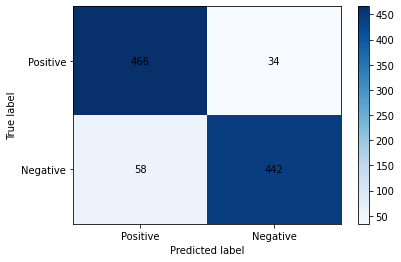

Test loss: 0.014265902236511465 
 Test accuracy: 90.8
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.009593681243972646 
 Training accuracy: 87.22222222222223
Test loss: 0.006855761129409075 
 Test accuracy: 93.2
------------------------------------------------------------------
epoch 1:
Training loss: 0.004215063229720626 
 Training accuracy: 95.35555555555555
Test loss: 0.011130862161517143 
 Test accuracy: 92.80000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.0019527021477050664 
 Training accuracy: 97.86666666666667
Test loss: 0.006330777045339346 
 Test accuracy: 92.80000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0007926793111837469 
 Training accuracy: 99.3
Test loss: 0.010551642678678036 
 Test accuracy: 92.7
------------------------------------------------------------------
epoch 4:
Training loss: 0.00033334

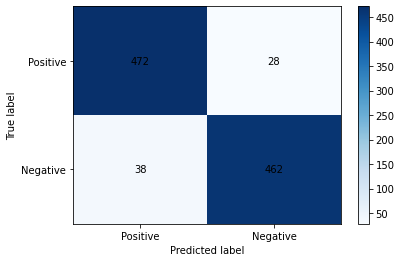

Test loss: 0.017868914932245388 
 Test accuracy: 93.4
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.009567883563124472 
 Training accuracy: 87.02222222222223
Test loss: 0.009160271305590868 
 Test accuracy: 89.2
------------------------------------------------------------------
epoch 1:
Training loss: 0.0041492075457548105 
 Training accuracy: 95.36666666666666
Test loss: 0.007141793442890048 
 Test accuracy: 91.2
------------------------------------------------------------------
epoch 2:
Training loss: 0.0017598055737002545 
 Training accuracy: 98.2
Test loss: 0.009799131028354167 
 Test accuracy: 91.4
------------------------------------------------------------------
epoch 3:
Training loss: 0.0007531221804836402 
 Training accuracy: 99.24444444444444
Test loss: 0.010107255874201655 
 Test accuracy: 90.60000000000001
------------------------------------------------------------------
epoch 4:
Training loss: 0.00035626949567166673

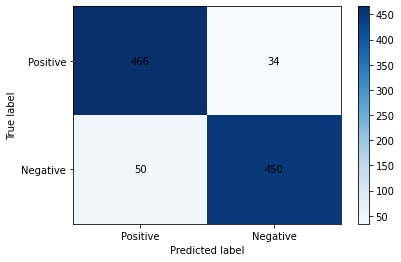

Test loss: 0.013213151231524535 
 Test accuracy: 91.60000000000001
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.01003281389342414 
 Training accuracy: 86.66666666666667
Test loss: 0.008481364157050848 
 Test accuracy: 91.4
------------------------------------------------------------------
epoch 1:
Training loss: 0.004175224882240097 
 Training accuracy: 95.36666666666666
Test loss: 0.008448097775690257 
 Test accuracy: 91.2
------------------------------------------------------------------
epoch 2:
Training loss: 0.0018873169259426908 
 Training accuracy: 98.07777777777777
Test loss: 0.012677354648709296 
 Test accuracy: 90.60000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0006731900833029713 
 Training accuracy: 99.28888888888889
Test loss: 0.011140203530085274 
 Test accuracy: 91.2
------------------------------------------------------------------
epoch 4:
Training loss

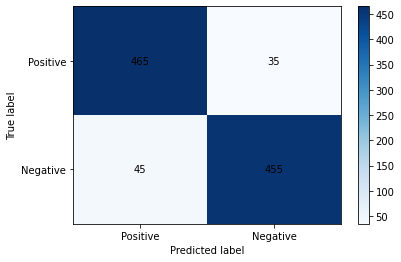

Test loss: 0.01388784035720164 
 Test accuracy: 92.0
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.009347112541397412 
 Training accuracy: 87.74444444444444
Test loss: 0.009301243141293526 
 Test accuracy: 89.8
------------------------------------------------------------------
epoch 1:
Training loss: 0.0038638182484751773 
 Training accuracy: 95.85555555555555
Test loss: 0.007867682377807796 
 Test accuracy: 91.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.0017886354196557982 
 Training accuracy: 98.14444444444445
Test loss: 0.012286290856078267 
 Test accuracy: 89.7
------------------------------------------------------------------
epoch 3:
Training loss: 0.000867726234036834 
 Training accuracy: 99.14444444444445
Test loss: 0.01192200687318109 
 Test accuracy: 92.80000000000001
------------------------------------------------------------------
epoch 4:
Training loss: 0.0003025178

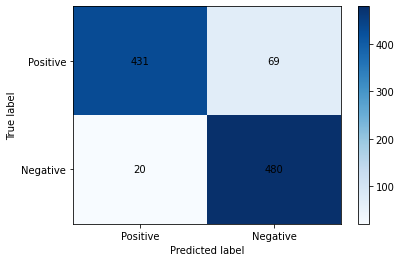

Test loss: 0.01916883126227185 
 Test accuracy: 91.10000000000001
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.010253205573393239 
 Training accuracy: 85.82222222222222
Test loss: 0.007100255195051431 
 Test accuracy: 91.8
------------------------------------------------------------------
epoch 1:
Training loss: 0.004228821380063892 
 Training accuracy: 95.13333333333334
Test loss: 0.006698247749358416 
 Test accuracy: 92.10000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.0018544405981277426 
 Training accuracy: 98.24444444444444
Test loss: 0.009823113804683089 
 Test accuracy: 91.7
------------------------------------------------------------------
epoch 3:
Training loss: 0.0006513376789840145 
 Training accuracy: 99.37777777777778
Test loss: 0.011733632636256515 
 Test accuracy: 91.8
------------------------------------------------------------------
epoch 4:
Training loss

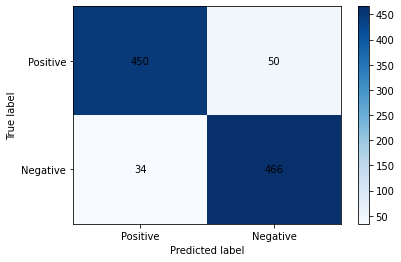

Test loss: 0.0127328199331605 
 Test accuracy: 91.60000000000001
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.009588255229923461 
 Training accuracy: 87.52222222222223
Test loss: 0.009518683575093747 
 Test accuracy: 89.60000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.0039207413759496474 
 Training accuracy: 95.67777777777778
Test loss: 0.009390410959720612 
 Test accuracy: 91.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.0015993900924869296 
 Training accuracy: 98.37777777777778
Test loss: 0.0102220961432904 
 Test accuracy: 92.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0008493082588797228 
 Training accuracy: 99.2
Test loss: 0.011378194486896974 
 Test accuracy: 92.2
------------------------------------------------------------------
epoch 4:
Training loss: 0.00027879291

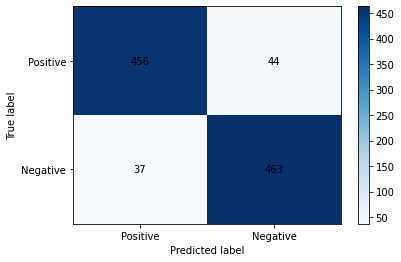

Test loss: 0.014800270693609492 
 Test accuracy: 91.9
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.009410141135669417 
 Training accuracy: 87.94444444444444
Test loss: 0.00668999246135354 
 Test accuracy: 92.10000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.004294617446760337 
 Training accuracy: 95.1
Test loss: 0.007903525481000543 
 Test accuracy: 91.2
------------------------------------------------------------------
epoch 2:
Training loss: 0.0016695922897197305 
 Training accuracy: 98.34444444444445
Test loss: 0.008165395520627498 
 Test accuracy: 92.30000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0005471286802074044 
 Training accuracy: 99.41111111111111
Test loss: 0.012421493468806147 
 Test accuracy: 91.7
------------------------------------------------------------------
epoch 4:
Training loss: 0.000319759

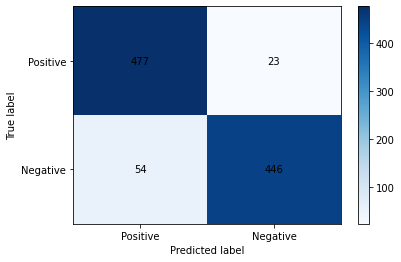

Test loss: 0.01289670412428677 
 Test accuracy: 92.30000000000001
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.009395776635656754 
 Training accuracy: 87.7
Test loss: 0.010774899661540984 
 Test accuracy: 89.3
------------------------------------------------------------------
epoch 1:
Training loss: 0.0039994757273234425 
 Training accuracy: 95.97777777777777
Test loss: 0.00998929063603282 
 Test accuracy: 90.8
------------------------------------------------------------------
epoch 2:
Training loss: 0.001778422209893405 
 Training accuracy: 98.37777777777778
Test loss: 0.01074279769603163 
 Test accuracy: 92.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.000692617161393476 
 Training accuracy: 99.3888888888889
Test loss: 0.01494309632043587 
 Test accuracy: 89.3
------------------------------------------------------------------
epoch 4:
Training loss: 0.0004945452057290822 
 Train

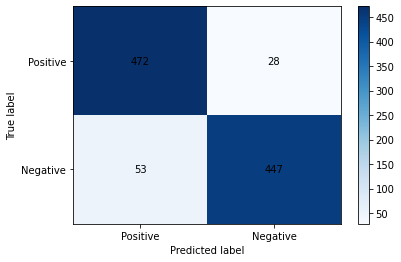

Test loss: 0.012150112940813414 
 Test accuracy: 91.9
------------------------------------------------------------------
Folds statistics:
----------------
 - mean: 91.74 
 - standard deviation: 0.7351190379795663


In [ ]:
mean, std = main_cross_validation(main_LSTM, subj_dataset, subj_embedding_matrix, collate, epochs = 5, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

### BiLSTM with attention


 Fold: 0
epoch 0:
Training loss: 0.00868037498369813 
 Training accuracy: 88.45555555555555
Test loss: 0.006815065331757068 
 Test accuracy: 91.3
------------------------------------------------------------------
epoch 1:
Training loss: 0.0031967946391345727 
 Training accuracy: 96.31111111111112
Test loss: 0.007399762149900198 
 Test accuracy: 91.7
------------------------------------------------------------------
epoch 2:
Training loss: 0.00131256226555302 
 Training accuracy: 98.6888888888889
Test loss: 0.010506322706583887 
 Test accuracy: 90.7
------------------------------------------------------------------
epoch 3:
Training loss: 0.0004715846103717922 
 Training accuracy: 99.52222222222223
Test loss: 0.012069592505227775 
 Test accuracy: 91.8
------------------------------------------------------------------
epoch 4:
Training loss: 0.00019883438504062826 
 Training accuracy: 99.85555555555555


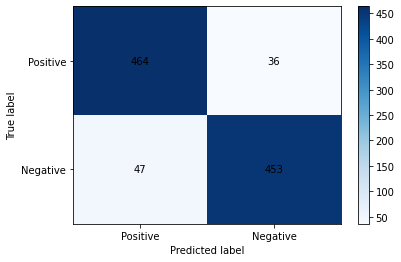

Test loss: 0.01771343046519905 
 Test accuracy: 91.7
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.008522283072790338 
 Training accuracy: 88.36666666666667
Test loss: 0.007088980965316296 
 Test accuracy: 91.7
------------------------------------------------------------------
epoch 1:
Training loss: 0.003069527520513576 
 Training accuracy: 96.76666666666667
Test loss: 0.006957321956753731 
 Test accuracy: 92.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.0011292666709018199 
 Training accuracy: 99.02222222222223
Test loss: 0.010066439625341445 
 Test accuracy: 92.4
------------------------------------------------------------------
epoch 3:
Training loss: 0.0005093931200939955 
 Training accuracy: 99.6
Test loss: 0.011187070617452263 
 Test accuracy: 92.30000000000001
------------------------------------------------------------------
epoch 4:
Training loss: 0.0001884691210840275 
 

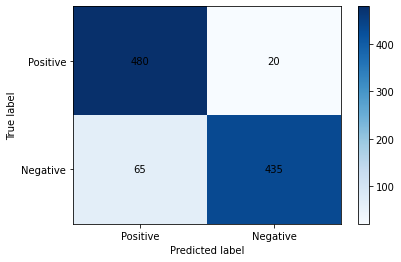

Test loss: 0.018944135728175753 
 Test accuracy: 91.5
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.008692571404907439 
 Training accuracy: 88.52222222222223
Test loss: 0.005706515757367015 
 Test accuracy: 93.60000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.0033280230754365522 
 Training accuracy: 96.43333333333334
Test loss: 0.005259662293829024 
 Test accuracy: 94.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.001284039346824607 
 Training accuracy: 98.72222222222223
Test loss: 0.006073325830511749 
 Test accuracy: 93.89999999999999
------------------------------------------------------------------
epoch 3:
Training loss: 0.0004043773657956788 
 Training accuracy: 99.56666666666666
Test loss: 0.009709998720092698 
 Test accuracy: 93.89999999999999
------------------------------------------------------------------
epoch 4:

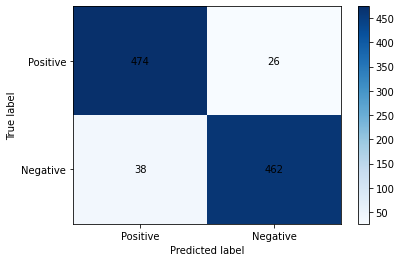

Test loss: 0.011823144137626513 
 Test accuracy: 93.60000000000001
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.008986647056622638 
 Training accuracy: 88.42222222222222
Test loss: 0.005854319665580988 
 Test accuracy: 91.8
------------------------------------------------------------------
epoch 1:
Training loss: 0.0033083981856082876 
 Training accuracy: 96.33333333333334
Test loss: 0.005786410458385944 
 Test accuracy: 93.4
------------------------------------------------------------------
epoch 2:
Training loss: 0.001163168168044649 
 Training accuracy: 98.78888888888889
Test loss: 0.008754100783844478 
 Test accuracy: 92.60000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0004177862543050045 
 Training accuracy: 99.66666666666667
Test loss: 0.009377506218850612 
 Test accuracy: 92.10000000000001
------------------------------------------------------------------
epoch 4:

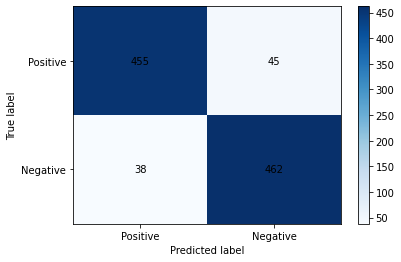

Test loss: 0.013633413799936534 
 Test accuracy: 91.7
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.00859926657171713 
 Training accuracy: 88.87777777777778
Test loss: 0.0067481063492596145 
 Test accuracy: 91.7
------------------------------------------------------------------
epoch 1:
Training loss: 0.0034458403109262387 
 Training accuracy: 96.03333333333333
Test loss: 0.005925871651619672 
 Test accuracy: 92.30000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.0011906789842048764 
 Training accuracy: 98.85555555555555
Test loss: 0.007528574148193002 
 Test accuracy: 91.4
------------------------------------------------------------------
epoch 3:
Training loss: 0.00037458423584474886 
 Training accuracy: 99.73333333333333
Test loss: 0.015416330284555442 
 Test accuracy: 90.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.000139

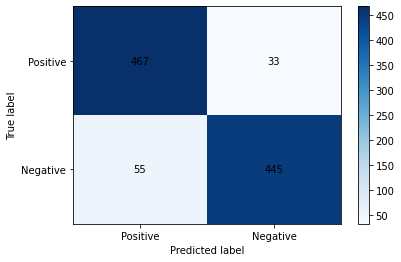

Test loss: 0.020722521723626413 
 Test accuracy: 91.2
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.008930668094505866 
 Training accuracy: 88.6
Test loss: 0.006740253381431103 
 Test accuracy: 91.60000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.0034039463533295524 
 Training accuracy: 96.32222222222222
Test loss: 0.007455103810876608 
 Test accuracy: 91.60000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.0014386420739853445 
 Training accuracy: 98.63333333333333
Test loss: 0.008028147974982858 
 Test accuracy: 92.7
------------------------------------------------------------------
epoch 3:
Training loss: 0.0005778815768233269 
 Training accuracy: 99.45555555555555
Test loss: 0.009409600020386278 
 Test accuracy: 92.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0002162

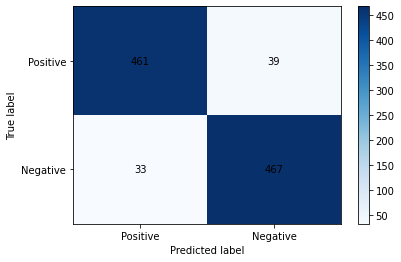

Test loss: 0.014003064313088544 
 Test accuracy: 92.80000000000001
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.008423649687526954 
 Training accuracy: 89.17777777777778
Test loss: 0.008877596504986287 
 Test accuracy: 87.6
------------------------------------------------------------------
epoch 1:
Training loss: 0.003243041399245461 
 Training accuracy: 96.46666666666667
Test loss: 0.006839877817779779 
 Test accuracy: 91.7
------------------------------------------------------------------
epoch 2:
Training loss: 0.0013011356261041428 
 Training accuracy: 98.61111111111111
Test loss: 0.009502090595662593 
 Test accuracy: 91.60000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.00040862305228493923 
 Training accuracy: 99.6111111111111
Test loss: 0.01267077983179479 
 Test accuracy: 92.2
------------------------------------------------------------------
epoch 4:
Training loss

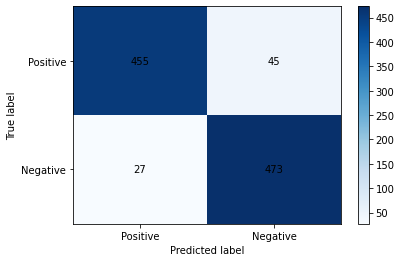

Test loss: 0.013588344159303233 
 Test accuracy: 92.80000000000001
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.008879831291735172 
 Training accuracy: 88.21111111111111
Test loss: 0.00659988271445036 
 Test accuracy: 90.3
------------------------------------------------------------------
epoch 1:
Training loss: 0.0035070366340999803 
 Training accuracy: 96.02222222222223
Test loss: 0.006619408294558525 
 Test accuracy: 92.7
------------------------------------------------------------------
epoch 2:
Training loss: 0.0013274069647401727 
 Training accuracy: 98.71111111111112
Test loss: 0.008010718245524913 
 Test accuracy: 92.7
------------------------------------------------------------------
epoch 3:
Training loss: 0.0004048749083109821 
 Training accuracy: 99.64444444444445
Test loss: 0.010962037933524698 
 Test accuracy: 92.80000000000001
------------------------------------------------------------------
epoch 4:
Training los

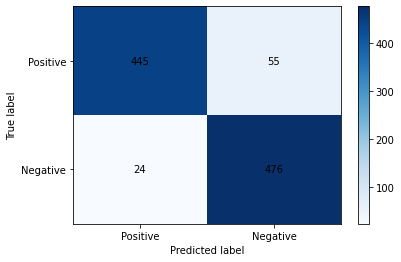

Test loss: 0.01572113704122603 
 Test accuracy: 92.10000000000001
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.009354116968810559 
 Training accuracy: 87.22222222222223
Test loss: 0.0064936504028737544 
 Test accuracy: 92.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.0034824154836436113 
 Training accuracy: 96.24444444444444
Test loss: 0.005802397876977921 
 Test accuracy: 93.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.0012509379562236265 
 Training accuracy: 98.85555555555555
Test loss: 0.007158438658807427 
 Test accuracy: 92.7
------------------------------------------------------------------
epoch 3:
Training loss: 0.0004690441672686979 
 Training accuracy: 99.6111111111111
Test loss: 0.01139857211150229 
 Test accuracy: 92.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.000138507

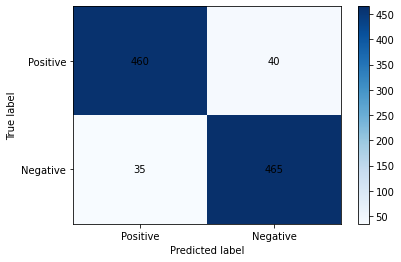

Test loss: 0.012509715407764362 
 Test accuracy: 92.5
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.008502695161021418 
 Training accuracy: 89.11111111111111
Test loss: 0.00653609211370349 
 Test accuracy: 91.9
------------------------------------------------------------------
epoch 1:
Training loss: 0.0031965042921817963 
 Training accuracy: 96.33333333333334
Test loss: 0.005997182360850274 
 Test accuracy: 92.60000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.001245859515115929 
 Training accuracy: 98.93333333333332
Test loss: 0.006354421293362975 
 Test accuracy: 93.30000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0004506889006289485 
 Training accuracy: 99.6111111111111
Test loss: 0.010600859214413503 
 Test accuracy: 92.4
------------------------------------------------------------------
epoch 4:
Training loss:

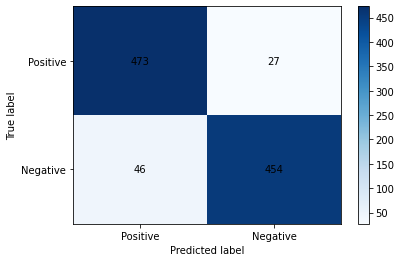

Test loss: 0.013996614473580849 
 Test accuracy: 92.7
------------------------------------------------------------------
Folds statistics:
----------------
 - mean: 92.25000000000001 
 - standard deviation: 0.6741661516273306


In [ ]:
mean, std = main_cross_validation(main, subj_dataset, subj_embedding_matrix, collate, epochs = 5, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

## Deep Models (GloVe embedding)
### BiLSTM


 Fold: 0
epoch 0:
Training loss: 0.009906491987407208 
 Training accuracy: 86.6888888888889
Test loss: 0.007404463984072208 
 Test accuracy: 90.9
------------------------------------------------------------------
epoch 1:
Training loss: 0.004144640890415758 
 Training accuracy: 95.56666666666666
Test loss: 0.01661488552764058 
 Test accuracy: 88.4
------------------------------------------------------------------
epoch 2:
Training loss: 0.0016519675968189 
 Training accuracy: 98.35555555555555
Test loss: 0.01323704385664314 
 Test accuracy: 91.4
------------------------------------------------------------------
epoch 3:
Training loss: 0.0007127081182293801 
 Training accuracy: 99.3888888888889
Test loss: 0.01247274135518819 
 Test accuracy: 91.60000000000001
------------------------------------------------------------------
epoch 4:
Training loss: 0.0002676743137643724 
 Training accuracy: 99.75555555555556


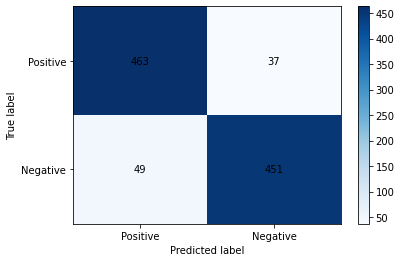

Test loss: 0.014469004236496403 
 Test accuracy: 91.4
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.009499338981591993 
 Training accuracy: 87.08888888888889
Test loss: 0.009887480139732362 
 Test accuracy: 87.6
------------------------------------------------------------------
epoch 1:
Training loss: 0.003925193229793674 
 Training accuracy: 95.74444444444444
Test loss: 0.00907455044798553 
 Test accuracy: 90.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.001634335596411903 
 Training accuracy: 98.4
Test loss: 0.010446864683181047 
 Test accuracy: 91.2
------------------------------------------------------------------
epoch 3:
Training loss: 0.0006989914360714869 
 Training accuracy: 99.3111111111111
Test loss: 0.012383554600179196 
 Test accuracy: 90.8
------------------------------------------------------------------
epoch 4:
Training loss: 0.00030870132289419417 
 Training accur

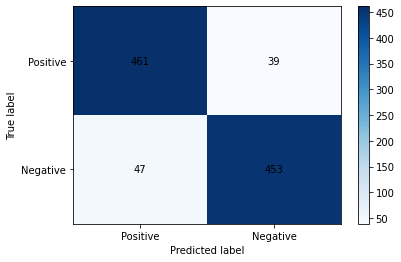

Test loss: 0.014910861603682862 
 Test accuracy: 91.4
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.009626754369172786 
 Training accuracy: 87.28888888888889
Test loss: 0.007956477239727974 
 Test accuracy: 90.8
------------------------------------------------------------------
epoch 1:
Training loss: 0.004144147060759779 
 Training accuracy: 95.42222222222222
Test loss: 0.0066765356604009864 
 Test accuracy: 92.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.0017678177931035558 
 Training accuracy: 98.28888888888889
Test loss: 0.009227955016773193 
 Test accuracy: 92.10000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0007488674134947359 
 Training accuracy: 99.27777777777777
Test loss: 0.01000131875788793 
 Test accuracy: 92.4
------------------------------------------------------------------
epoch 4:
Training loss: 0.00028168

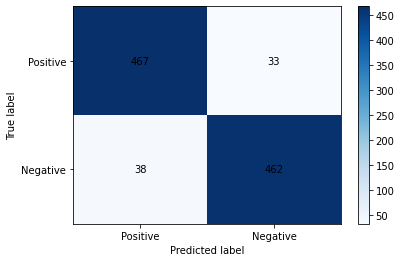

Test loss: 0.011254786916659213 
 Test accuracy: 92.9
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.009704880502902798 
 Training accuracy: 86.78888888888889
Test loss: 0.008087517213076352 
 Test accuracy: 91.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.004037719887370865 
 Training accuracy: 95.6
Test loss: 0.010768794432282448 
 Test accuracy: 87.8
------------------------------------------------------------------
epoch 2:
Training loss: 0.0018203844024748024 
 Training accuracy: 98.3
Test loss: 0.007938999593257903 
 Test accuracy: 92.10000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0005995537413044885 
 Training accuracy: 99.42222222222222
Test loss: 0.010850065637379884 
 Test accuracy: 91.4
------------------------------------------------------------------
epoch 4:
Training loss: 0.0003014894581574481 
 Training acc

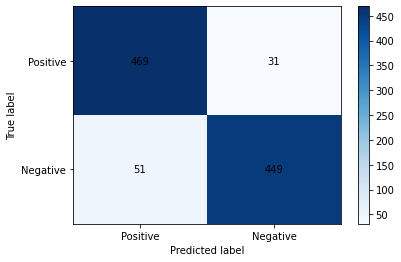

Test loss: 0.013732665145886131 
 Test accuracy: 91.8
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.009863078644292223 
 Training accuracy: 86.4
Test loss: 0.022293310543522238 
 Test accuracy: 82.89999999999999
------------------------------------------------------------------
epoch 1:
Training loss: 0.004305247782419125 
 Training accuracy: 95.13333333333334
Test loss: 0.012399994696490467 
 Test accuracy: 91.3
------------------------------------------------------------------
epoch 2:
Training loss: 0.001571682895313845 
 Training accuracy: 98.35555555555555
Test loss: 0.012580410871654749 
 Test accuracy: 91.60000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0008000721861931702 
 Training accuracy: 99.27777777777777
Test loss: 0.01591577942413278 
 Test accuracy: 90.3
------------------------------------------------------------------
epoch 4:
Training loss: 0.0002720554

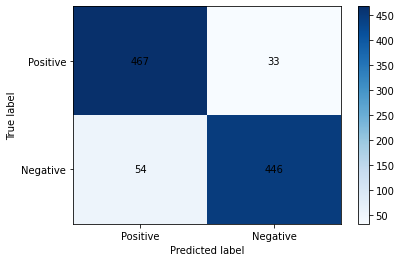

Test loss: 0.02022844038961921 
 Test accuracy: 91.3
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.00992957346058554 
 Training accuracy: 86.35555555555555
Test loss: 0.007264862880110741 
 Test accuracy: 90.7
------------------------------------------------------------------
epoch 1:
Training loss: 0.004038202903026508 
 Training accuracy: 95.35555555555555
Test loss: 0.0110435723811388 
 Test accuracy: 90.3
------------------------------------------------------------------
epoch 2:
Training loss: 0.0016612777438454536 
 Training accuracy: 98.32222222222222
Test loss: 0.01240349480509758 
 Test accuracy: 89.7
------------------------------------------------------------------
epoch 3:
Training loss: 0.0007160911928319062 
 Training accuracy: 99.4
Test loss: 0.01395204127766192 
 Test accuracy: 91.2
------------------------------------------------------------------
epoch 4:
Training loss: 0.00026955153899325523 
 Training accuracy

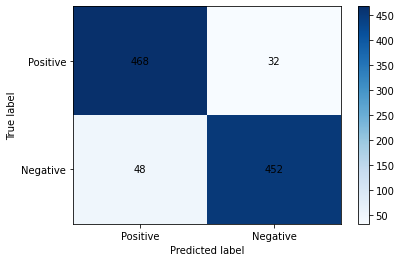

Test loss: 0.015602346993982791 
 Test accuracy: 92.0
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.009268606811761856 
 Training accuracy: 87.6
Test loss: 0.006180673142895102 
 Test accuracy: 92.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.003907806357368827 
 Training accuracy: 95.58888888888889
Test loss: 0.006553949560970068 
 Test accuracy: 91.9
------------------------------------------------------------------
epoch 2:
Training loss: 0.0016777129341046223 
 Training accuracy: 98.24444444444444
Test loss: 0.008374952150508761 
 Test accuracy: 92.7
------------------------------------------------------------------
epoch 3:
Training loss: 0.0007063509636079996 
 Training accuracy: 99.27777777777777
Test loss: 0.011461944295093417 
 Test accuracy: 92.7
------------------------------------------------------------------
epoch 4:
Training loss: 0.00030226142874178346 
 Training ac

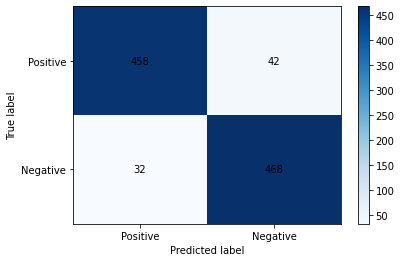

Test loss: 0.010850672267297341 
 Test accuracy: 92.60000000000001
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.009167367789480421 
 Training accuracy: 88.1888888888889
Test loss: 0.009027852062135935 
 Test accuracy: 90.3
------------------------------------------------------------------
epoch 1:
Training loss: 0.004227643249763382 
 Training accuracy: 95.5
Test loss: 0.007797346527688205 
 Test accuracy: 91.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.0018174175365000135 
 Training accuracy: 98.23333333333333
Test loss: 0.01379996005166322 
 Test accuracy: 91.4
------------------------------------------------------------------
epoch 3:
Training loss: 0.0008654392626421113 
 Training accuracy: 99.28888888888889
Test loss: 0.014042069173417986 
 Test accuracy: 90.60000000000001
------------------------------------------------------------------
epoch 4:
Training loss: 0.0003898423

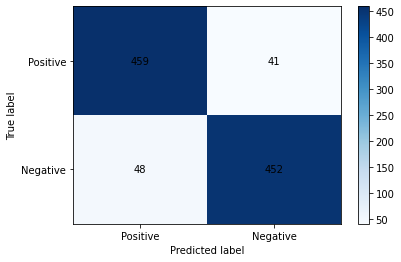

Test loss: 0.015042226545512676 
 Test accuracy: 91.10000000000001
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.009601593809409274 
 Training accuracy: 87.2
Test loss: 0.010267371773719787 
 Test accuracy: 88.2
------------------------------------------------------------------
epoch 1:
Training loss: 0.004070406128134993 
 Training accuracy: 95.16666666666667
Test loss: 0.008025689211674035 
 Test accuracy: 91.60000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.0016461650953990305 
 Training accuracy: 98.32222222222222
Test loss: 0.009752455700188876 
 Test accuracy: 90.8
------------------------------------------------------------------
epoch 3:
Training loss: 0.0005842716786590042 
 Training accuracy: 99.5
Test loss: 0.01249312373623252 
 Test accuracy: 91.10000000000001
------------------------------------------------------------------
epoch 4:
Training loss: 0.000253724

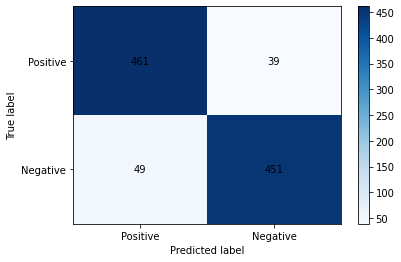

Test loss: 0.013710829529911279 
 Test accuracy: 91.2
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.009632694344553683 
 Training accuracy: 87.65555555555555
Test loss: 0.011646660342812538 
 Test accuracy: 91.3
------------------------------------------------------------------
epoch 1:
Training loss: 0.004139290008383493 
 Training accuracy: 95.38888888888889
Test loss: 0.016250908695161343 
 Test accuracy: 90.8
------------------------------------------------------------------
epoch 2:
Training loss: 0.0016690606674852058 
 Training accuracy: 98.41111111111111
Test loss: 0.016505251420661806 
 Test accuracy: 92.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0006515512254490104 
 Training accuracy: 99.36666666666667
Test loss: 0.02045536908763461 
 Test accuracy: 92.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.00021195343072112236 


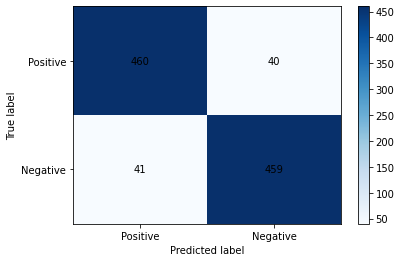

Test loss: 0.017673670882359147 
 Test accuracy: 91.9
------------------------------------------------------------------
Folds statistics:
----------------
 - mean: 91.76 
 - standard deviation: 0.5748043145279973


In [ ]:
subj_embedding_matrix = subj_corpus.get_embedding_matrix(global_vectors, 300)
mean, std = main_cross_validation(main_LSTM, subj_dataset, subj_embedding_matrix, collate, epochs = 5, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

### BiLSTM with attention


 Fold: 0
epoch 0:
Training loss: 0.0085348917434199 
 Training accuracy: 89.0
Test loss: 0.006643893208354712 
 Test accuracy: 91.60000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.0034092163789706926 
 Training accuracy: 96.23333333333333
Test loss: 0.006296303621027619 
 Test accuracy: 92.4
------------------------------------------------------------------
epoch 2:
Training loss: 0.00123872332717292 
 Training accuracy: 98.77777777777777
Test loss: 0.010249005897308962 
 Test accuracy: 92.10000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0004326076127153 
 Training accuracy: 99.62222222222222
Test loss: 0.011802205212879925 
 Test accuracy: 92.10000000000001
------------------------------------------------------------------
epoch 4:
Training loss: 0.00016359408147016236 
 Training accuracy: 99.86666666666667


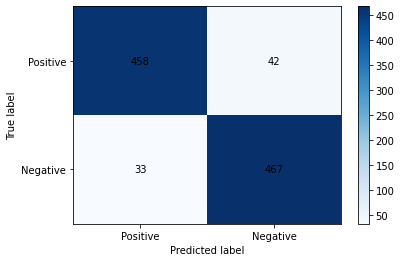

Test loss: 0.014460391186992638 
 Test accuracy: 92.5
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.008857772063050004 
 Training accuracy: 88.13333333333333
Test loss: 0.008127609506249427 
 Test accuracy: 91.60000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.0034385364683758883 
 Training accuracy: 96.12222222222222
Test loss: 0.008259749619290232 
 Test accuracy: 92.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.0012734154821114822 
 Training accuracy: 98.78888888888889
Test loss: 0.009852579286321998 
 Test accuracy: 90.8
------------------------------------------------------------------
epoch 3:
Training loss: 0.0005013786438208727 
 Training accuracy: 99.57777777777778
Test loss: 0.01278318419756033 
 Test accuracy: 90.2
------------------------------------------------------------------
epoch 4:
Training loss: 0.00020061

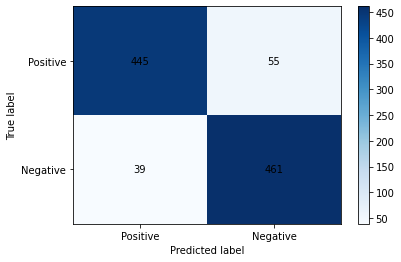

Test loss: 0.018086026709759607 
 Test accuracy: 90.60000000000001
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.008787705763346618 
 Training accuracy: 88.71111111111111
Test loss: 0.006262081857770682 
 Test accuracy: 93.10000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.0034262649035598667 
 Training accuracy: 96.25555555555556
Test loss: 0.0059368575848639015 
 Test accuracy: 93.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.0012276997587630629 
 Training accuracy: 98.74444444444444
Test loss: 0.006731112956127617 
 Test accuracy: 93.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0003838467121927857 
 Training accuracy: 99.65555555555555
Test loss: 0.008313630254124292 
 Test accuracy: 93.5
------------------------------------------------------------------
epoch 4:
Training l

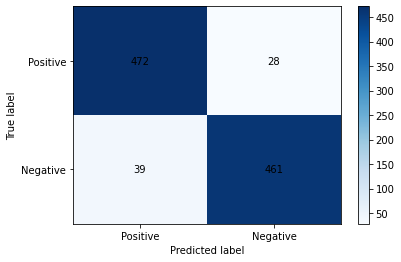

Test loss: 0.010292451266424906 
 Test accuracy: 93.30000000000001
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.008937228215237458 
 Training accuracy: 88.56666666666668
Test loss: 0.005807198405265808 
 Test accuracy: 93.10000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.003436687518790778 
 Training accuracy: 96.16666666666667
Test loss: 0.005208408735692501 
 Test accuracy: 93.60000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.00124706400567407 
 Training accuracy: 98.66666666666667
Test loss: 0.006658315622247756 
 Test accuracy: 93.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.00041429935595806454 
 Training accuracy: 99.62222222222222
Test loss: 0.009645832274341955 
 Test accuracy: 93.0
------------------------------------------------------------------
epoch 4:


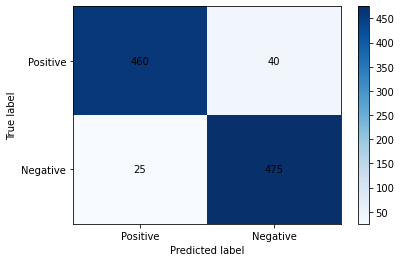

Test loss: 0.01081151159471483 
 Test accuracy: 93.5
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.009010906057225333 
 Training accuracy: 88.21111111111111
Test loss: 0.006101882236078381 
 Test accuracy: 93.30000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.003324802856737127 
 Training accuracy: 96.24444444444444
Test loss: 0.007936640763655306 
 Test accuracy: 92.4
------------------------------------------------------------------
epoch 2:
Training loss: 0.0012037041796849938 
 Training accuracy: 98.66666666666667
Test loss: 0.007649528246372938 
 Test accuracy: 92.60000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.00040768383596271934 
 Training accuracy: 99.6111111111111
Test loss: 0.0183410917702131 
 Test accuracy: 90.2
------------------------------------------------------------------
epoch 4:
Training loss: 

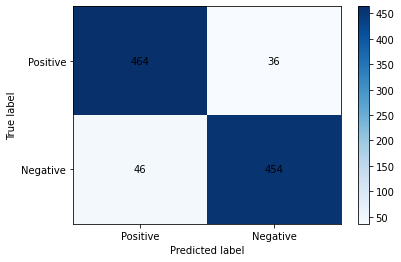

Test loss: 0.017852090485394 
 Test accuracy: 91.8
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.008532341139184104 
 Training accuracy: 88.66666666666667
Test loss: 0.006840821616351605 
 Test accuracy: 92.30000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.003182261438367681 
 Training accuracy: 96.43333333333334
Test loss: 0.0064389555454254154 
 Test accuracy: 91.7
------------------------------------------------------------------
epoch 2:
Training loss: 0.0010758231093317995 
 Training accuracy: 98.96666666666667
Test loss: 0.010655256006051786 
 Test accuracy: 92.2
------------------------------------------------------------------
epoch 3:
Training loss: 0.0003520042831138805 
 Training accuracy: 99.6888888888889
Test loss: 0.013986037489958107 
 Test accuracy: 92.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.00013625667

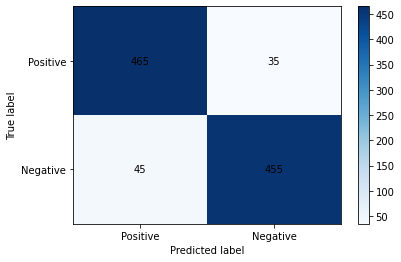

Test loss: 0.015695001293264794 
 Test accuracy: 92.0
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.008749968045287663 
 Training accuracy: 88.0111111111111
Test loss: 0.007781140819191933 
 Test accuracy: 89.4
------------------------------------------------------------------
epoch 1:
Training loss: 0.003402399447850055 
 Training accuracy: 96.2
Test loss: 0.006262911403551698 
 Test accuracy: 93.2
------------------------------------------------------------------
epoch 2:
Training loss: 0.001185110291023092 
 Training accuracy: 98.76666666666667
Test loss: 0.009675291629508137 
 Test accuracy: 91.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0004224816716854952 
 Training accuracy: 99.56666666666666
Test loss: 0.010699454330839216 
 Test accuracy: 92.2
------------------------------------------------------------------
epoch 4:
Training loss: 7.944124579267332e-05 
 Training accur

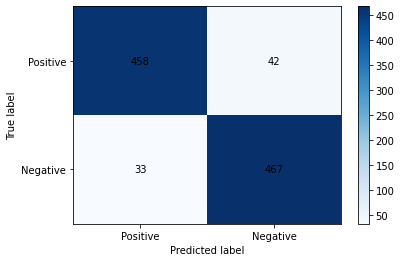

Test loss: 0.01611671015105094 
 Test accuracy: 92.5
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.008416196105794775 
 Training accuracy: 88.64444444444445
Test loss: 0.005732834584312513 
 Test accuracy: 92.10000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.0032089400138292047 
 Training accuracy: 96.58888888888889
Test loss: 0.007283492706716061 
 Test accuracy: 91.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.001226292205942122 
 Training accuracy: 98.7
Test loss: 0.011815751165151597 
 Test accuracy: 92.30000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.00038881745954939915 
 Training accuracy: 99.64444444444445
Test loss: 0.012549444970965851 
 Test accuracy: 93.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.00010511

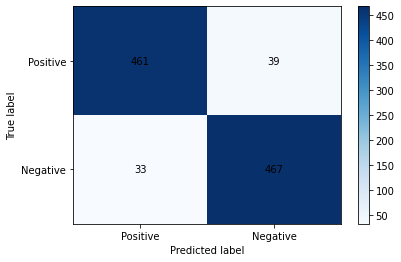

Test loss: 0.015159165002871304 
 Test accuracy: 92.80000000000001
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.008962914583583673 
 Training accuracy: 88.23333333333333
Test loss: 0.006627357915043831 
 Test accuracy: 91.4
------------------------------------------------------------------
epoch 1:
Training loss: 0.0034522752944483527 
 Training accuracy: 96.1
Test loss: 0.005581611508503556 
 Test accuracy: 92.60000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.0014331882226267933 
 Training accuracy: 98.5
Test loss: 0.00782627074510674 
 Test accuracy: 92.80000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.00042195357653852426 
 Training accuracy: 99.53333333333333
Test loss: 0.00990907860174775 
 Test accuracy: 92.7
------------------------------------------------------------------
epoch 4:
Training loss: 9.84588961

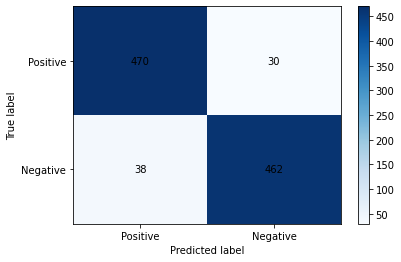

Test loss: 0.013370798427145928 
 Test accuracy: 93.2
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.009015694267633888 
 Training accuracy: 87.55555555555556
Test loss: 0.007200031481683254 
 Test accuracy: 91.3
------------------------------------------------------------------
epoch 1:
Training loss: 0.0033032922536755604 
 Training accuracy: 96.23333333333333
Test loss: 0.007017482006922364 
 Test accuracy: 92.4
------------------------------------------------------------------
epoch 2:
Training loss: 0.001219362956918 
 Training accuracy: 98.85555555555555
Test loss: 0.009902812940708827 
 Test accuracy: 91.9
------------------------------------------------------------------
epoch 3:
Training loss: 0.0004783969207605373 
 Training accuracy: 99.57777777777778
Test loss: 0.012452472664415836 
 Test accuracy: 91.60000000000001
------------------------------------------------------------------
epoch 4:
Training loss: 0.00016782654

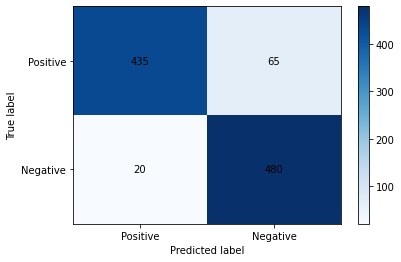

Test loss: 0.016636493337340654 
 Test accuracy: 91.5
------------------------------------------------------------------
Folds statistics:
----------------
 - mean: 92.4 
 - standard deviation: 0.7899367063252609


In [ ]:
mean, std = main_cross_validation(main, subj_dataset, subj_embedding_matrix, collate, epochs = 5, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

# Polarity Tests
## Shallow baseline

In [ ]:
# Taking the best estimator in accuracy from Subjectivity detection with Naive Bayes
pred = scores["estimator"][scores["test_accuracy"].argmax()]

In [ ]:
def remove_objective_sents(vectorizer, estimator, corpus):
  transformed_corpus = [[vectorizer.transform([neg_marking_list2str(sent)]) for sent in doc] for doc in corpus]
  res = [[corpus[doc_idx][sent_idx] for sent_idx, sent in enumerate(doc) if estimator.predict(sent).item()]
          for doc_idx, doc in enumerate(transformed_corpus)]
  return res

In [ ]:
def neg_marking_pol(doc):
  # takes the doc and produces a single list
  flattened_doc = [w for sent in doc for w in sent]
  # negates the whole document
  negated_doc = mark_negation(flattened_doc, double_neg_flip=True)
  return " ".join([w for w in negated_doc])

In [ ]:
vectorizer = CountVectorizer()
mr = movie_reviews
neg = mr.paras(categories = "neg")
pos = mr.paras(categories = "pos")
mr_corpus = pos + neg

mr_corpus = [neg_marking_pol(d) for d in mr_corpus]
vectors = vectorizer.fit_transform(mr_corpus)
labels = np.array([0] * len(pos) + [1] * len(neg))

In [ ]:
scores = cross_validate(classifier, vectors, labels, cv=StratifiedKFold(n_splits=10) , scoring=['accuracy'], return_estimator=True)
average = sum(scores['test_accuracy'])/len(scores['test_accuracy'])
std = np.std(np.array(scores['test_accuracy']))
print(f"Folds statistics:\n----------------\n - mean: {average*100} \n - standard deviation: {std*100}")

Folds statistics:
----------------
 - mean: 81.64999999999999 
 - standard deviation: 3.0087372766660745


#### Removing Objective sents.

In [ ]:
mr = movie_reviews
neg = mr.paras(categories = "neg")
pos = mr.paras(categories = "pos")
mr_corpus = pos + neg


mr_corpus = remove_objective_sents(subj_vectorizer, pred, mr_corpus)
mr_corpus = [" ".join([w for sent in doc for w in sent]) for doc in mr_corpus]
# mr_corpus = [neg_marking_pol(d) for d in mr_corpus]

In [ ]:
vectors = vectorizer.fit_transform(mr_corpus)

In [ ]:
scores = cross_validate(classifier, vectors, labels, cv=StratifiedKFold(n_splits=10) , scoring=['accuracy'], return_estimator=True)
average = sum(scores['test_accuracy'])/len(scores['test_accuracy'])
std = np.std(np.array(scores['test_accuracy']))
print(f"Folds statistics:\n----------------\n - mean: {average*100} \n - standard deviation: {std*100}")

Folds statistics:
----------------
 - mean: 85.35000000000001 
 - standard deviation: 2.8640006983239377


## Deep Models (FastText Emebdding)
In this section I am going to analyze perfomances of deep models using fast-text embedding

### BiLSTM

In [ ]:
mr_pipeline = Pipeline(UnderscoreRemover(),
                       CharacterRepetitionRemover(),
                       ApostrophesMerger(),
                       ContractionCleaner(),
                       SpecialCharsCleaner()
                      )
mr_corpus = MovieReviewsCorpus(mr_pipeline)
mr_embedding_matrix = mr_corpus.get_embedding_matrix(fast_text, 300)
mr_dataset = MovieReviewsDataset(mr_corpus.get_indexed_corpus())


 Fold: 0
epoch 0:
Training loss: 0.0236596750219663 
 Training accuracy: 55.666666666666664
Test loss: 0.023011723160743715 
 Test accuracy: 55.00000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.017259124683009254 
 Training accuracy: 73.44444444444444
Test loss: 0.04222040116786957 
 Test accuracy: 54.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.011128955218527052 
 Training accuracy: 85.11111111111111
Test loss: 0.028237036764621734 
 Test accuracy: 65.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0070372640921009914 
 Training accuracy: 91.77777777777779
Test loss: 0.0194297394156456 
 Test accuracy: 79.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.003843881107038922 
 Training accuracy: 96.0
Test loss: 0.027759486734867098 
 Test accuracy: 75.0
-----------------------------------

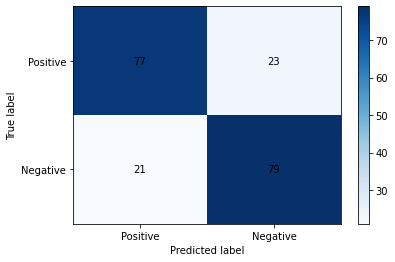

Test loss: 0.0191860893368721 
 Test accuracy: 78.0
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.0233856823709276 
 Training accuracy: 57.277777777777786
Test loss: 0.02533200681209564 
 Test accuracy: 55.50000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.01602786969807413 
 Training accuracy: 76.5
Test loss: 0.023397742509841918 
 Test accuracy: 69.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.008568333114186923 
 Training accuracy: 89.27777777777777
Test loss: 0.02998389393091202 
 Test accuracy: 69.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.004514545138097472 
 Training accuracy: 95.22222222222221
Test loss: 0.03372479796409607 
 Test accuracy: 73.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0022099960719545683 
 Training

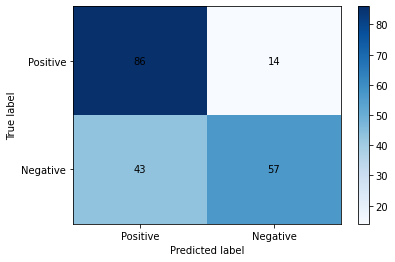

Test loss: 0.042385385185480115 
 Test accuracy: 71.5
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.02381448600027296 
 Training accuracy: 54.11111111111111
Test loss: 0.024011024534702302 
 Test accuracy: 61.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.017126045011811787 
 Training accuracy: 73.94444444444444
Test loss: 0.021778100430965425 
 Test accuracy: 68.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.010591131332847807 
 Training accuracy: 85.83333333333333
Test loss: 0.032591656744480134 
 Test accuracy: 61.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.005318110729050305 
 Training accuracy: 94.05555555555556
Test loss: 0.035053439140319824 
 Test accuracy: 73.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.003316566775449448 
 Tra

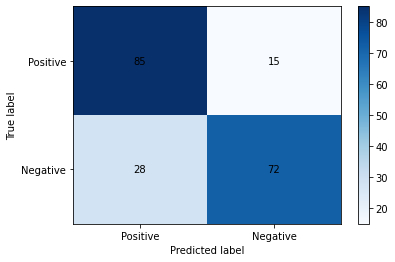

Test loss: 0.03189300671219826 
 Test accuracy: 78.5
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.023712008827262456 
 Training accuracy: 55.44444444444444
Test loss: 0.023606672137975692 
 Test accuracy: 55.00000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.01627254628472858 
 Training accuracy: 76.11111111111111
Test loss: 0.0805856454372406 
 Test accuracy: 48.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.010463276323344973 
 Training accuracy: 86.5
Test loss: 0.026146831214427946 
 Test accuracy: 66.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.005936729452676244 
 Training accuracy: 93.16666666666666
Test loss: 0.02931321144104004 
 Test accuracy: 67.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0030962458459867373 
 Traini

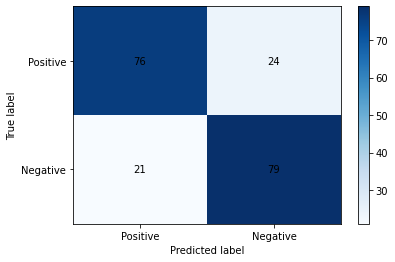

Test loss: 0.03417173892259598 
 Test accuracy: 77.5
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.023351338307062784 
 Training accuracy: 56.00000000000001
Test loss: 0.024025521278381347 
 Test accuracy: 56.99999999999999
------------------------------------------------------------------
epoch 1:
Training loss: 0.01643290869063801 
 Training accuracy: 75.05555555555556
Test loss: 0.039511308670043946 
 Test accuracy: 59.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.01018316790047619 
 Training accuracy: 86.94444444444444
Test loss: 0.022573583126068116 
 Test accuracy: 72.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.005206871276928319 
 Training accuracy: 93.83333333333333
Test loss: 0.02780480682849884 
 Test accuracy: 68.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.00302920894386

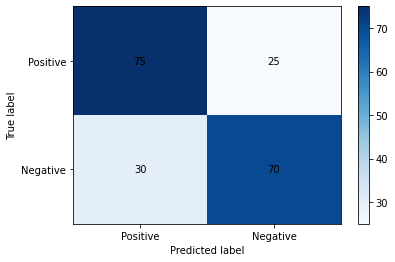

Test loss: 0.03706093549728393 
 Test accuracy: 72.5
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.02403751422961553 
 Training accuracy: 55.333333333333336
Test loss: 0.023840626776218413 
 Test accuracy: 56.00000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.016190713312890796 
 Training accuracy: 77.05555555555556
Test loss: 0.07796415507793426 
 Test accuracy: 49.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.01120021927687857 
 Training accuracy: 85.05555555555556
Test loss: 0.033135225176811216 
 Test accuracy: 68.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.00636192336678505 
 Training accuracy: 92.94444444444444
Test loss: 0.04855549931526184 
 Test accuracy: 61.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.003636414698428

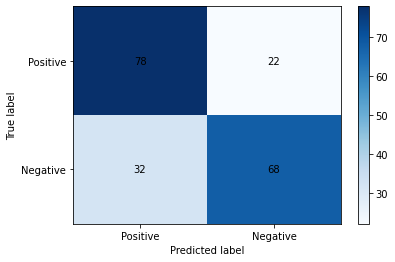

Test loss: 0.028495693358127027 
 Test accuracy: 73.0
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.023063121404912738 
 Training accuracy: 56.222222222222214
Test loss: 0.024963229596614837 
 Test accuracy: 53.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.01598871757586797 
 Training accuracy: 75.55555555555556
Test loss: 0.035836046934127806 
 Test accuracy: 57.99999999999999
------------------------------------------------------------------
epoch 2:
Training loss: 0.009797611567709181 
 Training accuracy: 87.5
Test loss: 0.025443323850631715 
 Test accuracy: 72.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.005501763561947478 
 Training accuracy: 93.38888888888889
Test loss: 0.04305556535720825 
 Test accuracy: 63.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.002604351427095632 
 Tra

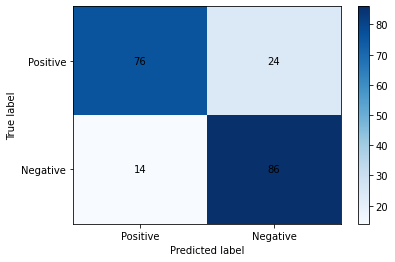

Test loss: 0.027180436700582504 
 Test accuracy: 81.0
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.023782288945383496 
 Training accuracy: 54.44444444444444
Test loss: 0.024200556874275206 
 Test accuracy: 63.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.016518097884125178 
 Training accuracy: 75.22222222222223
Test loss: 0.028500618040561677 
 Test accuracy: 63.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.01024594273004267 
 Training accuracy: 86.33333333333333
Test loss: 0.03999016314744949 
 Test accuracy: 56.00000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.006029367244078054 
 Training accuracy: 92.5
Test loss: 0.030713271349668503 
 Test accuracy: 66.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.00284730462771323 
 Train

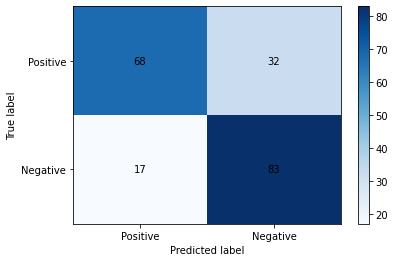

Test loss: 0.03599353104829788 
 Test accuracy: 75.5
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.02378938943147659 
 Training accuracy: 55.888888888888886
Test loss: 0.022467295825481414 
 Test accuracy: 64.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.016697930958535938 
 Training accuracy: 73.88888888888889
Test loss: 0.039072320461273194 
 Test accuracy: 51.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.012256544919477568 
 Training accuracy: 83.77777777777777
Test loss: 0.04169100672006607 
 Test accuracy: 68.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.00788857868148221 
 Training accuracy: 90.33333333333333
Test loss: 0.09322009325027465 
 Test accuracy: 54.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0046265955145160355 
 Train

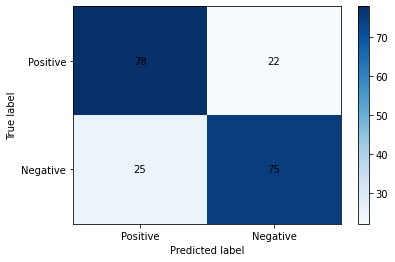

Test loss: 0.02845868229866028 
 Test accuracy: 76.5
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.023468572364913093 
 Training accuracy: 56.00000000000001
Test loss: 0.023268881738185882 
 Test accuracy: 65.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.015852555168999565 
 Training accuracy: 75.3888888888889
Test loss: 0.026854552924633027 
 Test accuracy: 67.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.009603783041238784 
 Training accuracy: 87.66666666666667
Test loss: 0.02559416487812996 
 Test accuracy: 68.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.005621635545459059 
 Training accuracy: 92.66666666666666
Test loss: 0.039065867364406585 
 Test accuracy: 66.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.003384727623520626 
 Train

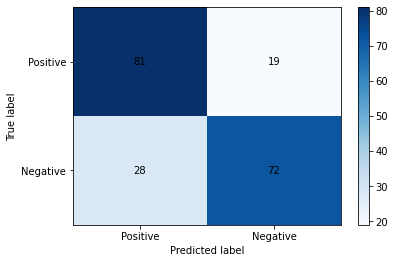

Test loss: 0.03806023508310318 
 Test accuracy: 76.5
------------------------------------------------------------------
Folds statistics:
----------------
 - mean: 76.05 
 - standard deviation: 2.8235615806991


In [ ]:
mean, std = main_cross_validation(main_LSTM, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

### BiLSTM with attention


 Fold: 0
epoch 0:
Training loss: 0.021795097357696958 
 Training accuracy: 53.61111111111111
Test loss: 0.023410221338272096 
 Test accuracy: 62.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.01773286326064004 
 Training accuracy: 71.27777777777777
Test loss: 0.015794773995876314 
 Test accuracy: 76.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.009659528819223245 
 Training accuracy: 87.66666666666667
Test loss: 0.012401050329208374 
 Test accuracy: 84.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.004157126425868935 
 Training accuracy: 95.22222222222221
Test loss: 0.010610655322670937 
 Test accuracy: 88.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0015133664961710263 
 Training accuracy: 98.66666666666667
Test loss: 0.027512444853782653 
 Test accuracy: 79.0
--------------------------------

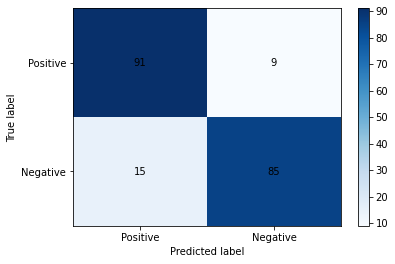

Test loss: 0.018926113694906235 
 Test accuracy: 88.0
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.021258756468693414 
 Training accuracy: 60.0
Test loss: 0.02166764885187149 
 Test accuracy: 70.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.018024798035621643 
 Training accuracy: 72.61111111111111
Test loss: 0.018074199557304382 
 Test accuracy: 73.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.011198907589746846 
 Training accuracy: 85.22222222222223
Test loss: 0.018576399832963945 
 Test accuracy: 78.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.004737648440317975 
 Training accuracy: 94.66666666666667
Test loss: 0.020111435502767564 
 Test accuracy: 82.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0021955386801467587 
 Training accura

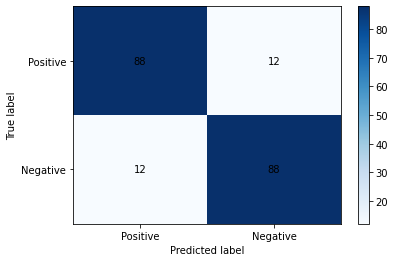

Test loss: 0.03150093525648117 
 Test accuracy: 88.0
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.02162853327062395 
 Training accuracy: 56.55555555555556
Test loss: 0.02387021094560623 
 Test accuracy: 57.49999999999999
------------------------------------------------------------------
epoch 1:
Training loss: 0.016654153962930043 
 Training accuracy: 74.8888888888889
Test loss: 0.019478261917829514 
 Test accuracy: 74.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.00835013400659793 
 Training accuracy: 89.38888888888889
Test loss: 0.017801892682909964 
 Test accuracy: 80.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0035691439184463688 
 Training accuracy: 96.22222222222221
Test loss: 0.0172846594825387 
 Test accuracy: 82.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0032607576796241

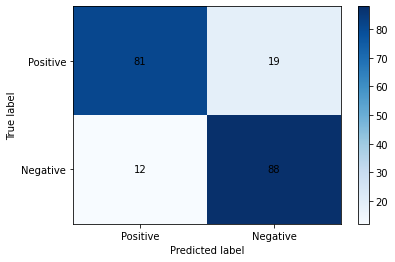

Test loss: 0.03371973425149918 
 Test accuracy: 84.5
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.02175895389583376 
 Training accuracy: 53.833333333333336
Test loss: 0.022886745631694794 
 Test accuracy: 54.50000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.017447168264124128 
 Training accuracy: 72.66666666666667
Test loss: 0.015161890089511871 
 Test accuracy: 80.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.008590546535948913 
 Training accuracy: 89.55555555555556
Test loss: 0.013802433758974076 
 Test accuracy: 85.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.003038574879626847 
 Training accuracy: 96.55555555555554
Test loss: 0.016183632309548557 
 Test accuracy: 85.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.00096435134

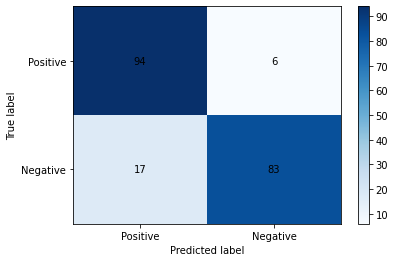

Test loss: 0.023837928771972657 
 Test accuracy: 88.5
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.021774593359894224 
 Training accuracy: 51.94444444444445
Test loss: 0.022856333553791047 
 Test accuracy: 51.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.01692623515923818 
 Training accuracy: 72.61111111111111
Test loss: 0.014927981942892075 
 Test accuracy: 81.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.009203684160278903 
 Training accuracy: 88.77777777777777
Test loss: 0.0162118025124073 
 Test accuracy: 77.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0045718434799669515 
 Training accuracy: 94.55555555555556
Test loss: 0.019444701671600343 
 Test accuracy: 80.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0026827996110336647 
 Tra

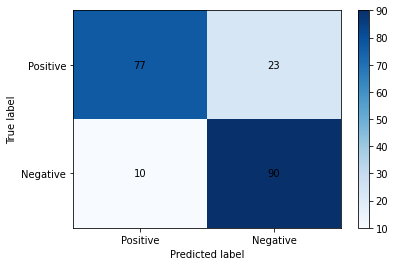

Test loss: 0.03535475879907608 
 Test accuracy: 83.5
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.021866018573443096 
 Training accuracy: 54.166666666666664
Test loss: 0.02342820107936859 
 Test accuracy: 64.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.017858778370751276 
 Training accuracy: 72.0
Test loss: 0.016783758848905563 
 Test accuracy: 73.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.009680255208578376 
 Training accuracy: 88.38888888888889
Test loss: 0.014028302654623985 
 Test accuracy: 82.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0029830742148785954 
 Training accuracy: 96.55555555555554
Test loss: 0.015479846729431302 
 Test accuracy: 84.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.000717433108859748 
 Training accura

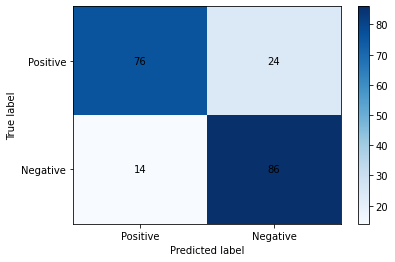

Test loss: 0.04454508721828461 
 Test accuracy: 81.0
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.021790418525536856 
 Training accuracy: 54.05555555555556
Test loss: 0.02349994659423828 
 Test accuracy: 62.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.017661417540576724 
 Training accuracy: 71.66666666666667
Test loss: 0.016460446119308473 
 Test accuracy: 79.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.009951821226212713 
 Training accuracy: 87.77777777777777
Test loss: 0.01863267056643963 
 Test accuracy: 82.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.004795115294141902 
 Training accuracy: 94.5
Test loss: 0.011129670217633248 
 Test accuracy: 88.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0017749882713865696 
 Training accuracy

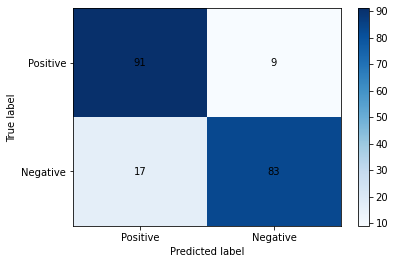

Test loss: 0.03181595057249069 
 Test accuracy: 87.0
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.021521759629249574 
 Training accuracy: 56.277777777777786
Test loss: 0.02138489156961441 
 Test accuracy: 71.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.014625386661953396 
 Training accuracy: 77.44444444444444
Test loss: 0.01628032624721527 
 Test accuracy: 75.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.009039930650550459 
 Training accuracy: 88.61111111111111
Test loss: 0.015445475056767464 
 Test accuracy: 83.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.005839593667640454 
 Training accuracy: 93.44444444444444
Test loss: 0.017003181353211404 
 Test accuracy: 85.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0018141986877890303 
 Tra

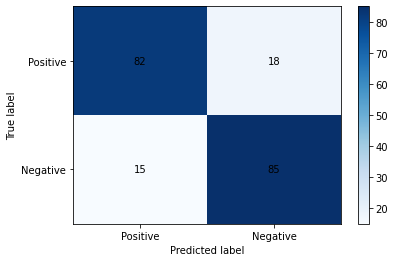

Test loss: 0.03246338203549385 
 Test accuracy: 83.5
------------------------------------------------------------------
Folds statistics:
----------------
 - mean: 85.55 
 - standard deviation: 2.6594172293944403


In [ ]:
# Smaller batch sizes are noisy, this means that they are more regularizing and the
# generalization error will be lower
mean, std = main_cross_validation(main, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

### BiLSTM no objective sentences:
Now the the BiLSTM and BiLSTM with attention will be tested again, but the corpus will have the objective sentences removed.

In [ ]:
# -1 adds the element in the penultimate position (Since flattener should be the last one)
mr_pipeline.add_pipeline_element(ShallowObjectiveSentsRemover(pred), -1)
mr_corpus = MovieReviewsCorpus(mr_pipeline)
mr_embedding_matrix = mr_corpus.get_embedding_matrix(fast_text, 300)
mr_dataset = MovieReviewsDataset(mr_corpus.get_indexed_corpus())


 Fold: 0
epoch 0:
Training loss: 0.02387034147977829 
 Training accuracy: 55.00000000000001
Test loss: 0.02379695773124695 
 Test accuracy: 59.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.01751218658354547 
 Training accuracy: 73.55555555555556
Test loss: 0.02525798439979553 
 Test accuracy: 60.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.012184095838003688 
 Training accuracy: 83.27777777777777
Test loss: 0.035295106768608094 
 Test accuracy: 59.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.007363299715022246 
 Training accuracy: 90.72222222222223
Test loss: 0.053041411638259886 
 Test accuracy: 53.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.003983579064822859 
 Training accuracy: 95.66666666666667
Test loss: 0.026307492852210998 
 Test accuracy: 69.5
------------------------------------

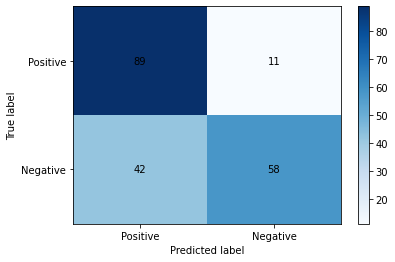

Test loss: 0.02863759309053421 
 Test accuracy: 73.5
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.02336952828698688 
 Training accuracy: 55.00000000000001
Test loss: 0.024679625928401946 
 Test accuracy: 53.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.01604735462201966 
 Training accuracy: 75.44444444444444
Test loss: 0.02476449906826019 
 Test accuracy: 62.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.00930899226003223 
 Training accuracy: 88.38888888888889
Test loss: 0.020878075659275054 
 Test accuracy: 69.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0046796332765370605 
 Training accuracy: 94.55555555555556
Test loss: 0.027384558618068697 
 Test accuracy: 74.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0030812548608001736 
 Train

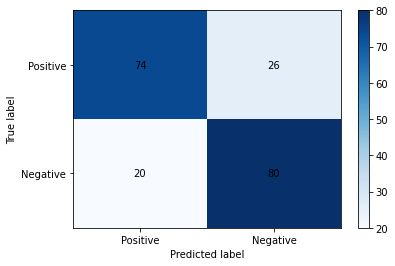

Test loss: 0.030633203983306885 
 Test accuracy: 77.0
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.02354633069700665 
 Training accuracy: 54.0
Test loss: 0.022417490482330323 
 Test accuracy: 60.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.017659031914340127 
 Training accuracy: 73.05555555555556
Test loss: 0.029497710019350053 
 Test accuracy: 66.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.011617711989416017 
 Training accuracy: 84.88888888888889
Test loss: 0.02668735831975937 
 Test accuracy: 72.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.005654653540501992 
 Training accuracy: 92.94444444444444
Test loss: 0.03470859348773956 
 Test accuracy: 73.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.002927573759936624 
 Training accuracy:

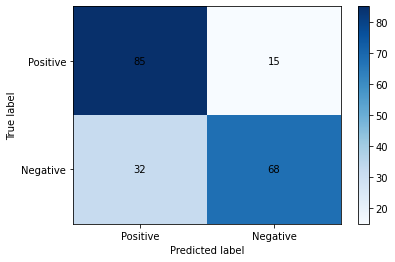

Test loss: 0.02801991194486618 
 Test accuracy: 76.5
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.023284091502428054 
 Training accuracy: 55.50000000000001
Test loss: 0.023501268327236174 
 Test accuracy: 61.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.016127876026762855 
 Training accuracy: 75.22222222222223
Test loss: 0.025111706256866456 
 Test accuracy: 61.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.009863054197695521 
 Training accuracy: 87.0
Test loss: 0.059566674828529356 
 Test accuracy: 52.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.006273848360611333 
 Training accuracy: 91.88888888888889
Test loss: 0.04056583285331726 
 Test accuracy: 66.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0028834457736876275 
 Training accurac

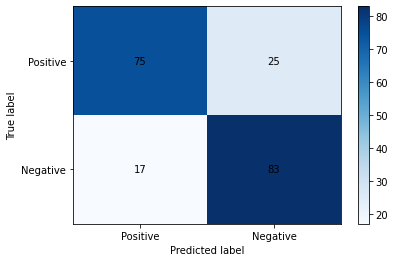

Test loss: 0.025258223749697207 
 Test accuracy: 79.0
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.023184189663992986 
 Training accuracy: 57.49999999999999
Test loss: 0.023603791892528533 
 Test accuracy: 57.99999999999999
------------------------------------------------------------------
epoch 1:
Training loss: 0.01587600928213861 
 Training accuracy: 75.72222222222223
Test loss: 0.038092903792858124 
 Test accuracy: 52.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.010462081821428404 
 Training accuracy: 86.83333333333333
Test loss: 0.02399922676384449 
 Test accuracy: 65.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.004977998907367389 
 Training accuracy: 94.38888888888889
Test loss: 0.03202356725931168 
 Test accuracy: 70.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0029384766829

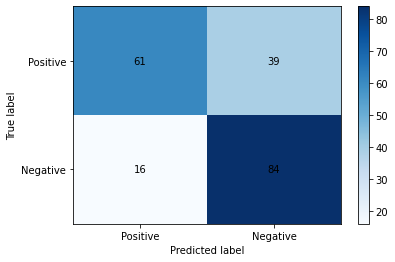

Test loss: 0.042576413154602054 
 Test accuracy: 72.5
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.023260070913367802 
 Training accuracy: 54.55555555555556
Test loss: 0.0226694455742836 
 Test accuracy: 63.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.015871897157695557 
 Training accuracy: 75.44444444444444
Test loss: 0.025155338048934935 
 Test accuracy: 71.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.012028571110632685 
 Training accuracy: 84.5
Test loss: 0.05450389623641968 
 Test accuracy: 49.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.006675866073411372 
 Training accuracy: 92.16666666666666
Test loss: 0.08670625865459441 
 Test accuracy: 50.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.004973087437036965 
 Training accuracy: 

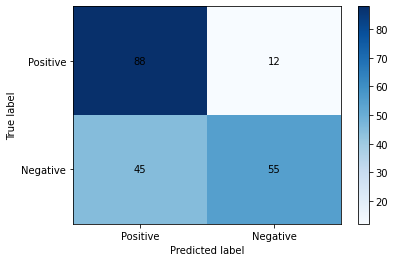

Test loss: 0.032658943831920625 
 Test accuracy: 71.5
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.023826510541968875 
 Training accuracy: 55.611111111111114
Test loss: 0.023833476305007935 
 Test accuracy: 60.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.015638611026936106 
 Training accuracy: 77.72222222222223
Test loss: 0.025935913920402526 
 Test accuracy: 64.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.009284891602065828 
 Training accuracy: 87.83333333333333
Test loss: 0.041391366720199586 
 Test accuracy: 57.99999999999999
------------------------------------------------------------------
epoch 3:
Training loss: 0.005101474943674273 
 Training accuracy: 94.33333333333334
Test loss: 0.026542319282889366 
 Test accuracy: 70.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.002891732

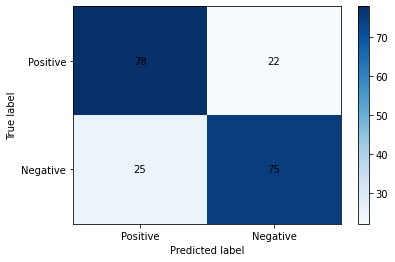

Test loss: 0.0255964133143425 
 Test accuracy: 76.5
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.02380148728688558 
 Training accuracy: 55.00000000000001
Test loss: 0.02353420525789261 
 Test accuracy: 61.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.0154420751084884 
 Training accuracy: 77.44444444444444
Test loss: 0.05652839720249176 
 Test accuracy: 52.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.009083441396554311 
 Training accuracy: 88.16666666666667
Test loss: 0.026267620027065276 
 Test accuracy: 73.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.004800262906485134 
 Training accuracy: 94.44444444444444
Test loss: 0.02313091516494751 
 Test accuracy: 71.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.003020699093532231 
 Training a

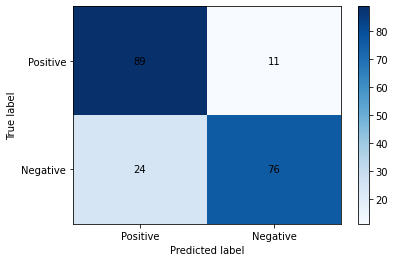

Test loss: 0.02169212207198143 
 Test accuracy: 82.5
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.023383421103159586 
 Training accuracy: 55.388888888888886
Test loss: 0.023132239282131196 
 Test accuracy: 59.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.016784499171707365 
 Training accuracy: 74.8888888888889
Test loss: 0.042475703656673434 
 Test accuracy: 50.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.011242741147677104 
 Training accuracy: 85.94444444444444
Test loss: 0.0372149121761322 
 Test accuracy: 55.00000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.005554521114875873 
 Training accuracy: 93.66666666666667
Test loss: 0.05324284553527832 
 Test accuracy: 60.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.00285750958240

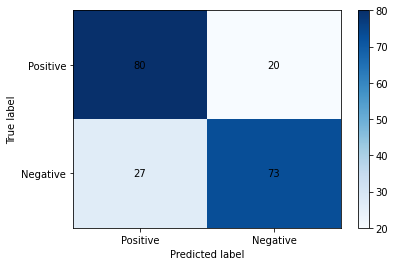

Test loss: 0.02530808687210083 
 Test accuracy: 76.5
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.023718458182281917 
 Training accuracy: 55.611111111111114
Test loss: 0.022796822488307954 
 Test accuracy: 66.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.014432850066158506 
 Training accuracy: 77.94444444444444
Test loss: 0.022862635552883148 
 Test accuracy: 75.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.007180582106941276 
 Training accuracy: 91.0
Test loss: 0.061474567651748656 
 Test accuracy: 53.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0038224358339276577 
 Training accuracy: 96.0
Test loss: 0.02635718762874603 
 Test accuracy: 76.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0026799254947238497 
 Training accuracy: 97.44444

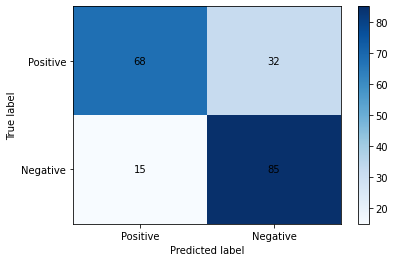

Test loss: 0.032775334417819976 
 Test accuracy: 76.5
------------------------------------------------------------------
Folds statistics:
----------------
 - mean: 76.2 
 - standard deviation: 3.026549190084311


In [ ]:
# BiLSTM without attention
mean, std = main_cross_validation(main_LSTM, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

### BiLSTM with attention no objective sentences:


 Fold: 0
epoch 0:
Training loss: 0.021639196111096277 
 Training accuracy: 54.05555555555556
Test loss: 0.022540103644132614 
 Test accuracy: 54.50000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.017799183759424422 
 Training accuracy: 70.94444444444444
Test loss: 0.018558766096830367 
 Test accuracy: 77.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.008565328460600641 
 Training accuracy: 89.33333333333333
Test loss: 0.01352367103099823 
 Test accuracy: 83.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0042165919483846265 
 Training accuracy: 95.33333333333334
Test loss: 0.009205330377444625 
 Test accuracy: 90.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0019881370263950277 
 Training accuracy: 97.94444444444444
Test loss: 0.010414743423461914 
 Test accuracy: 92.0
------------------

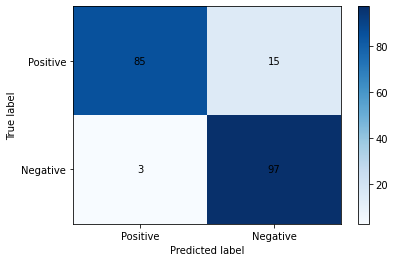

Test loss: 0.016370284417644144 
 Test accuracy: 91.0
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.021734163264433542 
 Training accuracy: 54.55555555555556
Test loss: 0.022245786488056182 
 Test accuracy: 67.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.01677231318420834 
 Training accuracy: 74.55555555555556
Test loss: 0.01695349156856537 
 Test accuracy: 79.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.00854988972345988 
 Training accuracy: 90.22222222222223
Test loss: 0.012063582614064216 
 Test accuracy: 84.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0033876185113978054 
 Training accuracy: 96.33333333333334
Test loss: 0.013827476799488068 
 Test accuracy: 88.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0012732661137771276 
 Tra

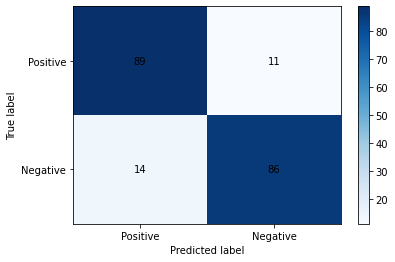

Test loss: 0.021682194024324416 
 Test accuracy: 87.5
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.021951165199279785 
 Training accuracy: 50.83333333333333
Test loss: 0.02372622847557068 
 Test accuracy: 64.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.017492386284801695 
 Training accuracy: 72.33333333333334
Test loss: 0.01977995127439499 
 Test accuracy: 73.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.008428673574493992 
 Training accuracy: 88.88888888888889
Test loss: 0.012447607144713402 
 Test accuracy: 85.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0024297073918084305 
 Training accuracy: 97.33333333333334
Test loss: 0.01196417526109144 
 Test accuracy: 86.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0009694240900636133 
 Tra

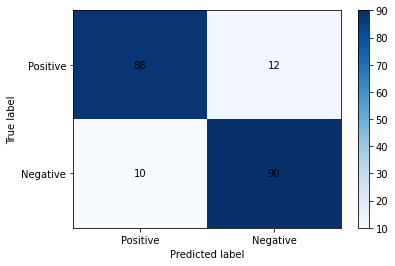

Test loss: 0.02492154683917761 
 Test accuracy: 89.0
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.02150091287162569 
 Training accuracy: 54.72222222222223
Test loss: 0.03635637640953064 
 Test accuracy: 50.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.018273790064785217 
 Training accuracy: 70.88888888888889
Test loss: 0.02083463966846466 
 Test accuracy: 68.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.008928112271759246 
 Training accuracy: 88.27777777777777
Test loss: 0.01187536671757698 
 Test accuracy: 87.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.004102523243572149 
 Training accuracy: 95.5
Test loss: 0.010947539452463389 
 Test accuracy: 88.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0016143270042569687 
 Training accuracy: 

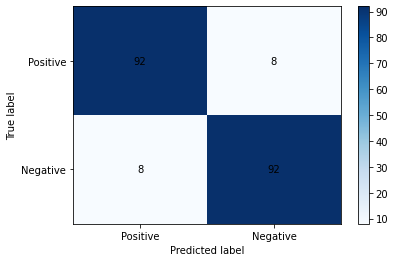

Test loss: 0.012599720816069748 
 Test accuracy: 92.0
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.02168910413980484 
 Training accuracy: 54.166666666666664
Test loss: 0.01848271131515503 
 Test accuracy: 73.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.015104347003830804 
 Training accuracy: 77.66666666666666
Test loss: 0.013565133437514304 
 Test accuracy: 81.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.005506810648366809 
 Training accuracy: 92.88888888888889
Test loss: 0.018551650643348693 
 Test accuracy: 87.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0026968542333795794 
 Training accuracy: 96.83333333333334
Test loss: 0.025599702149629592 
 Test accuracy: 83.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0010443264271937855 
 T

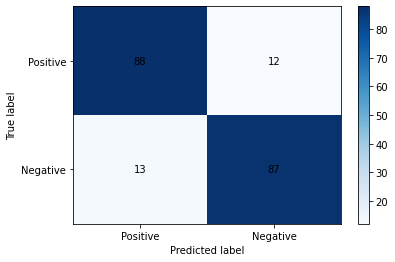

Test loss: 0.026487072678282857 
 Test accuracy: 87.5
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.021780260834429 
 Training accuracy: 52.27777777777778
Test loss: 0.025171340703964235 
 Test accuracy: 50.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.015542651903298167 
 Training accuracy: 76.16666666666667
Test loss: 0.019943798929452895 
 Test accuracy: 75.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.008658180465507839 
 Training accuracy: 89.5
Test loss: 0.012670110091567039 
 Test accuracy: 84.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.004575627786883463 
 Training accuracy: 95.44444444444444
Test loss: 0.018465566635131835 
 Test accuracy: 78.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.001155286253552832 
 Training accuracy:

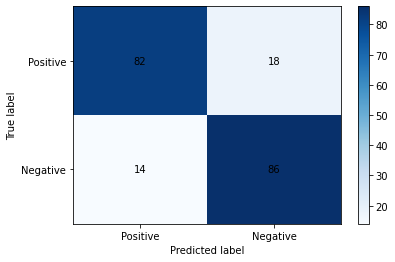

Test loss: 0.032466102689504624 
 Test accuracy: 84.0
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.020876014083623887 
 Training accuracy: 58.611111111111114
Test loss: 0.01787534177303314 
 Test accuracy: 79.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.01641978896326489 
 Training accuracy: 77.11111111111111
Test loss: 0.018681050539016725 
 Test accuracy: 70.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.010697006303817034 
 Training accuracy: 86.0
Test loss: 0.015546115785837174 
 Test accuracy: 85.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.004061707394818465 
 Training accuracy: 95.05555555555556
Test loss: 0.016123212203383447 
 Test accuracy: 87.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0029715901049267913 
 Training accura

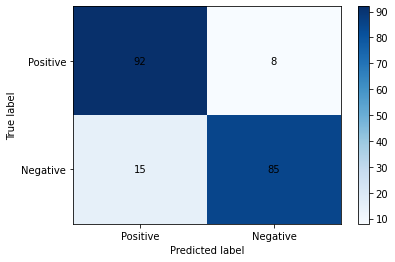

Test loss: 0.032402670085430144 
 Test accuracy: 88.5
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.020686027391089334 
 Training accuracy: 59.38888888888889
Test loss: 0.01861408233642578 
 Test accuracy: 74.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.014640840192635854 
 Training accuracy: 79.72222222222223
Test loss: 0.015926344245672228 
 Test accuracy: 83.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.005930938871784343 
 Training accuracy: 93.83333333333333
Test loss: 0.022106000036001206 
 Test accuracy: 82.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0023308159570701215 
 Training accuracy: 97.72222222222223
Test loss: 0.01624310202896595 
 Test accuracy: 87.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0008508621598270515 
 Tr

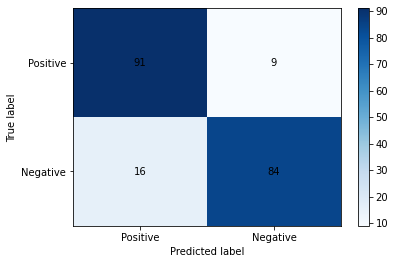

Test loss: 0.026316106021404266 
 Test accuracy: 87.5
------------------------------------------------------------------
Folds statistics:
----------------
 - mean: 88.25 
 - standard deviation: 2.170829334609241


In [ ]:
mean, std = main_cross_validation(main, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

### LBSA

In [ ]:
LBSA_pipeline = Pipeline(UnderscoreRemover(),
                         CharacterRepetitionRemover(),
                         ApostrophesMerger(),
                         ContractionCleaner(),
                         SpecialCharsCleaner(),
                         )
LBSA_corpus = MovieReviewsCorpusLBSA(LBSA_pipeline, path = lexicon_path)
LBSA_embedding_matrix = LBSA_corpus.get_embedding_matrix(fast_text, 300)
LBSA_dataset = MovieReviewsDatasetLBSA(LBSA_corpus.get_indexed_corpus())

Coverage of the lexicon: 0.3351701371254444


In [ ]:
mean, std = main_cross_validation(main_LBSA, LBSA_dataset, LBSA_embedding_matrix, collateLBSA, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")


 Fold: 0
epoch 0:
Training loss: 0.03014103101359473 
 Training accuracy: 52.666666666666664
Test loss: 0.0334275883436203 
 Test accuracy: 53.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.02550183971722921 
 Training accuracy: 73.44444444444444
Test loss: 0.02518030911684036 
 Test accuracy: 85.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.01615376008881463 
 Training accuracy: 90.66666666666666
Test loss: 0.023007409274578096 
 Test accuracy: 83.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.012470400151279237 
 Training accuracy: 95.22222222222221
Test loss: 0.041258959770202636 
 Test accuracy: 69.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.011862359444300334 
 Training accuracy: 95.44444444444444
Test loss: 0.02465222552418709 
 Test accuracy: 86.0
--------------------------------------

#### LBSA no objective sentences:

In [ ]:
LBSA_pipeline.add_pipeline_element(ShallowObjectiveSentsRemover(pred))
LBSA_corpus = MovieReviewsCorpusLBSA(LBSA_pipeline, path = lexicon_path)
LBSA_embedding_matrix = LBSA_corpus.get_embedding_matrix(fast_text, 300)
LBSA_dataset = MovieReviewsDatasetLBSA(LBSA_corpus.get_indexed_corpus())

Coverage of the lexicon: 0.3956659944628636


In [ ]:
mean, std = main_cross_validation(main_LBSA, LBSA_dataset, LBSA_embedding_matrix, collateLBSA, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")


 Fold: 0
epoch 0:
Training loss: 0.028710253304905363 
 Training accuracy: 52.44444444444445
Test loss: 0.0327812248468399 
 Test accuracy: 50.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.024732065482272043 
 Training accuracy: 67.16666666666666
Test loss: 0.023388556838035583 
 Test accuracy: 82.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.015488983558283912 
 Training accuracy: 89.61111111111111
Test loss: 0.025872547924518586 
 Test accuracy: 81.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.01005155889524354 
 Training accuracy: 96.55555555555554
Test loss: 0.01905759945511818 
 Test accuracy: 88.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.008882501878672176 
 Training accuracy: 98.11111111111111
Test loss: 0.019669829457998275 
 Test accuracy: 90.5
------------------------------------

## Deep Models (Glove 840B Embedding)

### BiLSTM

In [ ]:
mr_pipeline = Pipeline(UnderscoreRemover(),
                       CharacterRepetitionRemover(),
                       ApostrophesMerger(),
                       ContractionCleaner(),
                       SpecialCharsCleaner()
                      )
mr_corpus = MovieReviewsCorpus(mr_pipeline)
mr_embedding_matrix = mr_corpus.get_embedding_matrix(global_vectors, 300)
mr_dataset = MovieReviewsDataset(mr_corpus.get_indexed_corpus())


 Fold: 0
epoch 0:
Training loss: 0.02326493584447437 
 Training accuracy: 56.55555555555556
Test loss: 0.023491252660751343 
 Test accuracy: 61.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.015931274526649053 
 Training accuracy: 74.27777777777777
Test loss: 0.02641537129878998 
 Test accuracy: 62.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.01077085064517127 
 Training accuracy: 85.16666666666667
Test loss: 0.023553130328655244 
 Test accuracy: 71.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.00669342706600825 
 Training accuracy: 91.11111111111111
Test loss: 0.02755808621644974 
 Test accuracy: 68.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.00378199710821112 
 Training accuracy: 95.44444444444444
Test loss: 0.022551939189434052 
 Test accuracy: 75.5
--------------------------------------

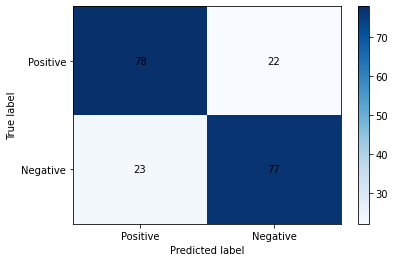

Test loss: 0.025401687920093535 
 Test accuracy: 77.5
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.023126775258117252 
 Training accuracy: 55.666666666666664
Test loss: 0.022806507647037507 
 Test accuracy: 61.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.015363170107205708 
 Training accuracy: 76.05555555555556
Test loss: 0.02347541481256485 
 Test accuracy: 65.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.010025259512994024 
 Training accuracy: 86.8888888888889
Test loss: 0.021027960777282716 
 Test accuracy: 74.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.006437961301869816 
 Training accuracy: 91.88888888888889
Test loss: 0.024726116359233857 
 Test accuracy: 67.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.004125183992501762 
 Tra

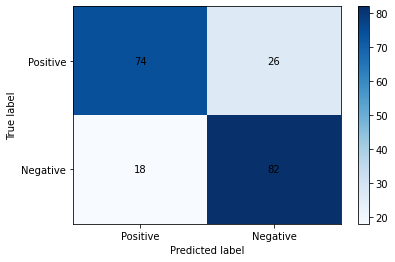

Test loss: 0.027577444165945052 
 Test accuracy: 78.0
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.023335604601436192 
 Training accuracy: 55.722222222222214
Test loss: 0.02415470689535141 
 Test accuracy: 60.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.01593241282635265 
 Training accuracy: 75.16666666666667
Test loss: 0.02100072890520096 
 Test accuracy: 65.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.011031396496627066 
 Training accuracy: 84.16666666666667
Test loss: 0.019428018368780612 
 Test accuracy: 73.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.006450966215795941 
 Training accuracy: 92.11111111111111
Test loss: 0.038023378401994705 
 Test accuracy: 64.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0035127494670450688 
 Tra

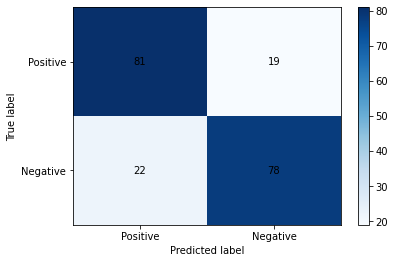

Test loss: 0.025446537286043167 
 Test accuracy: 79.5
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.02260479473405414 
 Training accuracy: 60.22222222222222
Test loss: 0.024097153544425966 
 Test accuracy: 58.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.01543795449866189 
 Training accuracy: 76.77777777777777
Test loss: 0.03492952138185501 
 Test accuracy: 62.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.010569020675288306 
 Training accuracy: 85.61111111111111
Test loss: 0.019679529368877412 
 Test accuracy: 78.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.006028156777222952 
 Training accuracy: 92.66666666666666
Test loss: 0.025289975702762604 
 Test accuracy: 75.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0035150267959882815 
 Trai

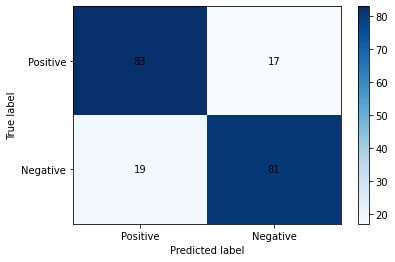

Test loss: 0.024858595877885817 
 Test accuracy: 82.0
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.02327483461962806 
 Training accuracy: 57.94444444444444
Test loss: 0.02446795493364334 
 Test accuracy: 59.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.016598608675930236 
 Training accuracy: 74.8888888888889
Test loss: 0.029685142934322357 
 Test accuracy: 58.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.011255263148082627 
 Training accuracy: 83.77777777777777
Test loss: 0.021627460718154908 
 Test accuracy: 73.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.005768224311371644 
 Training accuracy: 93.05555555555556
Test loss: 0.02903771698474884 
 Test accuracy: 73.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0037976509694837863 
 Train

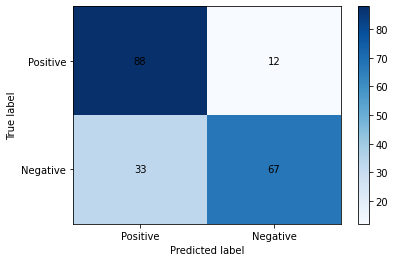

Test loss: 0.030837898999452593 
 Test accuracy: 77.5
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.02313209291961458 
 Training accuracy: 56.333333333333336
Test loss: 0.022350315749645234 
 Test accuracy: 64.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.016389274464713204 
 Training accuracy: 74.6111111111111
Test loss: 0.026085085272789 
 Test accuracy: 65.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.010595856971210904 
 Training accuracy: 85.5
Test loss: 0.03655403822660446 
 Test accuracy: 62.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.007391286024616825 
 Training accuracy: 91.0
Test loss: 0.033020265102386474 
 Test accuracy: 66.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0042762756761577396 
 Training accuracy: 95.1666666666

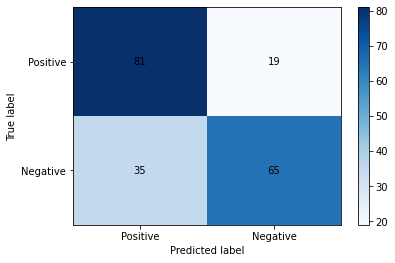

Test loss: 0.030288220793008806 
 Test accuracy: 73.0
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.022976126339700486 
 Training accuracy: 58.72222222222222
Test loss: 0.023159579932689668 
 Test accuracy: 59.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.015260696096552742 
 Training accuracy: 77.33333333333333
Test loss: 0.022514469623565674 
 Test accuracy: 67.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.010148931932118204 
 Training accuracy: 87.16666666666667
Test loss: 0.026934077963232994 
 Test accuracy: 62.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0056720316865377955 
 Training accuracy: 93.11111111111111
Test loss: 0.0374565839767456 
 Test accuracy: 64.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0037595483753830195 
 Tr

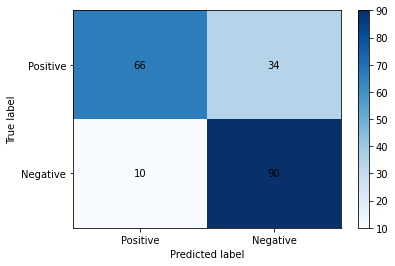

Test loss: 0.035009793043136596 
 Test accuracy: 78.0
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.023639030092292363 
 Training accuracy: 55.222222222222214
Test loss: 0.022561689019203187 
 Test accuracy: 62.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.015020455751154158 
 Training accuracy: 76.83333333333333
Test loss: 0.018422655835747717 
 Test accuracy: 75.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.009595939028594229 
 Training accuracy: 86.55555555555556
Test loss: 0.035220129787921904 
 Test accuracy: 68.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0062622544583347105 
 Training accuracy: 92.05555555555556
Test loss: 0.021886767596006395 
 Test accuracy: 77.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0033440092112869023 


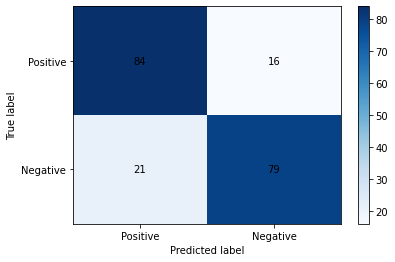

Test loss: 0.02619612280279398 
 Test accuracy: 81.5
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.02309932937224706 
 Training accuracy: 56.44444444444444
Test loss: 0.02302224040031433 
 Test accuracy: 57.99999999999999
------------------------------------------------------------------
epoch 1:
Training loss: 0.015609665248129102 
 Training accuracy: 76.38888888888889
Test loss: 0.03471626132726669 
 Test accuracy: 56.00000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.011148544723788897 
 Training accuracy: 85.11111111111111
Test loss: 0.023716618418693543 
 Test accuracy: 67.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.007439125246471829 
 Training accuracy: 91.0
Test loss: 0.02539800465106964 
 Test accuracy: 66.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.003300686199218

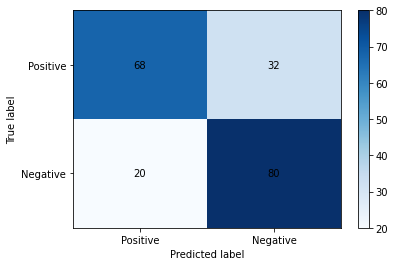

Test loss: 0.027147928923368453 
 Test accuracy: 74.0
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.022917653222878774 
 Training accuracy: 56.166666666666664
Test loss: 0.02167698085308075 
 Test accuracy: 64.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.015302395274241765 
 Training accuracy: 75.72222222222223
Test loss: 0.02264113962650299 
 Test accuracy: 68.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.009813021727734142 
 Training accuracy: 87.05555555555556
Test loss: 0.023170120269060134 
 Test accuracy: 79.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.005291111183663209 
 Training accuracy: 93.5
Test loss: 0.02422938361763954 
 Test accuracy: 80.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0029762179042316147 
 Training accurac

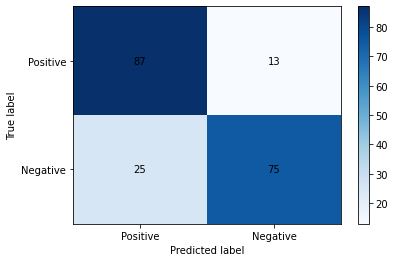

Test loss: 0.02634764790534973 
 Test accuracy: 81.0
------------------------------------------------------------------
Folds statistics:
----------------
 - mean: 78.2 
 - standard deviation: 2.839013913315678


In [ ]:
# BiLSTM without attention
mean, std = main_cross_validation(main_LSTM, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

### BiLSTM with attention


 Fold: 0
epoch 0:
Training loss: 0.02155253615644243 
 Training accuracy: 56.05555555555556
Test loss: 0.021670649349689482 
 Test accuracy: 58.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.015018790943755043 
 Training accuracy: 77.11111111111111
Test loss: 0.014782620221376419 
 Test accuracy: 80.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.00785049771062202 
 Training accuracy: 91.5
Test loss: 0.02126977503299713 
 Test accuracy: 76.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.005235258646102415 
 Training accuracy: 93.72222222222221
Test loss: 0.01493214726448059 
 Test accuracy: 82.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0028034026030864983 
 Training accuracy: 97.27777777777777
Test loss: 0.02646209090948105 
 Test accuracy: 79.0
-------------------------------------------------

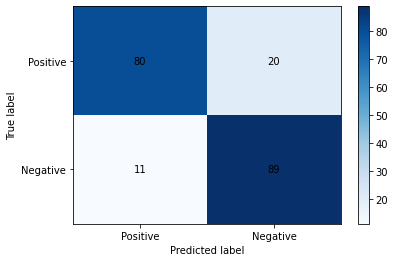

Test loss: 0.023048621229827405 
 Test accuracy: 84.5
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.021442430946562025 
 Training accuracy: 54.22222222222223
Test loss: 0.020335286855697632 
 Test accuracy: 70.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.016879215356376435 
 Training accuracy: 75.77777777777777
Test loss: 0.019594998359680177 
 Test accuracy: 70.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.011057081218394969 
 Training accuracy: 85.61111111111111
Test loss: 0.01160251498222351 
 Test accuracy: 85.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.007723133110751708 
 Training accuracy: 90.72222222222223
Test loss: 0.015334369093179702 
 Test accuracy: 78.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.004031740224842603 
 Tra

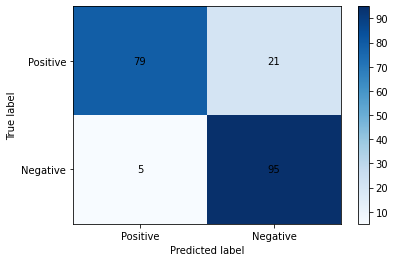

Test loss: 0.024318827241659166 
 Test accuracy: 87.0
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.02092316546373897 
 Training accuracy: 57.111111111111114
Test loss: 0.023247679769992827 
 Test accuracy: 59.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.013733487129211425 
 Training accuracy: 79.88888888888889
Test loss: 0.01717109650373459 
 Test accuracy: 71.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.00828457095556789 
 Training accuracy: 88.88888888888889
Test loss: 0.016815457493066788 
 Test accuracy: 81.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.002943482476855732 
 Training accuracy: 96.94444444444444
Test loss: 0.020624410137534143 
 Test accuracy: 84.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0012328824730745206 
 Tra

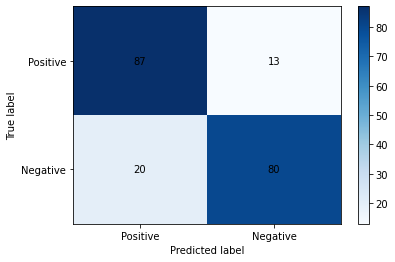

Test loss: 0.03606640160083771 
 Test accuracy: 83.5
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.021072253353065916 
 Training accuracy: 60.22222222222222
Test loss: 0.017927265912294387 
 Test accuracy: 75.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.013160450731714566 
 Training accuracy: 82.05555555555556
Test loss: 0.013940638825297356 
 Test accuracy: 79.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.007258909046649933 
 Training accuracy: 90.83333333333333
Test loss: 0.02458500139415264 
 Test accuracy: 71.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.005345447113116583 
 Training accuracy: 93.16666666666666
Test loss: 0.016470069512724877 
 Test accuracy: 86.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0015550134477477211 
 Tra

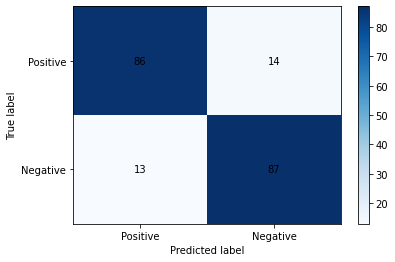

Test loss: 0.025290113918017595 
 Test accuracy: 86.5
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.02099941379494137 
 Training accuracy: 58.111111111111114
Test loss: 0.022022672295570374 
 Test accuracy: 64.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.013812341375483407 
 Training accuracy: 79.88888888888889
Test loss: 0.013354511633515358 
 Test accuracy: 85.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.0070837734329203764 
 Training accuracy: 91.27777777777779
Test loss: 0.011179283931851388 
 Test accuracy: 89.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0027020209815560117 
 Training accuracy: 97.27777777777777
Test loss: 0.013455118257552386 
 Test accuracy: 88.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0006543653663215486 


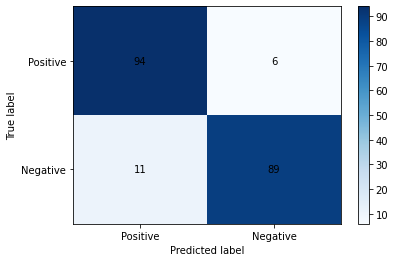

Test loss: 0.0386147141456604 
 Test accuracy: 91.5
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.020663922793335385 
 Training accuracy: 61.38888888888889
Test loss: 0.01857181414961815 
 Test accuracy: 76.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.015152999973959393 
 Training accuracy: 78.94444444444444
Test loss: 0.015413488149642945 
 Test accuracy: 80.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.007702189572155476 
 Training accuracy: 90.0
Test loss: 0.01669527977705002 
 Test accuracy: 83.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.004151607446062068 
 Training accuracy: 95.27777777777777
Test loss: 0.01321905137039721 
 Test accuracy: 84.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.002669190150789089 
 Training accuracy: 9

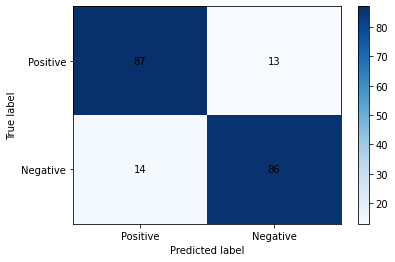

Test loss: 0.030987178385257722 
 Test accuracy: 86.5
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.02052503052684996 
 Training accuracy: 61.83333333333333
Test loss: 0.024369435608386992 
 Test accuracy: 65.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.01414254028764036 
 Training accuracy: 80.33333333333333
Test loss: 0.028533762395381926 
 Test accuracy: 70.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.009212451775868734 
 Training accuracy: 87.55555555555556
Test loss: 0.01209356501698494 
 Test accuracy: 85.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.004302111047113108 
 Training accuracy: 95.16666666666667
Test loss: 0.022886850833892823 
 Test accuracy: 87.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.002643709452176053 
 Train

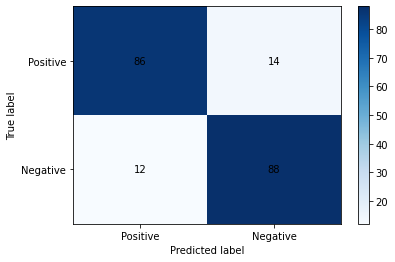

Test loss: 0.025310329673811794 
 Test accuracy: 87.0
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.01925687074661255 
 Training accuracy: 68.5
Test loss: 0.019881903529167175 
 Test accuracy: 70.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.01269947046207057 
 Training accuracy: 82.22222222222221
Test loss: 0.012473676428198814 
 Test accuracy: 79.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.00772326751301686 
 Training accuracy: 90.11111111111111
Test loss: 0.009838690496981144 
 Test accuracy: 88.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.003863813152226309 
 Training accuracy: 95.5
Test loss: 0.009935332983732224 
 Test accuracy: 89.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.002071585729912234 
 Training accuracy: 98.0
Test lo

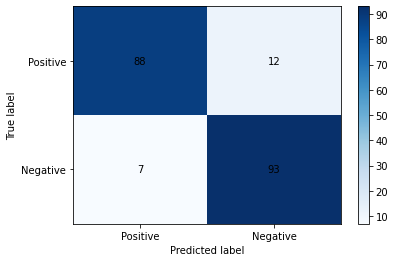

Test loss: 0.017235788054240402 
 Test accuracy: 90.5
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.019749333875046834 
 Training accuracy: 62.55555555555555
Test loss: 0.017521776854991913 
 Test accuracy: 77.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.015077509925597244 
 Training accuracy: 79.0
Test loss: 0.01855700448155403 
 Test accuracy: 78.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.0074664150468177265 
 Training accuracy: 90.66666666666666
Test loss: 0.022157267332077027 
 Test accuracy: 77.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0050861579169415765 
 Training accuracy: 94.38888888888889
Test loss: 0.027186837941408158 
 Test accuracy: 80.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0024639210600354193 
 Training accu

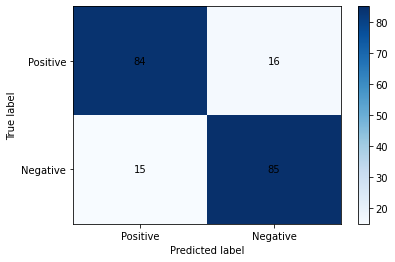

Test loss: 0.025141944773495198 
 Test accuracy: 84.5
------------------------------------------------------------------
Folds statistics:
----------------
 - mean: 87.25 
 - standard deviation: 2.2721135535003527


In [ ]:
# BiLSTM with attention
mean, std = main_cross_validation(main, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

### BiLSTM no objective sentences

In [ ]:
mr_pipeline.add_pipeline_element(ShallowObjectiveSentsRemover(pred), -1)
mr_corpus = MovieReviewsCorpus(mr_pipeline)
mr_embedding_matrix = mr_corpus.get_embedding_matrix(global_vectors, 300)
mr_dataset = MovieReviewsDataset(mr_corpus.get_indexed_corpus())


 Fold: 0
epoch 0:
Training loss: 0.02379842397239473 
 Training accuracy: 56.05555555555556
Test loss: 0.0220110160112381 
 Test accuracy: 64.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.015308277838759952 
 Training accuracy: 77.72222222222223
Test loss: 0.027203924059867858 
 Test accuracy: 65.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.00994151710636086 
 Training accuracy: 86.61111111111111
Test loss: 0.02479477435350418 
 Test accuracy: 72.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.005669634747836325 
 Training accuracy: 93.38888888888889
Test loss: 0.04161192417144775 
 Test accuracy: 72.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.002919681065508889 
 Training accuracy: 96.72222222222221
Test loss: 0.04132441937923431 
 Test accuracy: 66.5
---------------------------------------

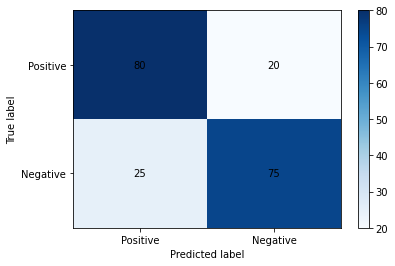

Test loss: 0.02821291357278824 
 Test accuracy: 77.5
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.023126142985290952 
 Training accuracy: 57.05555555555556
Test loss: 0.023956333100795747 
 Test accuracy: 57.49999999999999
------------------------------------------------------------------
epoch 1:
Training loss: 0.014769975940386454 
 Training accuracy: 77.27777777777777
Test loss: 0.017920830696821214 
 Test accuracy: 71.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.009626281294557783 
 Training accuracy: 88.1111111111111
Test loss: 0.02108939379453659 
 Test accuracy: 73.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0061692016758024696 
 Training accuracy: 92.72222222222221
Test loss: 0.024683928191661833 
 Test accuracy: 74.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.003461591745

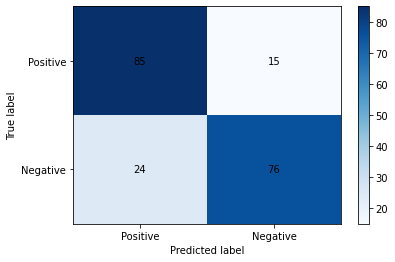

Test loss: 0.028303526639938355 
 Test accuracy: 80.5
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.023017145229710472 
 Training accuracy: 57.666666666666664
Test loss: 0.021161989867687227 
 Test accuracy: 68.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.01515572276380327 
 Training accuracy: 77.22222222222223
Test loss: 0.020383574217557907 
 Test accuracy: 69.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.009734970037308005 
 Training accuracy: 87.16666666666667
Test loss: 0.020969781428575515 
 Test accuracy: 73.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.005455825370219019 
 Training accuracy: 92.94444444444444
Test loss: 0.02069202497601509 
 Test accuracy: 73.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0033876109951072268 
 Tr

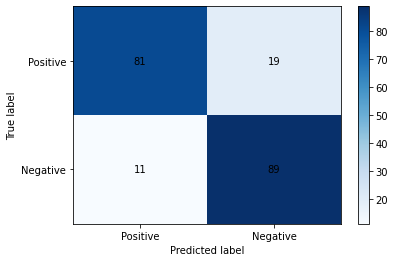

Test loss: 0.02213487058877945 
 Test accuracy: 85.0
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.022867720160219405 
 Training accuracy: 56.777777777777786
Test loss: 0.02348822057247162 
 Test accuracy: 56.99999999999999
------------------------------------------------------------------
epoch 1:
Training loss: 0.01625804512037171 
 Training accuracy: 75.5
Test loss: 0.02672036498785019 
 Test accuracy: 62.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.009902384455005327 
 Training accuracy: 87.72222222222223
Test loss: 0.025754331052303313 
 Test accuracy: 69.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0067213534460299545 
 Training accuracy: 91.27777777777779
Test loss: 0.026302040815353395 
 Test accuracy: 77.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0031495550440417395 
 Tra

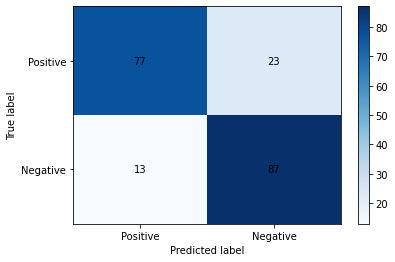

Test loss: 0.029719914644956588 
 Test accuracy: 82.0
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.023027132418420578 
 Training accuracy: 56.888888888888886
Test loss: 0.022879202961921693 
 Test accuracy: 61.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.015146767612960604 
 Training accuracy: 76.5
Test loss: 0.030075677633285523 
 Test accuracy: 64.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.010034663453698158 
 Training accuracy: 87.5
Test loss: 0.03317421302199364 
 Test accuracy: 66.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.005279256326870786 
 Training accuracy: 93.44444444444444
Test loss: 0.01947425238788128 
 Test accuracy: 77.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.003083112983860903 
 Training accuracy: 96.4444444

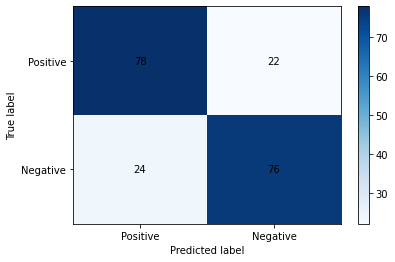

Test loss: 0.03040646970272064 
 Test accuracy: 77.0
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.023261909749772814 
 Training accuracy: 56.277777777777786
Test loss: 0.021872004866600035 
 Test accuracy: 62.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.015335024181339476 
 Training accuracy: 77.27777777777777
Test loss: 0.02754856824874878 
 Test accuracy: 60.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.009800381395551894 
 Training accuracy: 87.72222222222223
Test loss: 0.02375335484743118 
 Test accuracy: 69.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.00625066029942698 
 Training accuracy: 91.88888888888889
Test loss: 0.024950194358825683 
 Test accuracy: 69.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.003990656822505924 
 Train

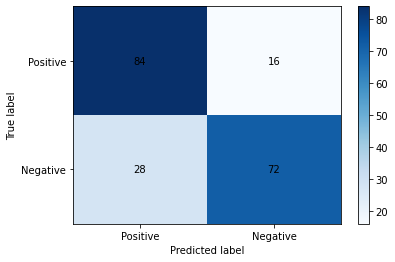

Test loss: 0.030949467271566392 
 Test accuracy: 78.0
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.02281329855322838 
 Training accuracy: 58.77777777777777
Test loss: 0.022354190945625307 
 Test accuracy: 62.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.014782172805733152 
 Training accuracy: 77.66666666666666
Test loss: 0.020961915105581284 
 Test accuracy: 72.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.008954151074091593 
 Training accuracy: 88.77777777777777
Test loss: 0.03789888679981232 
 Test accuracy: 57.49999999999999
------------------------------------------------------------------
epoch 3:
Training loss: 0.005242353950937589 
 Training accuracy: 94.72222222222221
Test loss: 0.02434200605377555 
 Test accuracy: 73.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0029007811109

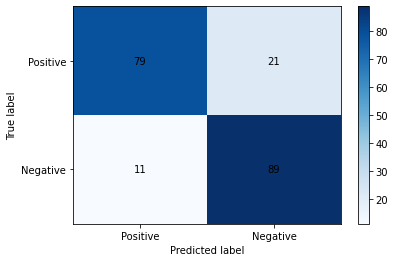

Test loss: 0.024641329646110533 
 Test accuracy: 84.0
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.023386064502927992 
 Training accuracy: 57.666666666666664
Test loss: 0.024535509943962096 
 Test accuracy: 60.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.015924126274055903 
 Training accuracy: 76.38888888888889
Test loss: 0.01951847940683365 
 Test accuracy: 76.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.010553803121050198 
 Training accuracy: 86.61111111111111
Test loss: 0.024624379873275756 
 Test accuracy: 75.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.005850805284248458 
 Training accuracy: 93.22222222222221
Test loss: 0.02261449083685875 
 Test accuracy: 80.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0033931873945726287 
 Tr

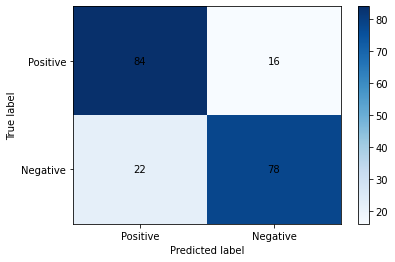

Test loss: 0.02977823346853256 
 Test accuracy: 81.0
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.023071033391687604 
 Training accuracy: 56.888888888888886
Test loss: 0.02289253652095795 
 Test accuracy: 61.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.014554803669452667 
 Training accuracy: 78.16666666666666
Test loss: 0.025723860263824463 
 Test accuracy: 69.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.010824340772297648 
 Training accuracy: 86.44444444444444
Test loss: 0.06298147976398467 
 Test accuracy: 54.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.006605578040083249 
 Training accuracy: 92.11111111111111
Test loss: 0.03071186155080795 
 Test accuracy: 70.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0029062880658441118 
 Trai

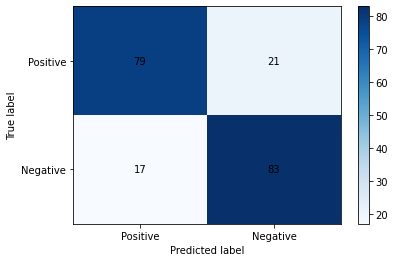

Test loss: 0.021624013185501098 
 Test accuracy: 81.0
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.023212138215700784 
 Training accuracy: 56.72222222222222
Test loss: 0.02232923686504364 
 Test accuracy: 64.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.014848444511493046 
 Training accuracy: 77.5
Test loss: 0.019252582490444183 
 Test accuracy: 76.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.009001422797640164 
 Training accuracy: 87.83333333333333
Test loss: 0.023913780599832533 
 Test accuracy: 72.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.00541440112516284 
 Training accuracy: 93.55555555555556
Test loss: 0.031181253492832184 
 Test accuracy: 66.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.003308350600095259 
 Training accuracy

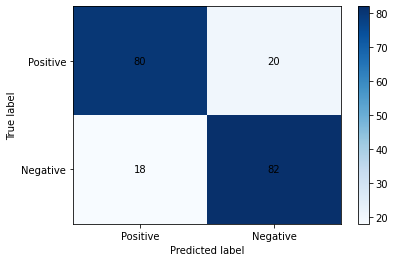

Test loss: 0.024674338698387147 
 Test accuracy: 81.0
------------------------------------------------------------------
Folds statistics:
----------------
 - mean: 80.7 
 - standard deviation: 2.5019992006393608


In [ ]:
# BiLSTM without attention
mean, std = main_cross_validation(main_LSTM, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

### BiLSTM with attention no objective sentences


 Fold: 0
epoch 0:
Training loss: 0.020144571512937547 
 Training accuracy: 64.61111111111111
Test loss: 0.017511043697595596 
 Test accuracy: 78.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.01212425763408343 
 Training accuracy: 83.77777777777777
Test loss: 0.018036968857049942 
 Test accuracy: 78.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.007763432578908072 
 Training accuracy: 90.22222222222223
Test loss: 0.010759258195757865 
 Test accuracy: 86.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.004914938278703226 
 Training accuracy: 94.83333333333334
Test loss: 0.011572172045707702 
 Test accuracy: 87.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.002452295795471097 
 Training accuracy: 97.5
Test loss: 0.025105638206005098 
 Test accuracy: 80.5
----------------------------------------------

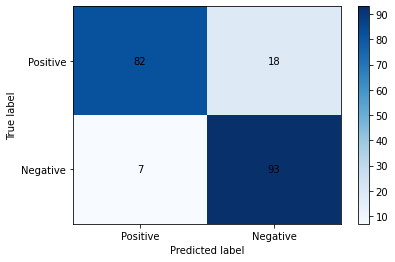

Test loss: 0.023654690384864806 
 Test accuracy: 87.5
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.019758845468362173 
 Training accuracy: 62.88888888888889
Test loss: 0.016997219920158388 
 Test accuracy: 78.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.010916705367465813 
 Training accuracy: 86.61111111111111
Test loss: 0.012298138439655304 
 Test accuracy: 87.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.00789712430909276 
 Training accuracy: 91.0
Test loss: 0.012512426003813743 
 Test accuracy: 84.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0032522601316062115 
 Training accuracy: 96.66666666666667
Test loss: 0.016144748385995625 
 Test accuracy: 85.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0013595675109536387 
 Training accur

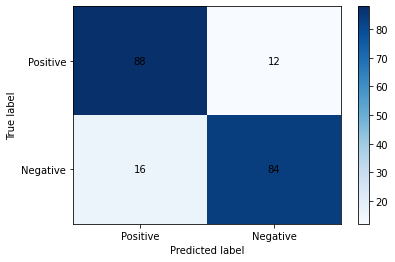

Test loss: 0.03128179193474352 
 Test accuracy: 86.0
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.020933705154392454 
 Training accuracy: 57.72222222222222
Test loss: 0.01791375011205673 
 Test accuracy: 77.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.012212759272919762 
 Training accuracy: 83.33333333333334
Test loss: 0.014892779290676117 
 Test accuracy: 89.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.007084052911442187 
 Training accuracy: 92.11111111111111
Test loss: 0.007963256747461855 
 Test accuracy: 90.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.004141433513723314 
 Training accuracy: 95.5
Test loss: 0.009642617478966713 
 Test accuracy: 89.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0018055395995421955 
 Training accurac

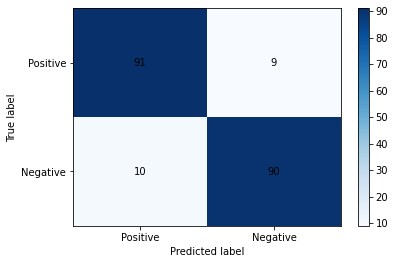

Test loss: 0.01930571023491211 
 Test accuracy: 90.5
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.021152674506107968 
 Training accuracy: 63.0
Test loss: 0.017583660036325454 
 Test accuracy: 77.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.014390600464410251 
 Training accuracy: 78.66666666666666
Test loss: 0.01864068254828453 
 Test accuracy: 81.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.007633031759825017 
 Training accuracy: 90.88888888888889
Test loss: 0.01222828783094883 
 Test accuracy: 88.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0035608492765782608 
 Training accuracy: 95.77777777777777
Test loss: 0.020738162398338318 
 Test accuracy: 85.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0021486188083589593 
 Training accurac

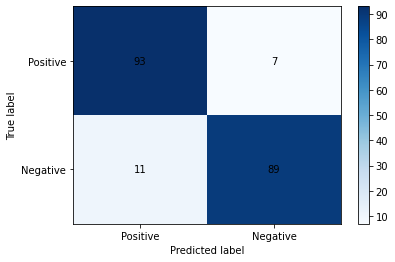

Test loss: 0.023016356596781407 
 Test accuracy: 91.0
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.02041345617837376 
 Training accuracy: 63.33333333333333
Test loss: 0.020760823637247086 
 Test accuracy: 65.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.013137290444638993 
 Training accuracy: 81.72222222222221
Test loss: 0.008789266310632229 
 Test accuracy: 88.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.005466704212336077 
 Training accuracy: 94.0
Test loss: 0.013310426324605941 
 Test accuracy: 89.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0028203902063736073 
 Training accuracy: 97.05555555555556
Test loss: 0.014094651341438294 
 Test accuracy: 88.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0014153422094982993 
 Training accur

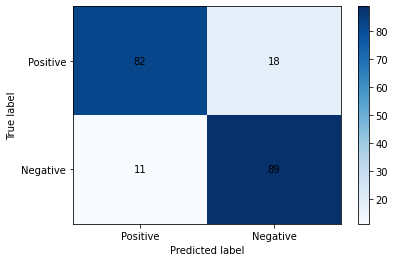

Test loss: 0.01782667917199433 
 Test accuracy: 85.5
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.020591324700249564 
 Training accuracy: 60.94444444444444
Test loss: 0.016993331611156463 
 Test accuracy: 76.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.011525586321949959 
 Training accuracy: 85.38888888888889
Test loss: 0.016846282556653023 
 Test accuracy: 81.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.0066041799924439855 
 Training accuracy: 92.83333333333333
Test loss: 0.02186113953590393 
 Test accuracy: 80.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0036687115493178784 
 Training accuracy: 96.55555555555554
Test loss: 0.017978294268250466 
 Test accuracy: 86.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.003224095867545758 
 Tr

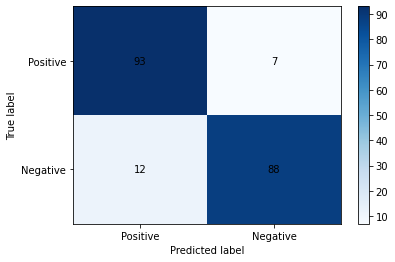

Test loss: 0.030698308032006027 
 Test accuracy: 90.5
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.021871924466556975 
 Training accuracy: 52.44444444444445
Test loss: 0.023136969208717346 
 Test accuracy: 56.99999999999999
------------------------------------------------------------------
epoch 1:
Training loss: 0.01775758898920483 
 Training accuracy: 71.66666666666667
Test loss: 0.016469070166349412 
 Test accuracy: 82.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.009708951533668572 
 Training accuracy: 88.44444444444444
Test loss: 0.01299539089202881 
 Test accuracy: 85.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.005823900285694334 
 Training accuracy: 93.5
Test loss: 0.012324271723628044 
 Test accuracy: 87.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0031287984812580463 
 Tra

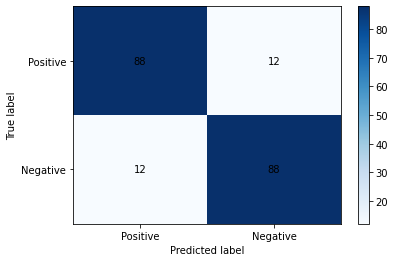

Test loss: 0.01987517237663269 
 Test accuracy: 88.0
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.020949821538395353 
 Training accuracy: 58.611111111111114
Test loss: 0.016781260296702384 
 Test accuracy: 76.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.016508323320498067 
 Training accuracy: 75.44444444444444
Test loss: 0.015472024604678154 
 Test accuracy: 82.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.010028662814034356 
 Training accuracy: 87.8888888888889
Test loss: 0.011630062758922578 
 Test accuracy: 83.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.006361262488903271 
 Training accuracy: 92.94444444444444
Test loss: 0.01344690665602684 
 Test accuracy: 82.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.004347633793950081 
 Trai

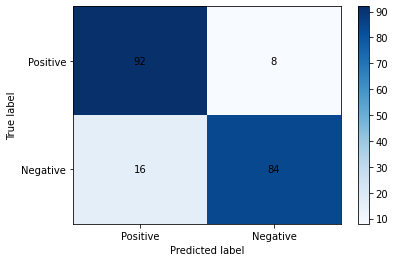

Test loss: 0.016877471953630447 
 Test accuracy: 88.0
------------------------------------------------------------------
Folds statistics:
----------------
 - mean: 88.2 
 - standard deviation: 1.7916472867168916


In [ ]:
# BiLSTM with attention
mean, std = main_cross_validation(main, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

### LBSA

In [ ]:
LBSA_pipeline = Pipeline(UnderscoreRemover(),
                         CharacterRepetitionRemover(),
                         ApostrophesMerger(),
                         ContractionCleaner(),
                         SpecialCharsCleaner(),
                         )
LBSA_corpus = MovieReviewsCorpusLBSA(LBSA_pipeline, path = lexicon_path)
LBSA_embedding_matrix = LBSA_corpus.get_embedding_matrix(global_vectors, 300)
LBSA_dataset = MovieReviewsDatasetLBSA(LBSA_corpus.get_indexed_corpus())

Coverage of the lexicon: 0.3351701371254444


In [ ]:
mean, std = main_cross_validation(main_LBSA, LBSA_dataset, LBSA_embedding_matrix, collateLBSA, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")


 Fold: 0
epoch 0:
Training loss: 0.030758804281552633 
 Training accuracy: 56.49999999999999
Test loss: 0.030670603513717653 
 Test accuracy: 74.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.02273830842640665 
 Training accuracy: 82.05555555555556
Test loss: 0.025034402906894685 
 Test accuracy: 84.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.017096856087446214 
 Training accuracy: 90.61111111111111
Test loss: 0.022761853337287904 
 Test accuracy: 85.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.014869334482484394 
 Training accuracy: 95.72222222222221
Test loss: 0.0269881072640419 
 Test accuracy: 86.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.011819142815139558 
 Training accuracy: 98.61111111111111
Test loss: 0.027656675279140473 
 Test accuracy: 88.0
-----------------------------------

### LBSA no objective sentences

In [ ]:
LBSA_pipeline.add_pipeline_element(ShallowObjectiveSentsRemover(pred))
LBSA_corpus = MovieReviewsCorpusLBSA(LBSA_pipeline, path = lexicon_path)
LBSA_embedding_matrix = LBSA_corpus.get_embedding_matrix(global_vectors, 300)
LBSA_dataset = MovieReviewsDatasetLBSA(LBSA_corpus.get_indexed_corpus())

Coverage of the lexicon: 0.3956659944628636


In [ ]:
mean, std = main_cross_validation(main_LBSA, LBSA_dataset, LBSA_embedding_matrix, collateLBSA, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")


 Fold: 0
epoch 0:
Training loss: 0.0273909721771876 
 Training accuracy: 55.05555555555556
Test loss: 0.026213870942592622 
 Test accuracy: 74.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.018594314604997636 
 Training accuracy: 83.88888888888889
Test loss: 0.018108686953783034 
 Test accuracy: 88.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.011869272904263602 
 Training accuracy: 93.83333333333333
Test loss: 0.019322500228881836 
 Test accuracy: 86.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.010201958475841415 
 Training accuracy: 96.05555555555556
Test loss: 0.018439932465553283 
 Test accuracy: 89.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.008476080372929573 
 Training accuracy: 98.72222222222223
Test loss: 0.019843967854976653 
 Test accuracy: 89.0
----------------------------------

# Result analysis:

## Train a network from scratch

In [ ]:
mr_pipeline = Pipeline(UnderscoreRemover(),
                       CharacterRepetitionRemover(),
                       ApostrophesMerger(),
                       ContractionCleaner(),
                       SpecialCharsCleaner(),
                       ShallowObjectiveSentsRemover(pred)
                      )
mr_corpus = MovieReviewsCorpus(mr_pipeline)
mr_embedding_matrix = mr_corpus.get_embedding_matrix(global_vectors, 300)
mr_dataset = MovieReviewsDataset(mr_corpus.get_indexed_corpus())

epoch 0:
Training loss: 0.020238709170371294 
 Training accuracy: 63.5625
Test loss: 0.01551388494670391 
 Test accuracy: 78.25
------------------------------------------------------------------
epoch 1:
Training loss: 0.012266570432111622 
 Training accuracy: 84.375
Test loss: 0.013737766668200493 
 Test accuracy: 84.75
------------------------------------------------------------------
epoch 2:
Training loss: 0.006218293954152614 
 Training accuracy: 93.3125
Test loss: 0.012209816556423902 
 Test accuracy: 88.25
------------------------------------------------------------------
epoch 3:
Training loss: 0.002882378566719126 
 Training accuracy: 97.0625
Test loss: 0.017774999924004078 
 Test accuracy: 87.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.002454474283149466 
 Training accuracy: 97.5625
Test loss: 0.0175994213600643 
 Test accuracy: 87.75
------------------------------------------------------------------
epoch 5:
Training loss: 0

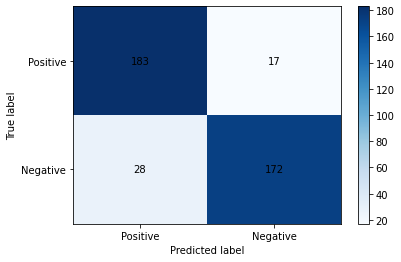

Test loss: 0.023543442734517157 
 Test accuracy: 88.75
------------------------------------------------------------------


In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
train_indexes = [i*1000 + j for i in range(2) for j in range(800)]
test_indexes = [i*1000 + j for i in range(2) for j in range(800,1000)]


train_sampler = SubsetRandomSampler(train_indexes)
test_sampler = SubsetRandomSampler(test_indexes)

train_loader = DataLoader(mr_dataset, batch_size = 32, sampler = train_sampler,
                          collate_fn = collate, pin_memory=True)
test_loader = DataLoader(mr_dataset, batch_size = 32, sampler = test_sampler,
                        collate_fn = collate, pin_memory = True)

# Important that we keep a trained network
net = BiLSTMAttention(mr_embedding_matrix)
test_accuracy = main(train_loader, test_loader, mr_embedding_matrix, device, 10, net)

In [ ]:
def indexed_corpus(corpus, vocab):
  # I don't care about labels since I'm not backpropagating and I am only interested in attention map
  labels = [1 for i in range(len(corpus))]
  new_vocab = {}
  for idx, key in enumerate(vocab.keys()):
    new_vocab[key] = idx

  indexed_corpus = [torch.tensor([torch.tensor(new_vocab[w], dtype=torch.int32) for w in doc]) for doc in corpus]
  return corpus, indexed_corpus, labels

In [ ]:
# I can get training instances just to see attention map
# reduced = mr_corpus.get_subset_indexed_corpus([0, 1000])
some_sentences = mr_pipeline([pos[3]])
some_sentences = some_sentences[0][:5]
reduced = indexed_corpus(some_sentences, mr_corpus.vocab)
reduced_ds = MovieReviewsDataset((reduced[1], reduced[2]))
reduced_dl = DataLoader(reduced_ds, batch_size = 1, collate_fn = collate, pin_memory = True)

## Extract attention vector of the pre-trained model for some sentences.

In [ ]:
net.eval()

with torch.no_grad():
  att = []
  for batch_idx, (inputs, targets, _) in enumerate(reduced_dl):
    inputs = inputs.to(device)
    targets = targets.to(device)
    in_size = targets.size(dim=0)

    outputs, attention = net(inputs)
    att.append(attention)

## Plot

In [ ]:
def plot_attention(attention, sentence, filename = None):
  fig, ax = plt.subplots()
  im = ax.imshow(attention.reshape(-1,1).T, cmap='viridis', aspect='auto', origin='lower')
  ax.set_xticks(range(len(sentence)))
  ax.set_xticklabels(sentence, rotation=90)
  cbar = fig.colorbar(im)
  cbar.set_label("Attention Weight")
  ax.set_yticks([])
  ax.set_aspect("equal")
  if filename != None:
    plt.savefig(filename)

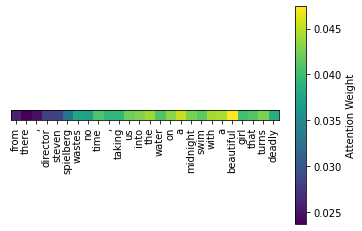

In [ ]:
att_arr = att[2][0].cpu().detach().numpy()
plot_attention(att_arr,reduced[0][2], image_path + "attention1.png")

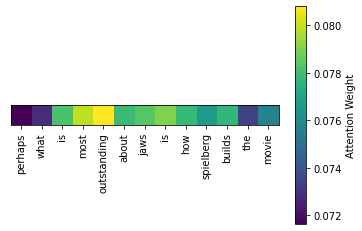

In [ ]:
att_arr = att[4][0].cpu().detach().numpy()
plot_attention(att_arr,reduced[0][4], image_path + "attention2.png")

In [ ]:
LBSA_pipeline = Pipeline(UnderscoreRemover(),
                         CharacterRepetitionRemover(),
                         ApostrophesMerger(),
                         ContractionCleaner(),
                         SpecialCharsCleaner(),
                         )
LBSA_pipeline.add_pipeline_element(ShallowObjectiveSentsRemover(pred))
LBSA_corpus = MovieReviewsCorpusLBSA(LBSA_pipeline, path = lexicon_path)

Coverage of the lexicon: 0.3956659944628636


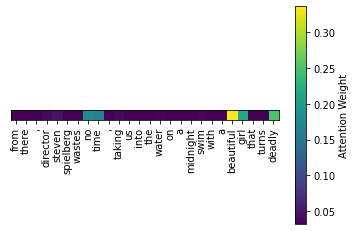

In [ ]:
gold_word = LBSA_corpus.wl_gold_av[1003][2]
plot_attention(gold_word,reduced[0][2], image_path + "gold_w1.png")

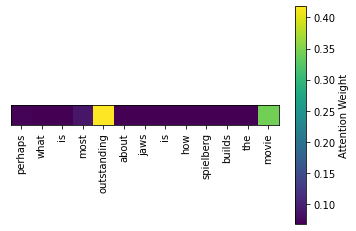

In [ ]:
gold_word = LBSA_corpus.wl_gold_av[1003][4]
plot_attention(gold_word,reduced[0][4], image_path + "gold_w2.png")

In [ ]:
!python --version

Python 3.8.10
